In [1]:
import time
import logging
import gc
import warnings
import os
import tempfile
import ast
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import shap
import folium
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy import stats, optimize
from scipy.stats import zscore
from shapely.geometry import LineString
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, OneHotEncoder, PolynomialFeatures
from folium.plugins import Draw
from folium import Map, Marker
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler, LabelEncoder, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
import tensorflow as tf

import xgboost as xgb
from xgboost import XGBRegressor, DMatrix, train as xgb_train
from flask import Flask, render_template, request, redirect, url_for
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Embedding, Flatten, Conv1D, MaxPooling1D, Reshape, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback,ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import Loss

from IPython.display import display, HTML, IFrame, clear_output
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
from PIL import Image
from textwrap import wrap

import ipywidgets as widgets
from fpdf import FPDF


In [2]:
# Suppress specific warnings from XGBoost
warnings.filterwarnings(action='ignore', category=UserWarning, message='.*deprecated.*')
warnings.filterwarnings(action='ignore', category=UserWarning, message='.*not used.*')
warnings.filterwarnings(action='ignore', category=UserWarning, message='.*No visible GPU is found.*')


In [3]:
display(HTML("""
<style>
.jp-OutputArea-output {
    overflow-y: auto;
}
</style>
"""))


In [4]:
#Load the dataset
#file_path = r'C:\Users\Prakhar.Sarkar\OneDrive - SRP Management Services\Documents\_For_Prakhar\Sample data from Vesna vLandedWells.xlsx' 
# # file_path = r'C:\Users\Prakhar.Sarkar\OneDrive - SRP Management Services\Documents\_For_Prakhar\Prakhar_new.csv'
# df = pd.read_excel(file_path)
# Define the file path
file_path = r'C:\Users\Prakhar.Sarkar\OneDrive - SRP Management Services\Documents\_For_Prakhar\Prakhar_Testnew2.xlsx'

# Define the UWI columns to be read as strings
uwi_columns = ['UWI', 'NNAZ_1_UWI', 'NNAZ_2_UWI', 'NNAZ_3_UWI',
               'NNAZ_4_UWI', 'NNAZ_5_UWI', 'NNAZ_6_UWI', 
               'NNSZ_1_UWI', 'NNSZ_2_UWI']

# Create a dtype dictionary where UWI columns are set to str
dtype_dict = {col: str for col in uwi_columns}

# Load the CSV file with the specified dtype
df = pd.read_excel(file_path, dtype=dtype_dict)

# Convert UWI columns to ensure they are correctly formatted as strings
df['UWI'] = df['UWI'].apply(lambda x: '{:.0f}'.format(float(x)) if pd.notnull(x) else '')
for col in uwi_columns:
    df[col] = df[col].apply(lambda x: '{:.0f}'.format(float(x)) if pd.notnull(x) else '')

# Display some of the UWI column values to verify
print(df[['UWI'] + uwi_columns].head())

              UWI             UWI      NNAZ_1_UWI      NNAZ_2_UWI  \
0  42317410760000  42317410760000  42317408170000  42317410790000   
1  42317410770000  42317410770000  42317410800000  42317410790000   
2  42317410780000  42317410780000  42317410730000  42317410740000   
3  42317410790000  42317410790000  42317410760000  42317410770000   
4  42317410800000  42317410800000  42317414210100  42317410770000   

       NNAZ_3_UWI      NNAZ_4_UWI      NNAZ_5_UWI      NNAZ_6_UWI  \
0  42317408110000  42317410770000  42317410770000  42317410770000   
1  42317414210100  42317410760000  42317410760000  42317410760000   
2  42317410930000  42317440000000  42317440000000  42317440000000   
3  42317408170000  42317410800000  42317410800000  42317410800000   
4  42317414230000  42317410790000  42317410790000  42317410790000   

       NNSZ_1_UWI      NNSZ_2_UWI  
0  42317408170000  42317410790000  
1  42317410800000  42317410790000  
2  42317410730000  42317410930000  
3  42317410760000  4231741

In [5]:
# # Read the first Excel sheet (cumulative data)
# file_path = r'C:\Users\Prakhar.Sarkar\OneDrive - SRP Management Services\Documents\_For_Prakhar\Cumulative Prod for sample data.xlsx'
# cumulative_df = pd.read_excel(file_path)

In [6]:
# df = pd.merge(df, cumulative_df, on='UWI10', how='left')

In [7]:
# Create new columns based on the specified formulas
df['Cumulative oil mbo'] = df['CumLiquid'] / 1000
df['Cumulative gas mmcf'] = df['CumGas'] / 1000
df['Cumulative water mbbl'] = df['CumWater'] / 1000
df['FluidPerFoot_bblft'] = df['FluidPerFoot'] / 42
df['FORMATION_CONDENSED'] = df['FORMATION_CONDENSE']
df = df[(df['FluidPerFoot_bblft'] <= 300) & (df['ProppantPerFoot'] <= 7000)]
# Drop the original columns
df.drop(columns=['CumLiquid', 'CumGas', 'CumWater', 'FluidPerFoot'], inplace=True)

In [8]:
# # Identify rows in df that do not have a match in cumulative_df
# no_match_df = df[df['Cumulative oil mbo'].isnull() & 
#                         df['Cumulative gas mmcf'].isnull() & 
#                         df['Cumulative water mbbl'].isnull()]
# # Print the UWI10 values that did not have a match
# if no_match_df.empty:
#     print("All UWI10 values in the detailed well data have corresponding matches in the cumulative data.")
# else:
#     print("UWI10 values in the detailed well data that did not have a corresponding match in the cumulative data:")
#     print(no_match_df['UWI10'].tolist())

#     # Print the rows with no matching cumulative data
#     print("\nRows with no matching cumulative data:")
#     print(no_match_df)

In [9]:
# def robust_parse(x):
#     if pd.isna(x):
#         return [None] * 7  # Handle NaNs by returning a list of Nones
#     try:
#         if isinstance(x, str):
#             return ast.literal_eval(x)  # Attempt to parse string as a Python literal
#         else:
#             return [x] + [None] * 6  # If x is not a string, return it as the first element with None padding
#     except Exception as e:
#         #print(f"Failed to parse: {x} with error {e}")  # Optionally log the error for debugging
#         return [None] * 7  # Return None values if parsing fails

In [10]:
# Function to robustly parse the values
def robust_parse(x):
    if pd.isna(x):
        return [None] * 7  # Handle NaNs by returning a list of Nones
    try:
        if isinstance(x, str):
            return ast.literal_eval(x)  # Attempt to parse string as a Python literal
        else:
            return [x] + [None] * 6  # If x is not a string, return it as the first element with None padding
    except Exception as e:
        return [None] * 7  # Return None values if parsing fails

# Function to split parameter columns into new columns
def split_parameters(df, param_columns):
    new_columns = []
    for col in param_columns:
        expanded_cols = [f'{col}_Method', f'{col}_BuildupRate', f'{col}_MonthsInProd', 
                         f'{col}_InitialProd', f'{col}_DiCoefficient', f'{col}_BCoefficient', 
                         f'{col}_LimDeclineRate']
        temp_df = pd.DataFrame(df[col].apply(robust_parse).tolist(), columns=expanded_cols)
        # Convert numeric columns to float
        for num_col in expanded_cols:
            if num_col.endswith('_Method'):
                temp_df[num_col] = temp_df[num_col].astype(str)  # Ensuring 'Method' is of string type
            else:
                temp_df[num_col] = pd.to_numeric(temp_df[num_col], errors='coerce')  # Convert to numeric and handle errors
        df = pd.concat([df, temp_df], axis=1)
        new_columns.extend(expanded_cols)
    df.drop(columns=param_columns, inplace=True)
    return df, new_columns

# Function to handle missing values differently for categorical and numerical columns
def handle_missing_values(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    for column in df.columns:
        if column in categorical_columns:
            df[column] = df[column].fillna('Unknown')  # Using 'Unknown' for categorical data
        else:
            df[column] = df[column].fillna(0)  # Assuming 0 is a reasonable fill for numerical data
    return df

# Function to drop rows where any of the new parameter columns have missing data
def drop_na_parameter_columns(df, new_columns):
    df.dropna(subset=[col for col in new_columns if 'Params' in col], inplace=True)
    return df

# Function to group by 'Typecurve' and count occurrences, and sum the 'UWI10' values
def group_and_summarize(df):
    dfnew = df[['UWI10', 'Typecurve']].drop_duplicates()
    grouped_df = dfnew.groupby('Typecurve', as_index=False).count()
    uwi10_sum = grouped_df['UWI10'].sum()
    return grouped_df, uwi10_sum

In [11]:
# Columns to be parsed
param_columns = [
    'Oil_Params_P20', 'Gas_Params_P20', 'Oil_Params_P35', 'Gas_Params_P35', 
    'Oil_Params_P50', 'Gas_Params_P50', 'Oil_Params_P65', 'Gas_Params_P65', 
    'Oil_Params_P80', 'Gas_Params_P80', 'Water_Params_P50'
]
# # Apply robust parsing to each column
# for col in param_columns:
#     df[col] = df[col].apply(robust_parse)
# # Split each parameter into its own column
# new_columns = []
# for col in param_columns:
#     expanded_cols = [f'{col}_Method', f'{col}_BuildupRate', f'{col}_MonthsInProd', 
#                      f'{col}_InitialProd', f'{col}_DiCoefficient', f'{col}_BCoefficient', 
#                      f'{col}_LimDeclineRate']
#     temp_df = pd.DataFrame(df[col].tolist(), columns=expanded_cols)
#     # Convert numeric columns to float
#     for num_col in expanded_cols:
#         if num_col.endswith('_Method'):
#             temp_df[num_col] = temp_df[num_col].astype(str)  # Ensuring 'Method' is of string type
#         else:
#             temp_df[num_col] = pd.to_numeric(temp_df[num_col], errors='coerce')  # Convert to numeric and handle errors
#     df = pd.concat([df, temp_df], axis=1)

# # Drop the original parameter columns
# df.drop(columns=param_columns, inplace=True)
# Apply the functions in sequence
df, new_columns = split_parameters(df, param_columns)
df = handle_missing_values(df)
df = drop_na_parameter_columns(df, new_columns)
grouped_df, uwi10_sum = group_and_summarize(df)

# Display the results
print(grouped_df)
print(uwi10_sum)

              Typecurve  UWI10
0    CoyoteValley_North     96
1    CoyoteValley_South    273
2        FarEast_Howard    109
3                  Hutt    184
4           Mercury_600     75
..                  ...    ...
109            proj96_A     73
110            proj96_B    262
111              proj97    121
112              proj98    246
113              proj99    105

[114 rows x 2 columns]
13599


In [12]:
# # Handling NaN values differently for categorical and numerical columns
# categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
# for column in df.columns:
#     if column in categorical_columns:
#         df[column] = df[column].fillna('Unknown')  # Using 'Unknown' for categorical data
#     else:
#         df[column] = df[column].fillna(0)  # Assuming 0 is a reasonable fill for numerical data
# # Drop rows where any of the new parameter columns have missing data
# df.dropna(subset=[col for col in df.columns if 'Params' in col], inplace=True)

In [13]:
# #df.columns
# dfnew= df[['UWI10','Typecurve']].drop_duplicates()
# dfnew.groupby('Typecurve',as_index=False).count()

In [14]:
# # Grouping by 'Typecurve' and counting the occurrences
# grouped_df = dfnew.groupby('Typecurve', as_index=False).count()

# # Summing the values in the 'UWI10' column
# uwi10_sum = grouped_df['UWI10'].sum()
# uwi10_sum

In [15]:
def drop_zero_rows(df, columns):
    """
    Drops rows from the DataFrame where specified columns have zero values.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    columns (list of str): The columns to check for zero values.
    
    Returns:
    pd.DataFrame: The DataFrame with rows dropped where specified columns have zero values.
    """
    for column in columns:
        initial_count = len(df)
        df = df[df[column] != 0]
        after_drop_count = len(df)
        print(f"Data dropped after removing zero '{column}': {initial_count - after_drop_count}")
    
    return df

In [16]:
def convert_to_absolute_values(df):
    """
    Converts columns with '_HZDIST' and '_VTDIST' in their headers to absolute values.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame with columns to be converted.
    
    Returns:
    pd.DataFrame: The DataFrame with specified columns converted to absolute values.
    """
    columns_to_convert = [col for col in df.columns if '_HZDIST' in col or '_VTDIST' in col]
    
    df[columns_to_convert] = df[columns_to_convert].abs()
    
    return df

In [17]:
def replace_missing_water_params(df):
    # Define the oil and water parameter columns
    oil_columns = {
        'InitialProd': 'Oil_Params_P50_InitialProd',
        'DiCoefficient': 'Oil_Params_P50_DiCoefficient',
        'BCoefficient': 'Oil_Params_P50_BCoefficient',
        'BuildupRate': 'Oil_Params_P50_BuildupRate',
        'MonthsInProd': 'Oil_Params_P50_MonthsInProd',
        'LimDeclineRate': 'Oil_Params_P50_LimDeclineRate'
    }

    water_columns = {
        'InitialProd': 'Water_Params_P50_InitialProd',
        'DiCoefficient': 'Water_Params_P50_DiCoefficient',
        'BCoefficient': 'Water_Params_P50_BCoefficient',
        'BuildupRate': 'Water_Params_P50_BuildupRate',
        'MonthsInProd': 'Water_Params_P50_MonthsInProd',
        'LimDeclineRate': 'Water_Params_P50_LimDeclineRate',
        'EUR_30yr_Actual_Water_P50_MBBL': 'EUR_30yr_Actual_Water_P50_MBBL'
    }

    # Replace missing water values with 3 times the corresponding oil values or same as oil values
    for param, oil_col in oil_columns.items():
        water_col = water_columns.get(param)
        if water_col:
            if param == 'InitialProd':
                df[water_col] = df.apply(
                    lambda row: row[oil_col] * 3 if row[water_col] == 0 else row[water_col], axis=1
                )
            else:
                df[water_col] = df.apply(
                    lambda row: row[oil_col] if row[water_col] == 0 else row[water_col], axis=1
                )
            
    df['EUR_30yr_Actual_Water_P50_MBBL'] = df.apply(
        lambda row: row['EUR_30yr_Actual_Oil_P50_MBO'] * 3 if row['EUR_30yr_Actual_Water_P50_MBBL'] == 0 else row['EUR_30yr_Actual_Water_P50_MBBL'], axis=1
    )

    return df

In [18]:
# Define a function to replace zeros with the P50 value for the same category
def replace_zeros_with_P50(df):
    # Replace for EUR values
    phases = ['Oil', 'Gas', 'Water']  # Assuming Water is also needed; adjust as necessary
    years = ['30yr']  # Adjust or extend if there are other year ranges
    
    for phase in phases:
        for year in years:
            p50_col = f'EUR_{year}_Actual_{phase}_P50_' + ('MBO' if phase != 'Gas' else 'MMCF')
            if phase == 'Water':
                p50_col = f'EUR_{year}_Actual_{phase}_P50_MBBL'  # Assuming water is measured in MBBL

            for p in ['P20', 'P35', 'P65', 'P80']:
                p_col = f'EUR_{year}_Actual_{phase}_{p}_' + ('MBO' if phase != 'Gas' else 'MMCF')
                if phase == 'Water':
                    p_col = f'EUR_{year}_Actual_{phase}_{p}_MBBL'
                
                if p_col in df.columns and p50_col in df.columns:
                    df.loc[df[p_col] == 0, p_col] = df[p50_col]

    # Replace for parameters
    params = ['Method', 'BuildupRate', 'MonthsInProd', 'InitialProd', 'DiCoefficient', 'BCoefficient', 'LimDeclineRate']
    ###Log
    for phase in ['Oil', 'Gas', 'Water']:  # Assuming Water parameters are also needed
        for param in params:
            p50_col = f'{phase}_Params_P50_{param}'
            for p in ['P20', 'P35', 'P65', 'P80']:
                p_col = f'{phase}_Params_{p}_{param}'
                if p_col in df.columns and p50_col in df.columns:
                    df.loc[df[p_col] == 0, p_col] = df[p50_col]

In [19]:
# columns_to_check = ['FluidPerFoot_bblft', 'ProppantPerFoot', 'EUR_30yr_Actual_Gas_P50_MMCF', 
#                     'EUR_30yr_Actual_Oil_P50_MBO', 'EUR_30yr_Actual_Water_P50_MBBL', 'HEELPOINT_LAT']
columns_to_check = ['FluidPerFoot_bblft', 'ProppantPerFoot', 'EUR_30yr_Actual_Gas_P50_MMCF', 
                    'EUR_30yr_Actual_Oil_P50_MBO', 'HEELPOINT_LAT']
# Dropping columns with missing values in columns_to_check list
df = drop_zero_rows(df, columns_to_check)
#Converting _HZDIST and _VTDIST columns to absolute values
df = convert_to_absolute_values(df)
# Replace missing water parameters when missing
df = replace_missing_water_params(df)
# Replace missing other P parameters with P50 values if missing
replace_zeros_with_P50(df)

Data dropped after removing zero 'FluidPerFoot_bblft': 1935
Data dropped after removing zero 'ProppantPerFoot': 0
Data dropped after removing zero 'EUR_30yr_Actual_Gas_P50_MMCF': 4
Data dropped after removing zero 'EUR_30yr_Actual_Oil_P50_MBO': 1
Data dropped after removing zero 'HEELPOINT_LAT': 339


In [20]:
def create_well_map(df, output_html='wells_map.html'):
    """
    Creates a folium map with well data.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame with well data.
    output_html (str): The filename for the output HTML map.
    
    Returns:
    folium.Map: The generated folium map.
    """
    # Drop rows where latitude or longitude values are missing
    df.dropna(subset=['HEELPOINT_LAT', 'HEELPOINT_LON', 'MIDPOINT_LAT', 'MIDPOINT_LON', 'TOEPOINT_LAT', 'TOEPOINT_LON'], inplace=True)
    
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['HEELPOINT_LON'], df['HEELPOINT_LAT']))
    
    # Create a LineString for each well
    gdf['line'] = gdf.apply(lambda row: LineString([
        (row['HEELPOINT_LON'], row['HEELPOINT_LAT']),
        (row['MIDPOINT_LON'], row['MIDPOINT_LAT']),
        (row['TOEPOINT_LON'], row['TOEPOINT_LAT'])
    ]), axis=1)
    
    # Create a GeoDataFrame with the LineStrings
    line_gdf = gpd.GeoDataFrame(gdf, geometry='line')
    
    # Calculate bounds to set the map's initial view
    bounds = line_gdf.total_bounds  # [minx, miny, maxx, maxy]
    center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]  # [(miny + maxy)/2, (minx + maxx)/2]
    
    # Create a folium map centered on the calculated center
    m = folium.Map(location=center, zoom_start=10)
    
    # Fit map to bounds
    m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])
    
    # Add the lines to the map
    for _, row in line_gdf.iterrows():
        line_points = [
            (row['HEELPOINT_LAT'], row['HEELPOINT_LON']),
            (row['MIDPOINT_LAT'], row['MIDPOINT_LON']),
            (row['TOEPOINT_LAT'], row['TOEPOINT_LON'])
        ]
        folium.PolyLine(line_points, color='blue').add_to(m)
        # Add marker for midpoint with a popup showing coordinates or other info
        folium.Marker(location=line_points[1], popup=f'Well ID: {row["WellName"]}', tooltip='Click for info').add_to(m)
    
    # Add draw control to the map to allow for area selection
    draw = Draw(export=True)
    m.add_child(draw)
    
    # Save the map to an HTML file
    m.save(output_html)
    
    return m
#display(IFrame('wells_map.html', width=700, height=500))


In [21]:
#m = create_well_map(df)
#m

In [22]:
# def add_neighbor_eur_cumulative(df):
#     if df is None:
#         raise ValueError("The input DataFrame is None. Please provide a valid DataFrame.")

#     # Check if the UWI column exists
#     if 'UWI' not in df.columns:
#         raise ValueError("The input DataFrame does not contain the 'UWI' column.")

#     # Define the EUR columns we're interested in
#     eur_oil_columns = ['EUR_30yr_Actual_Oil_P20_MBO', 'EUR_30yr_Actual_Oil_P35_MBO', 
#                        'EUR_30yr_Actual_Oil_P50_MBO', 'EUR_30yr_Actual_Oil_P65_MBO', 
#                        'EUR_30yr_Actual_Oil_P80_MBO']
#     eur_gas_columns = ['EUR_30yr_Actual_Gas_P20_MMCF', 'EUR_30yr_Actual_Gas_P35_MMCF', 
#                        'EUR_30yr_Actual_Gas_P50_MMCF', 'EUR_30yr_Actual_Gas_P65_MMCF', 
#                        'EUR_30yr_Actual_Gas_P80_MMCF']
#     cumulative_columns = ['Cumulative oil mbo', 'Cumulative gas mmcf', 'Cumulative water mbbl']

#     # Check if the required EUR columns exist
#     missing_columns = [col for col in eur_oil_columns + eur_gas_columns + cumulative_columns if col not in df.columns]
#     if missing_columns:
#         raise ValueError(f"The input DataFrame is missing the following required columns: {missing_columns}")

#     # Create a mapping DataFrame that will be used for mapping EUR values
#     eur_cumulative_map = df.set_index('UWI')[eur_oil_columns + eur_gas_columns + cumulative_columns].fillna(0).copy()

#     # Create a dictionary to hold the new columns
#     new_columns = {}

#     # Iterate over NNAZ and NNSZ columns
#     for prefix in ['NNAZ', 'NNSZ']:
#         num_cols = 6 if prefix == 'NNAZ' else 2  # Assuming 6 NNAZ and 2 NNSZ columns
#         for i in range(1, num_cols + 1):
#             uwi_col = f'{prefix}_{i}_UWI'
#             if uwi_col in df.columns:  # Ensure the UWI column exists
#                 for eur_col in eur_oil_columns + eur_gas_columns + cumulative_columns:
#                     new_col_name = f'{prefix}_{i}_{eur_col}'
#                     # Use the map function to add EUR values from the eur_cumulative_map DataFrame
#                     new_columns[new_col_name] = df[uwi_col].map(eur_cumulative_map[eur_col])

#     # Concatenate the new columns to the original dataframe
#     df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)

#     return df
# Define bounds for each basin in a dictionary.
# The keys are basin names, and the values are tuples of (lat_min, lat_max, lon_min, lon_max).
basin_bounds = {
    'Midland': {'lat_range': (29, 34), 'lon_range': (-110, -109)}
    # Add more basins with their geographic bounds 
}
def assign_basin_tc(row):
    # Check if BasinTC is 0 or missing (use pd.isna() and explicitly handle pd.NA)
    if pd.isna(row['BasinTC'])== 'Unknown' or row['BasinTC'] == 0:
        matched_basin = None
        for basin, bounds in basin_bounds.items():
            # Ensure all comparisons are done within bounds
            if ((bounds['lat_range'][0] <= row['HEELPOINT_LAT'] <= bounds['lat_range'][1] and
                 bounds['lon_range'][0] <= row['HEELPOINT_LON'] <= bounds['lon_range'][1]) or
                (bounds['lat_range'][0] <= row['MIDPOINT_LAT'] <= bounds['lat_range'][1] and
                 bounds['lon_range'][0] <= row['MIDPOINT_LON'] <= bounds['lon_range'][1]) or
                (bounds['lat_range'][0] <= row['TOEPOINT_LAT'] <= bounds['lat_range'][1] and
                 bounds['lon_range'][0] <= row['TOEPOINT_LON'] <= bounds['lon_range'][1])):
                matched_basin = basin
                break
        return matched_basin if matched_basin else row['BasinTC']
    return row['BasinTC']

In [23]:
# def add_neighbor_eur_cumulative(df):
#     if df is None:
#         raise ValueError("The input DataFrame is None. Please provide a valid DataFrame.")

#     # Check if the UWI column exists
#     if 'UWI' not in df.columns:
#         raise ValueError("The input DataFrame does not contain the 'UWI' column.")

#     # Define the EUR columns we're interested in
#     eur_oil_columns = ['EUR_30yr_Actual_Oil_P20_MBO', 'EUR_30yr_Actual_Oil_P35_MBO', 
#                        'EUR_30yr_Actual_Oil_P50_MBO', 'EUR_30yr_Actual_Oil_P65_MBO', 
#                        'EUR_30yr_Actual_Oil_P80_MBO']
#     eur_gas_columns = ['EUR_30yr_Actual_Gas_P20_MMCF', 'EUR_30yr_Actual_Gas_P35_MMCF', 
#                        'EUR_30yr_Actual_Gas_P50_MMCF', 'EUR_30yr_Actual_Gas_P65_MMCF', 
#                        'EUR_30yr_Actual_Gas_P80_MMCF']
#     cumulative_columns = ['Cumulative oil mbo', 'Cumulative gas mmcf', 'Cumulative water mbbl']

#     # Check if the required EUR columns exist
#     missing_columns = [col for col in eur_oil_columns + eur_gas_columns + cumulative_columns if col not in df.columns]
#     if missing_columns:
#         raise ValueError(f"The input DataFrame is missing the following required columns: {missing_columns}")

#     # Create a mapping DataFrame that will be used for mapping EUR values
#     eur_cumulative_map = df.set_index('UWI')[eur_oil_columns + eur_gas_columns + cumulative_columns].fillna(0).copy()
    
#     # Ensure the index is unique
#     if not eur_cumulative_map.index.is_unique:
#         eur_cumulative_map = eur_cumulative_map.groupby(eur_cumulative_map.index).first()

#     # Create a dictionary to hold the new columns
#     new_columns = {}

#     # Iterate over NNAZ and NNSZ columns
#     for prefix in ['NNAZ', 'NNSZ']:
#         num_cols = 6 if prefix == 'NNAZ' else 2  # Assuming 6 NNAZ and 2 NNSZ columns
#         for i in range(1, num_cols + 1):
#             uwi_col = f'{prefix}_{i}_UWI'
#             if uwi_col in df.columns:  # Ensure the UWI column exists
#                 for eur_col in eur_oil_columns + eur_gas_columns + cumulative_columns:
#                     new_col_name = f'{prefix}_{i}_{eur_col}'
#                     # Use the map function to add EUR values from the eur_cumulative_map DataFrame
#                     new_columns[new_col_name] = df[uwi_col].map(eur_cumulative_map[eur_col])

#     # Concatenate the new columns to the original dataframe
#     df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)

#     return df

In [24]:
def scale_parameters(df, horizontal_well_length_column, apply_scaling=True):
    """
    Scales the specified parameters by the horizontal well length using the provided formula.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the relevant columns.
        horizontal_well_length_column (str): The name of the column containing the horizontal well length.
        apply_scaling (bool): Whether to apply the scaling. If True, scaling is applied and the horizontal well length column is removed.

    Returns:
        pd.DataFrame: The DataFrame with scaled values.
    """

    # Define the columns to be scaled based on the provided conditions
    scaling_columns = [col for col in df.columns if 'InitialProd' in col or
                       'Cumulative oil mbo' in col or
                       'Cumulative gas mmcf' in col or
                       'Cumulative water mbbl' in col or
                       'EUR_30yr_Actual_Oil' in col or
                       'EUR_30yr_Actual_Gas' in col or
                       'EUR_30yr_Actual_Water' in col]

    if apply_scaling:
        # Apply the scaling formula to each relevant column
        for col in scaling_columns:
            df[col] = df.apply(lambda row: row[col] * (
                (1 - 0.03 * (10000 - row[horizontal_well_length_column]) / 2500) * 
                10000 / row[horizontal_well_length_column]), axis=1)

        # Drop the horizontal well length column if scaling is applied
        df = df.drop(columns=[horizontal_well_length_column])

    return df
    
def add_neighbor_eur_cumulative(df):
    if df is None:
        raise ValueError("The input DataFrame is None. Please provide a valid DataFrame.")

    # Check if the UWI and CompletionDate columns exist
    if 'UWI' not in df.columns:
        raise ValueError("The input DataFrame does not contain the 'UWI' column.")
    if 'CompletionDate' not in df.columns:
        raise ValueError("The input DataFrame does not contain the 'CompletionDate' column.")

    # Define the EUR columns we're interested in
    eur_oil_columns = ['EUR_30yr_Actual_Oil_P20_MBO', 'EUR_30yr_Actual_Oil_P35_MBO', 
                       'EUR_30yr_Actual_Oil_P50_MBO', 'EUR_30yr_Actual_Oil_P65_MBO', 
                       'EUR_30yr_Actual_Oil_P80_MBO']
    eur_gas_columns = ['EUR_30yr_Actual_Gas_P20_MMCF', 'EUR_30yr_Actual_Gas_P35_MMCF', 
                       'EUR_30yr_Actual_Gas_P50_MMCF', 'EUR_30yr_Actual_Gas_P65_MMCF', 
                       'EUR_30yr_Actual_Gas_P80_MMCF']
    cumulative_columns = ['Cumulative oil mbo', 'Cumulative gas mmcf', 'Cumulative water mbbl']

    # Check if the required EUR columns exist
    missing_columns = [col for col in eur_oil_columns + eur_gas_columns + cumulative_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"The input DataFrame is missing the following required columns: {missing_columns}")

    # Ensure CompletionDate is in datetime format and drop rows with missing dates
    # df['CompletionDate'] = pd.to_datetime(df['CompletionDate'], errors='coerce')
    # df = df.dropna(subset=['CompletionDate'])

    # Create a mapping DataFrame that will be used for mapping EUR values and CompletionDate
    eur_cumulative_map = df.set_index('UWI')[eur_oil_columns + eur_gas_columns + cumulative_columns + ['CompletionDate']].fillna(0).copy()
    
    # Ensure the index is unique
    if not eur_cumulative_map.index.is_unique:
        eur_cumulative_map = eur_cumulative_map.groupby(eur_cumulative_map.index).first()

    # Create a dictionary to hold the new columns
    new_columns = {}

    # Iterate over NNAZ and NNSZ columns
    for prefix in ['NNAZ', 'NNSZ']:
        num_cols = 6 if prefix == 'NNAZ' else 2  # Assuming 6 NNAZ and 2 NNSZ columns
        for i in range(1, num_cols + 1):
            uwi_col = f'{prefix}_{i}_UWI'
            if uwi_col in df.columns:  # Ensure the UWI column exists
                for eur_col in eur_oil_columns + eur_gas_columns + cumulative_columns:
                    new_col_name = f'{prefix}_{i}_{eur_col}'
                    # Use the map function to add EUR values from the eur_cumulative_map DataFrame
                    new_columns[new_col_name] = df[uwi_col].map(eur_cumulative_map[eur_col]).fillna(0)
                
                # # Calculate TimeProduced
                # time_produced_col = f'{prefix}_{i}_TimeProduced'
                # completion_dates = df[uwi_col].map(eur_cumulative_map['CompletionDate'])
                # time_produced = (pd.Timestamp.now() - completion_dates).dt.days / 30.44  # Convert days to months
                # new_columns[time_produced_col] = time_produced.fillna(0)

    # Concatenate the new columns to the original dataframe
    df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)

    return df

In [25]:
# Define the function to fill zero parameters
def fill_zero_parameters(df):
    for prefix in ['NNAZ', 'NNSZ']:
        num_cols = 6 if prefix == 'NNAZ' else 2
        for i in range(1, num_cols + 1):
            hzd_col = f'{prefix}_{i}_HZDIST'
            true_col = f'{prefix}_{i}_TRUEDIST'
            vt_col = f'{prefix}_{i}_VTDIST'
            
            if hzd_col in df.columns:
                # Replace zero values in _HZDIST with 5280
                df[hzd_col] = df[hzd_col].replace(0, 5280)
            
            if true_col in df.columns and vt_col in df.columns:
                # Calculate _TRUEDIST using sqrt(_HZDIST^2 + _VTDIST^2)
                df[true_col] = np.sqrt(df[hzd_col] ** 2 + df[vt_col] ** 2)
    return df
# Define the function to check for mismatches, TRUEDIST values < 100, and drop those rows
def check_and_clean_parameters(df):
    mismatches = {}
    tru_dist_below_100 = {}
    tru_dist_below_100_indices = set()
    
    for prefix in ['NNAZ', 'NNSZ']:
        num_cols = 6 if prefix == 'NNAZ' else 2
        for i in range(1, num_cols + 1):
            hzd_col = f'{prefix}_{i}_HZDIST'
            true_col = f'{prefix}_{i}_TRUEDIST'
            vt_col = f'{prefix}_{i}_VTDIST'
            
            if hzd_col in df.columns and true_col in df.columns and vt_col in df.columns:
                # Check for mismatches
                calculated_true_dist = np.sqrt(df[hzd_col] ** 2 + df[vt_col] ** 2)
                mismatched_indices = df[(df[true_col] != 0) & (df[true_col] != calculated_true_dist)].index
                mismatches[true_col] = mismatched_indices.tolist()

                # Check for TRUEDIST values < 100
                tru_dist_below_100_indices.update(df[df[true_col] < 100].index)
                tru_dist_below_100[true_col] = df[df[true_col] < 100].index.tolist()
    
    # Drop rows with TRUEDIST values < 100
    df_cleaned = df.drop(list(tru_dist_below_100_indices))
    
    return mismatches, tru_dist_below_100, df_cleaned
# Function to check for zeros in the specified columns
def check_for_zeros(df):
    zero_columns = []
    for prefix in ['NNAZ', 'NNSZ']:
        num_cols = 6 if prefix == 'NNAZ' else 2
        for i in range(1, num_cols + 1):
            hzd_col = f'{prefix}_{i}_HZDIST'
            true_col = f'{prefix}_{i}_TRUEDIST'
            if hzd_col in df.columns and (df[hzd_col] == 0).any():
                zero_columns.append(hzd_col)
            if true_col in df.columns and (df[true_col] == 0).any():
                zero_columns.append(true_col)
    return zero_columns

In [26]:
# Define a function to display columns and let the user select the ones to drop
def select_and_drop_columns(df):
    # Display the columns with indices
    print("Available columns:")
    for i, col in enumerate(df.columns):
        print(f"{i}: {col}")

    # Ask the user to input the indices of columns to drop, separated by commas
    selected_indices = input("Enter the indices of columns you want to drop, separated by commas: ")
    selected_indices = list(map(int, selected_indices.split(',')))

    # Drop the selected columns
    columns_to_drop = [df.columns[i] for i in selected_indices]
    df.drop(columns=columns_to_drop, inplace=True)
    return df

In [27]:
apply_scaling=False
df = scale_parameters(df, 'HORIZONTIAL_WELL_LENGTH', apply_scaling)
df = add_neighbor_eur_cumulative(df)
# Apply the function to each row
df['BasinTC'] = df.apply(assign_basin_tc, axis=1)
# Drop rows where 'BasinTC' is 'Unknown'
df = df[df['BasinTC'] != 'Unknown']
# Assume 'df' is your DataFrame
df = fill_zero_parameters(df)
zero_columns = check_for_zeros(df)
# Check for mismatches, TRUEDIST values < 100, and clean the DataFrame
mismatches, tru_dist_below_100, df = check_and_clean_parameters(df)

if zero_columns:
    print(f"Columns with zeros after replacement: {zero_columns}")
else:
    print("No columns contain zeros after replacement.")

C:\Users\Prakhar.Sarkar\AppData\Local\Temp\ipykernel_25152\1188512361.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eur_cumulative_map = df.set_index('UWI')[eur_oil_columns + eur_gas_columns + cumulative_columns + ['CompletionDate']].fillna(0).copy()


No columns contain zeros after replacement.


In [28]:
# Call the function and pass the DataFrame
#df = select_and_drop_columns(df)


In [29]:
 columns_to_drop=['UWI10', 'CompletionDate' ,'UWI', 'WellName','NNAZ_1_UWI','NNAZ_2_UWI','NNAZ_3_UWI','NNAZ_4_UWI','NNAZ_5_UWI',
                 'NNAZ_6_UWI','NNSZ_1_UWI',
 'NNSZ_2_UWI','LeaseName', 'WellNumber', 'CurrentOperatorName', 'OriginalOperatorName', 'DrillingContractorName', 'PermitDate', 
                 'SpudDate','FORMATION_CONDENSE', 'Unique_PDP_ID','EUR_30yr_Actual_Oil_P20_MBO',
 'EUR_30yr_Actual_Gas_P20_MMCF', 'EUR_30yr_Actual_Oil_P35_MBO', 'EUR_30yr_Actual_Gas_P35_MMCF', 'EUR_30yr_Actual_Oil_P50_MBO', 
                 'EUR_30yr_Actual_Gas_P50_MMCF',
 'EUR_30yr_Actual_Oil_P65_MBO', 'EUR_30yr_Actual_Gas_P65_MMCF', 'EUR_30yr_Actual_Oil_P80_MBO', 'EUR_30yr_Actual_Gas_P80_MMCF',
                 'EUR_30yr_Actual_Water_P50_MBBL','WELL_TORTUOSITY','DEPTH_TO_TOP_2Q',
 'DEPTH_TO_TOP_3Q', 'DEPTH_TO_TOP_4Q', 'AZIMUTH','DEPTH_ABOVE_ZONE_2Q',  'DEPTH_ABOVE_ZONE_3Q', 'DEPTH_ABOVE_ZONE_4Q','Cumulative oil mbo', 
 'Cumulative gas mmcf', 'Cumulative water mbbl','AVERAGE_INCLINATION','DEPTH_TO_TOP_1Q','HEELPOINT_DEPTH','TOEPOINT_DEPTH', 'NNSZ_1_FORMATION',
 'NNSZ_2_FORMATION','NNAZ_1_FORMATION', 'NNAZ_2_FORMATION', 'NNAZ_3_FORMATION', 'NNAZ_4_FORMATION', 'NNAZ_5_FORMATION', 'NNAZ_6_FORMATION'
                  ,
 'NNAZ_3_EUR_30yr_Actual_Oil_P20_MBO', 'NNAZ_3_EUR_30yr_Actual_Oil_P35_MBO', 'NNAZ_3_EUR_30yr_Actual_Oil_P50_MBO',
 'NNAZ_3_EUR_30yr_Actual_Oil_P65_MBO', 'NNAZ_3_EUR_30yr_Actual_Oil_P80_MBO', 'NNAZ_3_EUR_30yr_Actual_Gas_P20_MMCF',
 'NNAZ_3_EUR_30yr_Actual_Gas_P35_MMCF', 'NNAZ_3_EUR_30yr_Actual_Gas_P50_MMCF', 'NNAZ_3_EUR_30yr_Actual_Gas_P65_MMCF',
 'NNAZ_3_EUR_30yr_Actual_Gas_P80_MMCF', 'NNAZ_3_Cumulative oil mbo', 'NNAZ_3_Cumulative gas mmcf', 'NNAZ_3_Cumulative water mbbl',
 'NNAZ_4_EUR_30yr_Actual_Oil_P20_MBO', 'NNAZ_4_EUR_30yr_Actual_Oil_P35_MBO', 'NNAZ_4_EUR_30yr_Actual_Oil_P50_MBO',
 'NNAZ_4_EUR_30yr_Actual_Oil_P65_MBO', 'NNAZ_4_EUR_30yr_Actual_Oil_P80_MBO', 'NNAZ_4_EUR_30yr_Actual_Gas_P20_MMCF',
 'NNAZ_4_EUR_30yr_Actual_Gas_P35_MMCF', 'NNAZ_4_EUR_30yr_Actual_Gas_P50_MMCF', 'NNAZ_4_EUR_30yr_Actual_Gas_P65_MMCF',
 'NNAZ_4_EUR_30yr_Actual_Gas_P80_MMCF', 'NNAZ_4_Cumulative oil mbo', 'NNAZ_4_Cumulative gas mmcf',
 'NNAZ_4_Cumulative water mbbl', 'NNAZ_5_EUR_30yr_Actual_Oil_P20_MBO', 'NNAZ_5_EUR_30yr_Actual_Oil_P35_MBO',
 'NNAZ_5_EUR_30yr_Actual_Oil_P50_MBO', 'NNAZ_5_EUR_30yr_Actual_Oil_P65_MBO', 'NNAZ_5_EUR_30yr_Actual_Oil_P80_MBO',
 'NNAZ_5_EUR_30yr_Actual_Gas_P20_MMCF', 'NNAZ_5_EUR_30yr_Actual_Gas_P35_MMCF', 'NNAZ_5_EUR_30yr_Actual_Gas_P50_MMCF',
 'NNAZ_5_EUR_30yr_Actual_Gas_P65_MMCF', 'NNAZ_5_EUR_30yr_Actual_Gas_P80_MMCF', 'NNAZ_5_Cumulative oil mbo',
 'NNAZ_5_Cumulative gas mmcf', 'NNAZ_5_Cumulative water mbbl', 'NNAZ_6_EUR_30yr_Actual_Oil_P20_MBO',
 'NNAZ_6_EUR_30yr_Actual_Oil_P35_MBO', 'NNAZ_6_EUR_30yr_Actual_Oil_P50_MBO', 'NNAZ_6_EUR_30yr_Actual_Oil_P65_MBO',
 'NNAZ_6_EUR_30yr_Actual_Oil_P80_MBO', 'NNAZ_6_EUR_30yr_Actual_Gas_P20_MMCF', 'NNAZ_6_EUR_30yr_Actual_Gas_P35_MMCF',
 'NNAZ_6_EUR_30yr_Actual_Gas_P50_MMCF', 'NNAZ_6_EUR_30yr_Actual_Gas_P65_MMCF', 'NNAZ_6_EUR_30yr_Actual_Gas_P80_MMCF',
 'NNAZ_6_Cumulative oil mbo', 'NNAZ_6_Cumulative gas mmcf', 'NNAZ_6_Cumulative water mbbl',
                 'DEPTH_ABOVE_ZONE_1Q',
 # ,
 'NNAZ_1_EUR_30yr_Actual_Oil_P20_MBO', 'NNAZ_1_EUR_30yr_Actual_Oil_P35_MBO',  'NNAZ_1_EUR_30yr_Actual_Oil_P65_MBO',
 'NNAZ_1_EUR_30yr_Actual_Oil_P80_MBO', 'NNAZ_1_EUR_30yr_Actual_Gas_P20_MMCF', 'NNAZ_1_EUR_30yr_Actual_Gas_P35_MMCF',
 'NNAZ_1_EUR_30yr_Actual_Gas_P65_MMCF', 'NNAZ_1_EUR_30yr_Actual_Gas_P80_MMCF', 'NNAZ_2_EUR_30yr_Actual_Oil_P20_MBO',
 'NNAZ_2_EUR_30yr_Actual_Oil_P35_MBO', 'NNAZ_2_EUR_30yr_Actual_Oil_P65_MBO', 'NNAZ_2_EUR_30yr_Actual_Oil_P80_MBO',
 'NNAZ_2_EUR_30yr_Actual_Gas_P20_MMCF', 'NNAZ_2_EUR_30yr_Actual_Gas_P35_MMCF', 'NNAZ_2_EUR_30yr_Actual_Gas_P65_MMCF',
 'NNAZ_2_EUR_30yr_Actual_Gas_P80_MMCF', 'NNSZ_1_EUR_30yr_Actual_Oil_P20_MBO', 'NNSZ_1_EUR_30yr_Actual_Oil_P35_MBO',
 'NNSZ_1_EUR_30yr_Actual_Oil_P65_MBO', 'NNSZ_1_EUR_30yr_Actual_Oil_P80_MBO', 'NNSZ_1_EUR_30yr_Actual_Gas_P20_MMCF',
 'NNSZ_1_EUR_30yr_Actual_Gas_P35_MMCF', 'NNSZ_1_EUR_30yr_Actual_Gas_P65_MMCF', 'NNSZ_1_EUR_30yr_Actual_Gas_P80_MMCF',
 'NNSZ_2_EUR_30yr_Actual_Oil_P20_MBO', 'NNSZ_2_EUR_30yr_Actual_Oil_P35_MBO', 'NNSZ_2_EUR_30yr_Actual_Oil_P65_MBO',
 'NNSZ_2_EUR_30yr_Actual_Oil_P80_MBO', 'NNSZ_2_EUR_30yr_Actual_Gas_P20_MMCF', 'NNSZ_2_EUR_30yr_Actual_Gas_P35_MMCF',
 'NNSZ_2_EUR_30yr_Actual_Gas_P65_MMCF', 'NNSZ_2_EUR_30yr_Actual_Gas_P80_MMCF',
                 'NNAZ_3_TRUEDIST',
 'NNAZ_3_HZDIST',
 'NNAZ_3_VTDIST',
 'NNAZ_4_TRUEDIST',
 'NNAZ_4_HZDIST',
 'NNAZ_4_VTDIST',
 'NNAZ_5_TRUEDIST',
 'NNAZ_5_HZDIST',
 'NNAZ_5_VTDIST',
 'NNAZ_6_TRUEDIST',
 'NNAZ_6_HZDIST',
 'NNAZ_6_VTDIST',
'Oil_Params_P20_BuildupRate',
 'Oil_Params_P20_MonthsInProd',
 'Oil_Params_P20_InitialProd',
 'Oil_Params_P20_DiCoefficient',
 'Oil_Params_P20_BCoefficient',
 'Oil_Params_P20_LimDeclineRate',
 'Gas_Params_P20_BuildupRate',
 'Gas_Params_P20_MonthsInProd',
 'Gas_Params_P20_InitialProd',
 'Gas_Params_P20_DiCoefficient',
 'Gas_Params_P20_BCoefficient',
 'Gas_Params_P20_LimDeclineRate',
 'Oil_Params_P35_BuildupRate',
 'Oil_Params_P35_MonthsInProd',
 'Oil_Params_P35_InitialProd',
 'Oil_Params_P35_DiCoefficient',
 'Oil_Params_P35_BCoefficient',
 'Oil_Params_P35_LimDeclineRate',
 'Gas_Params_P35_BuildupRate',
 'Gas_Params_P35_MonthsInProd',
 'Gas_Params_P35_InitialProd',
 'Gas_Params_P35_DiCoefficient',
 'Gas_Params_P35_BCoefficient',
 'Gas_Params_P35_LimDeclineRate',
                  'Oil_Params_P65_BuildupRate',
 'Oil_Params_P65_MonthsInProd',
 'Oil_Params_P65_InitialProd',
 'Oil_Params_P65_DiCoefficient',
 'Oil_Params_P65_BCoefficient',
 'Oil_Params_P65_LimDeclineRate',
 'Gas_Params_P65_BuildupRate',
 'Gas_Params_P65_MonthsInProd',
 'Gas_Params_P65_InitialProd',
 'Gas_Params_P65_DiCoefficient',
 'Gas_Params_P65_BCoefficient',
 'Gas_Params_P65_LimDeclineRate',
 'Oil_Params_P80_BuildupRate',
 'Oil_Params_P80_MonthsInProd',
 'Oil_Params_P80_InitialProd',
 'Oil_Params_P80_DiCoefficient',
 'Oil_Params_P80_BCoefficient',
 'Oil_Params_P80_LimDeclineRate',
 'Gas_Params_P80_BuildupRate',
 'Gas_Params_P80_MonthsInProd',
 'Gas_Params_P80_InitialProd',
 'Gas_Params_P80_DiCoefficient',
 'Gas_Params_P80_BCoefficient',
 'Gas_Params_P80_LimDeclineRate',
                 'PERCENT_IN_ZONE',
                  'Gas_Params_P50_LimDeclineRate',
                  'Oil_Params_P50_LimDeclineRate',
                  'Water_Params_P50_LimDeclineRate',
                  'MIDPOINT_DEPTH',
                   'NNSZ_2_EUR_30yr_Actual_Oil_P50_MBO',
 'NNSZ_2_EUR_30yr_Actual_Oil_P50_MBO',
 'NNSZ_2_EUR_30yr_Actual_Gas_P50_MMCF',
 'NNSZ_2_Cumulative oil mbo',
 'NNSZ_2_Cumulative gas mmcf',
 'NNSZ_2_Cumulative water mbbl',
 'NNAZ_2_TRUEDIST',
 'NNAZ_2_HZDIST',
 'NNAZ_2_VTDIST',
                  'MIDPOINT_DEPTH',
 'NNAZ_2_EUR_30yr_Actual_Oil_P50_MBO',
 'NNAZ_2_EUR_30yr_Actual_Gas_P50_MMCF',
 'NNAZ_2_Cumulative oil mbo',
 'NNAZ_2_Cumulative gas mmcf',
 'NNAZ_2_Cumulative water mbbl',
                  'NNSZ_2_TRUEDIST',
 'NNSZ_2_HZDIST',
 'NNSZ_2_VTDIST'
                  
]
# Dropping the columns
df.drop(columns=columns_to_drop, inplace=True)
months_in_prod_columns = [col for col in df.columns if '_Method' in col]
df.drop(months_in_prod_columns, axis=1, inplace=True)
#months_in_prod_columns = [col for col in df.columns if 'LimDeclineRate' in col]
#df.drop(months_in_prod_columns, axis=1, inplace=True)

In [30]:
# non_null_counts = df.count()

# # Display columns with discrepancies in their count of non-null values
# # This assumes the DataFrame has rows where some columns may be consistently non-null
# max_count = non_null_counts.max()
# discrepancy_columns = non_null_counts[non_null_counts < max_count]
# discrepancy_columns

In [31]:
# # Fill missing values with zero
# df = df.fillna(0)

In [32]:
non_null_counts = df.count()

# Display columns with discrepancies in their count of non-null values
# This assumes the DataFrame has rows where some columns may be consistently non-null
max_count = non_null_counts.max()
discrepancy_columns = non_null_counts[non_null_counts < max_count]
discrepancy_columns

Series([], dtype: int64)

In [33]:
months_in_prod_columns = [col for col in df.columns if '_LAT' in col]
df.drop(months_in_prod_columns, axis=1, inplace=True)
months_in_prod_columns = [col for col in df.columns if '_LON' in col]
df.drop(months_in_prod_columns, axis=1, inplace=True)
months_in_prod_columns = [col for col in df.columns if 'COMPLETION_RELATIONSHIP' in col]
df.drop(months_in_prod_columns, axis=1, inplace=True)
months_in_prod_columns = [col for col in df.columns if 'WELL_TRAJECTORY' in col]
df.drop(months_in_prod_columns, axis=1, inplace=True)
months_in_prod_columns = [col for col in df.columns if 'PRIMARY_FORMATION' in col]
df.drop(months_in_prod_columns, axis=1, inplace=True)
months_in_prod_columns = [col for col in df.columns if 'Typecurve' in col]
df.drop(months_in_prod_columns, axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df_orig = df

# Print the shape of the DataFrame to confirm rows have been dropped
print(f"Updated DataFrame shape: {df.shape}")

Updated DataFrame shape: (13244, 40)


In [34]:
def calculate_combined_eur(df):
    # Identify the relevant columns
    oil_columns = [col for col in df.columns if col.endswith('_EUR_30yr_Actual_Oil_P50_MBO')]
    gas_columns = [col for col in df.columns if col.endswith('_EUR_30yr_Actual_Gas_P50_MMCF')]
    
    # Loop through the columns to calculate the combined value
    for oil_col in oil_columns:
        # Derive the base name by removing the specific suffix
        base_name = oil_col.replace('_EUR_30yr_Actual_Oil_P50_MBO', '')
        
        # Find the corresponding gas column
        gas_col = base_name + '_EUR_30yr_Actual_Gas_P50_MMCF'
        
        if gas_col in df.columns:
            # Calculate the combined EUR value
            combined_col = base_name + '_EUR_Combined_P50_MBO'
            df[combined_col] = df[oil_col] + df[gas_col] / 20
            
            # Drop the original oil and gas columns
            df.drop([oil_col, gas_col], axis=1, inplace=True)

    return df

In [35]:
df = calculate_combined_eur(df)

In [36]:
# Ensure BasinTC and FORMATION_CONDENSED are categorical
df['BasinTC'] = df['BasinTC'].astype(str)
df['FORMATION_CONDENSED'] = df['FORMATION_CONDENSED'].astype(str)

In [37]:
# Define categorical and numerical columns excluding 'BasinTC' and 'FORMATION_CONDENSED'
categorical_columns = [col for col in df.select_dtypes(include=['object', 'category']).columns.tolist() if col not in ['BasinTC', 'FORMATION_CONDENSED']]
# Prepare data for modeling
y_headers = [col for col in df.columns if 'Params' in col]             # Define target headers dynamically if needed
numerical_columns = [col for col in df.columns if col not in categorical_columns + ['BasinTC', 'FORMATION_CONDENSED', *y_headers]]
# Update feature_columns excluding 'BasinTC' and 'FORMATION_CONDENSED'
feature_columns = numerical_columns + categorical_columns

In [38]:
list(y_headers)

['Oil_Params_P50_BuildupRate',
 'Oil_Params_P50_MonthsInProd',
 'Oil_Params_P50_InitialProd',
 'Oil_Params_P50_DiCoefficient',
 'Oil_Params_P50_BCoefficient',
 'Gas_Params_P50_BuildupRate',
 'Gas_Params_P50_MonthsInProd',
 'Gas_Params_P50_InitialProd',
 'Gas_Params_P50_DiCoefficient',
 'Gas_Params_P50_BCoefficient',
 'Water_Params_P50_BuildupRate',
 'Water_Params_P50_MonthsInProd',
 'Water_Params_P50_InitialProd',
 'Water_Params_P50_DiCoefficient',
 'Water_Params_P50_BCoefficient']

In [39]:
list(numerical_columns)

['HORIZONTIAL_WELL_LENGTH',
 'EST_FORMATION_THICKNESS',
 'AVERAGE_DEPTH_BELOW_TOP',
 'NNAZ_1_TRUEDIST',
 'NNAZ_1_HZDIST',
 'NNAZ_1_VTDIST',
 'NNSZ_1_TRUEDIST',
 'NNSZ_1_HZDIST',
 'NNSZ_1_VTDIST',
 'AVERAGE_DEPTH_TO_NEXT_ZONE',
 'TotalDepthTVD',
 'ProppantPerFoot',
 'FluidPerFoot_bblft',
 'NNAZ_1_Cumulative oil mbo',
 'NNAZ_1_Cumulative gas mmcf',
 'NNAZ_1_Cumulative water mbbl',
 'NNSZ_1_Cumulative oil mbo',
 'NNSZ_1_Cumulative gas mmcf',
 'NNSZ_1_Cumulative water mbbl',
 'NNAZ_1_EUR_Combined_P50_MBO',
 'NNSZ_1_EUR_Combined_P50_MBO']

In [40]:
list(categorical_columns)

[]

In [41]:
# Calculate min and max values
min_max_values = df['NNAZ_1_HZDIST'].agg(['min', 'max']).transpose()
min_max_values

min       2.9
max    5280.0
Name: NNAZ_1_HZDIST, dtype: float64

In [42]:
# # Calculate the number of unique categories and their names for each column
# category_info = {col: {'count': df[col].nunique(), 'names': df[col].unique()} for col in categorical_columns}
# # Print the number of categories grouped by the header name
# for header, info in category_info.items():
#     print(f"{header}:")
#     print(f"  Count of Categories: {info['count']}")
#     print(f"  Categories: {info['names']}\n")
# # Print the shape of the DataFrame to confirm rows have been dropped
# print(f"Updated DataFrame shape: {df.shape}")

In [43]:
# Initialize a dictionary to keep LabelEncoders for each column
encoders = {}
# Encode categorical columns and store the encoders
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convert and encode
    encoders[col] = le  # Store the encoder for inverse_transform

In [44]:
# Define function to prepare data
def remove_outliers(df, numerical_columns, threshold=3):
    if df is None:
        raise ValueError("The input DataFrame is None. Please provide a valid DataFrame.")
    
    # Check if numerical columns exist in the DataFrame
    missing_columns = [col for col in numerical_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"The input DataFrame is missing the following required columns: {missing_columns}")
    
    # Calculate z-scores for the numerical columns
    z_scores = np.abs(stats.zscore(df[numerical_columns]))
    
    # Apply the threshold to filter out rows with outliers
    filter_mask = (z_scores < threshold).all(axis=1)
    filtered_df = df[filter_mask]
    
    # Calculate the number of rows removed
    rows_removed = len(df) - len(filtered_df)
    
    return filtered_df, rows_removed

#  usage with visualization
def visualize_outlier_removal(df, numerical_columns, pdf_filename='outlier_removal_plots.pdf'):
    # Remove outliers and get the count of removed rows
    df_cleaned, rows_removed = remove_outliers(df, numerical_columns)
    
    with PdfPages(pdf_filename) as pdf:
        # Plot before and after outlier removal side by side
        for col in numerical_columns:
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))

            # Plot before outlier removal
            sns.histplot(df[col], kde=True, ax=axes[0])
            axes[0].set_title(f'Before Outlier Removal: {col}')

            # Plot after outlier removal
            sns.histplot(df_cleaned[col], kde=True, ax=axes[1])
            axes[1].set_title(f'After Outlier Removal: {col}')

            plt.tight_layout()
            pdf.savefig(fig)  # Save the current figure to the PDF
            plt.show()
    
    print(f"Total rows removed: {rows_removed}")
    
    return df_cleaned

In [45]:
#df_copy=df
#df = visualize_outlier_removal(df, numerical_columns)

In [46]:
# # Function to plot decline curves in semi-logarithmic scale
# def plot_decline_curves(time_array, actual, title):
#     plt.figure(figsize=(10, 6))
#     plt.plot(time_array, actual, 'b-o', label='Actual')
#     plt.yscale('log')
#     plt.ylim(1, 100000)
#     plt.title(title)
#     plt.xlabel('Time (Months)')
#     plt.ylabel('Production Rate (bbl/day)')
#     plt.legend()
#     plt.grid(True, which='both', linestyle='--')
#     plt.show()

# # Function to generate production rates from the provided parameters
# def generate_production_rates(df, headers, time_array, resource_type='Oil'):
#     productions = []

#     if resource_type == 'Oil':
#         prefix = 'Oil_Params_P50_'
#     elif resource_type == 'Gas':
#         prefix = 'Gas_Params_P50_'
#     else:
#         raise ValueError("Invalid resource type. Must be 'Oil' or 'Gas'.")

#     for idx in range(len(df)):
#         qi = df.iloc[idx][df.columns.get_loc(f'{prefix}InitialProd')]
#         di = df.iloc[idx][df.columns.get_loc(f'{prefix}DiCoefficient')]
#         b = df.iloc[idx][df.columns.get_loc(f'{prefix}BCoefficient')]
#         IBU = df.iloc[idx][df.columns.get_loc(f'{prefix}BuildupRate')]
#         MBU = df.iloc[idx][df.columns.get_loc(f'{prefix}MonthsInProd')]
#         Dlim = df.iloc[idx][df.columns.get_loc(f'{prefix}LimDeclineRate')]
        
#         production = modified_hyperbolic(time_array, float(qi), float(di), float(b), float(Dlim), float(IBU), float(MBU))
#         productions.append(production)

#     return productions

# # Function to detect spurious curves
# def detect_spurious_curves(time_array, productions, threshold=0.5):
#     spurious_indices = []
#     for i, production in enumerate(productions):
#         # Check for NaN values
#         if any(np.isnan(production)):
#             spurious_indices.append(i)
#             continue
        
#         # Check for continuously increasing production
#         if all(np.diff(production) > 0):
#             spurious_indices.append(i)
#             continue

#         # Check for unusually long buildup period (> 1.2 years, 14.4 months)
#         if np.argmax(production) > 14.4:
#             spurious_indices.append(i)
#             continue
        
#         # Check for extreme values
#         if any(production <= 0) or any(production > 1e6):
#             spurious_indices.append(i)
#             continue
        
#     return spurious_indices

# # Function to interactively remove spurious curves
# def remove_spurious_curves(df, headers, time_array, threshold=0.5, resource_type='Oil'):
#     # Generate production rates
#     productions = generate_production_rates(df, headers, time_array, resource_type)

#     # Detect spurious curves
#     spurious_indices = detect_spurious_curves(time_array, productions, threshold)

#     selected_indices = []

#     def plot_and_select():
#         for idx in spurious_indices:
#             plt.figure(figsize=(10, 6))
#             plt.plot(time_array, productions[idx], 'b-o', label='Actual')
#             plt.yscale('log')
#             plt.ylim(1, 100000)
#             plt.title(f'{resource_type} Curve {idx}')
#             plt.xlabel('Time (Months)')
#             plt.ylabel('Production Rate (bbl/day)')
#             plt.legend()
#             plt.grid(True, which='both', linestyle='--')
#             plt.show()
            
#             response = input(f"Do you want to remove {resource_type} Curve {idx}? (yes/no): ").strip().lower()
#             if response == 'yes':
#                 selected_indices.append(idx)
    
#     plot_and_select()
#     return selected_indices

In [47]:
# years = 5
# time_array = np.linspace(1, 12 * years, 12 * years)  # 5 Years


In [48]:
# # Remove spurious curves for oil
# selected_indices_oil = remove_spurious_curves(df, headers, time_array, resource_type='Oil')
# print("Selected spurious indices for oil:", selected_indices_oil)

In [49]:
# # Remove spurious curves for gas
# selected_indices_gas = remove_spurious_curves(df, headers, time_array, resource_type='Gas')yyyyyy
# print("Selected spurious indices for gas:", selected_indices_gas)

In [50]:
# # Function to detect spurious curves
# def detect_spurious_curves(time_array, productions, threshold=0.5):
#     spurious_indices = []
#     for i, production in enumerate(productions):
#         # Check for NaN values
#         if any(np.isnan(production)):
#             spurious_indices.append(i)
#             continue
        
#         # Check for continuously increasing production
#         if all(np.diff(production) > 0):
#             spurious_indices.append(i)
#             continue

#         # Check for unusually long buildup period (> 2 years, 24 months)
#         if np.argmax(production) > 24:
#             spurious_indices.append(i)
#             continue
        
#         # Check for extreme values
#         if any(production <= 0) or any(production > 1e6):
#             spurious_indices.append(i)
#             continue
        
#     return spurious_indices

# # Function to remove spurious curves automatically
# def remove_spurious_curves(df, headers, time_array, threshold=0.5, resource_type='Oil'):
#     # Generate production rates
#     productions = generate_production_rates(df, headers, time_array, resource_type)

#     # Detect spurious curves
#     spurious_indices = detect_spurious_curves(time_array, productions, threshold)

#     # Convert spurious_indices to the actual DataFrame index
#     spurious_indices = df.index[spurious_indices]

#     # Drop the spurious indices from the DataFrame
#     df_cleaned = df.drop(spurious_indices).reset_index(drop=True)

#     print(f"Removed {len(spurious_indices)} spurious {resource_type.lower()} curves.")
#     return df_cleaned

In [51]:
def validate_inputs(qi, di, b, Dlim, IBU, MBU):
    # A simple validation function where IBU and MBU can be zero
    return all(x >= 0 for x in [IBU, MBU]) and all(x > 0 for x in [qi, di, b, Dlim])
    
def modified_hyperbolic(time_array, qi, di, b, Dlim, IBU, MBU, buildup_method='Linear', epsilon=1e-10):
    """
    Calculate the monthly production volume using the Modified Hyperbolic Decline Model with a buildup phase.
    """
    # Validate inputs
    if not validate_inputs(qi, di, b, Dlim, IBU, MBU):
        #print(f"Invalid inputs detected: qi={qi}, di={di}, b={b}, Dlim={Dlim}, IBU={IBU}, MBU={MBU}")
        return np.zeros_like(time_array)
    
    # Convert decline rates to nominal rates
    try:
        di_nominal = ((1 - 0.01 * di) ** (-b) - 1) / (12 * b)
        Dlim_nominal = ((1 - 0.01 * Dlim) ** (-b) - 1) / (12 * b)
    except (ZeroDivisionError, OverflowError, ValueError) as e:
        #print(f"Invalid decline rates: di={di}, Dlim={Dlim}, b={b}. Error: {e}")
        return np.zeros_like(time_array)

    # Calculate switch point
    try:
        qlim = qi * (Dlim_nominal / (di_nominal + epsilon)) ** (1.0 / b)
        tlim = ((qi / qlim) ** b - 1.0) / (b * (di_nominal + epsilon))
    except (ZeroDivisionError, OverflowError, ValueError) as e:
        # print(f"Invalid switch point calculations: qi={qi}, qlim={qlim}, di={di}, Dlim={Dlim}, b={b}. Error: {e}")
        return np.zeros_like(time_array)

    # Handle the case when MBU (buildup period) is zero
    if MBU == 0:
        # If MBU is zero, skip the buildup phase and start with the hyperbolic decline directly
        t_buildup = np.array([])
        buildup_production = np.array([])
        t_post_buildup = time_array
        t_hyp = t_post_buildup[t_post_buildup < tlim]
        t_exp = t_post_buildup[t_post_buildup >= tlim]
    else:
        # Separate time into buildup, hyperbolic, and exponential segments
        t_buildup = time_array[time_array <= MBU]
        t_post_buildup = time_array[time_array > MBU]
        t_hyp = t_post_buildup[t_post_buildup < tlim]
        t_exp = t_post_buildup[t_post_buildup >= tlim]

        # Calculate production during buildup period
        if buildup_method == 'Flat':
            buildup_production = IBU + np.zeros_like(t_buildup)
        elif buildup_method == 'Linear':
            slope = (qi - IBU) / (MBU + epsilon)
            buildup_production = IBU + slope * t_buildup
        elif buildup_method == 'Exp':
            slope = np.log(qi / (IBU + epsilon)) / (MBU + epsilon)
            buildup_production = IBU * np.exp(slope * t_buildup)
        else:
            raise ValueError(f"Unknown buildup method: {buildup_method}")

    # Calculate production during hyperbolic decline period
    try:
        q_model_hyp = qi * (1.0 + b * di_nominal * (t_hyp - MBU)) ** (-1.0 / b)
    except (ZeroDivisionError, OverflowError, ValueError) as e:
        # print(f"Invalid hyperbolic decline calculation: qi={qi}, di={di}, b={b}. Error: {e}")
        q_model_hyp = np.zeros_like(t_hyp)

    # Calculate production during exponential decline period
    try:
        q_model_exp = qlim * np.exp(-Dlim_nominal * (t_exp - tlim))
    except (ZeroDivisionError, OverflowError, ValueError) as e:
        # print(f"Invalid exponential decline calculation: qlim={qlim}, Dlim={Dlim}, tlim={tlim}. Error: {e}")
        q_model_exp = np.zeros_like(t_exp)

    # Smooth transition at tlim (Hyperbolic to Exponential)
    if len(t_exp) > 0 and len(t_hyp) > 0:
        time_fraction = (tlim - t_hyp[-1]) / (t_exp[0] - t_hyp[-1] + epsilon)
        q_model_exp[0] = time_fraction * q_model_hyp[-1] + (1 - time_fraction) * q_model_exp[0]

    # Combine production rates
    production_post_buildup = np.concatenate((q_model_hyp, q_model_exp))
    daily_production = np.concatenate((buildup_production, production_post_buildup))

    # Calculate monthly production volumes by summing daily rates over each month
    days_per_month = 30
    monthly_volumes = daily_production * days_per_month

    return daily_production, monthly_volumes

# Function to generate production rates from the provided parameters
def generate_production_rates(df, headers, time_array, resource_type='Oil'):
    productions = []

    if resource_type == 'Oil':
        prefix = 'Oil_Params_P50_'
    elif resource_type == 'Gas':
        prefix = 'Gas_Params_P50_'
    elif resource_type == 'Water':
        prefix = 'Water_Params_P50_'
    else:
        raise ValueError("Invalid resource type. Must be 'Oil', 'Gas', or 'Water'.")

    for idx in range(len(df)):
        qi = df.iloc[idx][df.columns.get_loc(f'{prefix}InitialProd')]
        di = df.iloc[idx][df.columns.get_loc(f'{prefix}DiCoefficient')]
        b = df.iloc[idx][df.columns.get_loc(f'{prefix}BCoefficient')]
        IBU = df.iloc[idx][df.columns.get_loc(f'{prefix}BuildupRate')]
        MBU = df.iloc[idx][df.columns.get_loc(f'{prefix}MonthsInProd')]
        Dlim = 7  # df.iloc[idx][df.columns.get_loc(f'{prefix}LimDeclineRate')]

        # Check for negative values
        if any(x < 0 for x in [qi, di, b, IBU, MBU, Dlim]):
            productions.append(np.full_like(time_array, np.nan))  # Mark as spurious
            continue  
        production = modified_hyperbolic(time_array, float(qi), float(di), float(b), float(Dlim), float(IBU), float(MBU))[1]
        #print(production)
        productions.append(production)

    return productions

def detect_spurious_curves(time_array, productions, threshold=0.5):
    spurious_indices = []
    for i, production in enumerate(productions):
        # Ensure production is a numpy array
        production = np.atleast_1d(production)
        
        # Check for NaN values
        if np.any(np.isnan(production)):
            spurious_indices.append(i)
            continue
        
        # Ensure production has more than one element
        if len(production) > 1:
            # Check for continuously increasing production
            if np.all(np.diff(production) > 0):
                spurious_indices.append(i)
                continue
        else:
            # If production has only one element, consider it spurious
            spurious_indices.append(i)
            continue

        # Check for unusually long buildup period (> 2 years, 24 months)
        if np.argmax(production) > 24:
            spurious_indices.append(i)
            continue
        
        # Check for extreme values
        if np.any(production <= 0) or np.any(production > 1e20):
            spurious_indices.append(i)
            continue
        
    return spurious_indices


# Function to remove spurious curves automatically
def remove_spurious_curves(df, headers, time_array, threshold=0.5, resource_type='Oil'):
    # Generate production rates
    productions = generate_production_rates(df, headers, time_array, resource_type)

    # Detect spurious curves
    spurious_indices = detect_spurious_curves(time_array, productions, threshold)

    # Convert spurious_indices to the actual DataFrame index
    spurious_indices = df.index[spurious_indices]

    # Drop the spurious indices from the DataFrame
    df_cleaned = df.drop(spurious_indices).reset_index(drop=True)

    print(f"Removed {len(spurious_indices)} spurious {resource_type.lower()} curves.")
    return df_cleaned

In [52]:
# Remove spurious curves for oil and gas
years = 20
time_array = np.linspace(1, 12 * years, 12 * years)  # 5 Years

headers = df.columns.tolist()
# Remove spurious curves for oil and gas
df_cleaned_oil = remove_spurious_curves(df, headers, time_array, resource_type='Oil')
df_cleaned_gas = remove_spurious_curves(df_cleaned_oil, headers, time_array, resource_type='Gas')
df_cleaned_water = remove_spurious_curves(df_cleaned_gas, headers, time_array, resource_type='Water')

print(f"Original DataFrame length: {len(df)}")
print(f"Cleaned DataFrame length: {len(df_cleaned_water)}")



C:\Users\Prakhar.Sarkar\AppData\Local\Temp\ipykernel_25152\2037614077.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  qi = df.iloc[idx][df.columns.get_loc(f'{prefix}InitialProd')]
C:\Users\Prakhar.Sarkar\AppData\Local\Temp\ipykernel_25152\2037614077.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  di = df.iloc[idx][df.columns.get_loc(f'{prefix}DiCoefficient')]
C:\Users\Prakhar.Sarkar\AppData\Local\Temp\ipykernel_25152\2037614077.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame be

Removed 1730 spurious oil curves.
Removed 431 spurious gas curves.
Removed 31 spurious water curves.
Original DataFrame length: 13244
Cleaned DataFrame length: 11052


In [53]:
df = df_cleaned_water

In [54]:
# # Dropping the selected spurious curves from the DataFrame
# spurious_indices_oil = selected_indices_oil()
# spurious_indices_gas = selected_indices_gas()
# df = df.drop(spurious_indices_oil + spurious_indices_gas).reset_index(drop=True)

In [55]:
# Split data
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [56]:

# def prepare_data(df, numerical_columns, categorical_columns):
#     df = df.copy()  # Create a copy of the dataframe to avoid SettingWithCopyWarning
#     df.loc[:, categorical_columns] = df[categorical_columns].astype(np.int32)
#     return df
def prepare_data(df, numerical_columns, categorical_columns):
    df = df.copy()
    for col in categorical_columns:
        df[col] = df[col].astype('category').cat.codes
    return df
# Define function to filter data by basin and formation
def filter_by_basin_and_formation(dfinput, basin, formation):
    return dfinput[(dfinput['BasinTC'] == basin) & (dfinput['FORMATION_CONDENSED'] == formation)]
def debug_shapes(train, val, test, y_headers):
    print(f'Train X shape: {train.shape}, Train Y shape: {train[y_headers].shape}')
    print(f'Val X shape: {val.shape}, Val Y shape: {val[y_headers].shape}')
    print(f'Test X shape: {test.shape}, Test Y shape: {test[y_headers].shape}')

In [57]:
# Apply scaling on train, validate and test sets
#train_df = remove_outliers(train_df, numerical_columns)
# Fit separate scalers for input features and output parameters
# input_scaler = StandardScaler()
# output_scaler = StandardScaler()

input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

# Apply log transformation to BuildupRate and InitialProd columns before scaling
log_transform_columns = [col for col in y_headers if 'BuildupRate' in col or 'InitialProd' in col]
#log_transform_columns = [col for col in y_headers if 'MonthsInProd' in col or 'InitialProd' in col]
#log_transform_columns = [col for col in y_headers if 'InitialProd' in col]
#log_transform_columns = []

# Replace negative values with zeros before log transformation
train_df[log_transform_columns] = train_df[log_transform_columns].apply(lambda x: x.clip(lower=0))
val_df[log_transform_columns] = val_df[log_transform_columns].apply(lambda x: x.clip(lower=0))
test_df[log_transform_columns] = test_df[log_transform_columns].apply(lambda x: x.clip(lower=0))

train_df[log_transform_columns] = np.log1p(train_df[log_transform_columns])
val_df[log_transform_columns] = np.log1p(val_df[log_transform_columns])
test_df[log_transform_columns] = np.log1p(test_df[log_transform_columns])

input_scaler.fit(train_df[numerical_columns])
output_scaler.fit(train_df[y_headers])

# Prepare data by scaling numerical columns and encoding categorical columns
train_df[numerical_columns] = input_scaler.transform(train_df[numerical_columns])
train_df[y_headers] = output_scaler.transform(train_df[y_headers])
val_df[numerical_columns] = input_scaler.transform(val_df[numerical_columns])
val_df[y_headers] = output_scaler.transform(val_df[y_headers])
test_df[numerical_columns] = input_scaler.transform(test_df[numerical_columns])
test_df[y_headers] = output_scaler.transform(test_df[y_headers])

In [58]:
len(train_df)

7736

In [59]:
# Assuming df, train_df, val_df, test_df are defined and contain the necessary columns
unique_combinations = df[['BasinTC', 'FORMATION_CONDENSED']].drop_duplicates()

In [60]:
unique_combinations

,BasinTC,FORMATION_CONDENSED
0,Midland,LSS
4,Midland,WCB
5,Midland,WCA
26,Midland,JMS


In [61]:
class RealTimePlottingCallback(Callback):
    def __init__(self, combo_description):
        super().__init__()
        self.combo_description = combo_description
        self.epochs = []
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        # Ensure we are appending the correct epoch number
        self.epochs.append(len(self.epochs) + 1)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        # Dynamic Plotting
        plt.figure(figsize=(10, 4))
        plt.plot(self.epochs, self.losses, label='Training Loss', color='blue')
        plt.plot(self.epochs, self.val_losses, label='Validation Loss', color='red')
        plt.title(f'Training and Validation Loss for {self.combo_description}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.xticks(range(1, max(self.epochs) + 1, max(1, len(self.epochs) // 10)))
        plt.legend()
        plt.grid(True)
        plt.pause(0.001)  # Pause to allow the plot to update
        plt.close()  # Close the plot to prevent overlapping

    def on_train_end(self, logs=None):
        # Final static plot after training
        plt.figure(figsize=(10, 4))
        plt.plot(self.epochs, self.losses, label='Training Loss', color='blue')
        plt.plot(self.epochs, self.val_losses, label='Validation Loss', color='red')
        plt.title(f'Final Training and Validation Loss for {self.combo_description}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.xticks(range(1, max(self.epochs) + 1, max(1, len(self.epochs) // 10)))
        plt.legend()
        plt.grid(True)
        plt.show()


In [62]:
def plot_model_performance(history, title):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_ml_performance(y_true, y_pred, title):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{title} - MSE: {mse}, MAE: {mae}, R²: {r2}")

    plt.figure(figsize=(12, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

In [63]:
# Define MAPE as a custom loss function
def mape_loss(y_true, y_pred):
    epsilon = K.epsilon()  # Small constant to prevent division by zero
    y_true = K.clip(y_true, epsilon, None)  # Avoid division by zero
    return K.mean(K.abs((y_true - y_pred) / y_true)) * 100


In [64]:
def build_model(numerical_columns, categorical_columns, df, output_size, model_type='neural_network'):
    if model_type == 'neural_network':
        embedding_output_dim = 10  
        dense_layer_sizes = [64,32]  # Further simplified model
        dropout_rate = 0.2  # Increased dropout
        regularization = l2(0.01)  # Reintroduced L2 regularization
        activation = 'relu'
        optimizer_choice = 'adam'
        loss_function = 'mse'  # Switched to MAE

        numerical_input = Input(shape=(len(numerical_columns),), name='num_input')
        
        if categorical_columns:
            categorical_inputs = [Input(shape=(1,), name=f'cat_input_{i}') for i, _ in enumerate(categorical_columns)]
            embeddings = [Embedding(input_dim=df[col].nunique() + 1, output_dim=embedding_output_dim, name=f'emb_{col}')(cat_input)
                          for cat_input, col in zip(categorical_inputs, categorical_columns)]
            flat_embeddings = [Flatten()(emb) for emb in embeddings]
            merged = Concatenate()([numerical_input] + flat_embeddings)
        else:
            categorical_inputs = []
            merged = numerical_input

        x = merged
        for size in dense_layer_sizes:
            x = Dense(size, activation=activation, kernel_regularizer=regularization)(x)
            x = Dropout(dropout_rate)(x)

        output = Dense(output_size, activation='linear')(x)
        model = Model(inputs=[numerical_input] + categorical_inputs, outputs=output)

        opt = Adam(learning_rate=0.0001)  # Lowered learning rate

        model.compile(optimizer=opt, loss=loss_function, metrics=[MeanSquaredError()])
        #model.compile(optimizer=opt, loss=lambda y_true, y_pred: custom_production_loss(y_true, y_pred, time_array, output_scaler), metrics=[MeanSquaredError()])
        
        return model

    elif model_type in ['random_forest', 'decision_tree', 'xgboost', 'ridge', 'lasso', 'multioutput']:
        if model_type == 'random_forest':
            model = RandomForestRegressor(
            n_jobs=-1,
            n_estimators=100,  # Default value
            max_depth=10,       # Default value
            min_samples_split=2, # Default value
            min_samples_leaf=1,  # Default value
            bootstrap=True       # Default value
        )
        elif model_type == 'decision_tree':
            model = DecisionTreeRegressor(
            max_depth=20,         # Default value
            min_samples_split=5,  # Default value
            min_samples_leaf=2    # Default value
        )
        elif model_type == 'xgboost':
            model = XGBRegressor(
            tree_method='hist',
            n_estimators=200,      # Default value
            max_depth=7,           # Default value
            learning_rate=0.01,    # Default value
            subsample=0.8,         # Default value
            colsample_bytree=0.8,  # Default value
            reg_alpha=0.01,        # Default value
            reg_lambda=1,          # Default value
            gamma=0.1              # Default value
        )
        elif model_type == 'ridge':
            model = MultiOutputRegressor(
            Lasso(alpha=0.1, max_iter=10000)  # Default values
        )
        elif model_type == 'lasso':
            model = MultiOutputRegressor(Lasso(alpha=kwargs.get('alpha', 0.1), max_iter=kwargs.get('max_iter', 10000)))
        elif model_type == 'multioutput':
            model = MultiOutputRegressor(
            Lasso(alpha=0.1, max_iter=10000)  # Default values
        )

        numerical_transformer = Pipeline(steps=[('poly', PolynomialFeatures(degree=2, include_bias=False))])
        categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
        preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_columns), ('cat', categorical_transformer, categorical_columns)])
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        
        return pipeline

In [65]:
# class PositivePredictionCallback(Callback):
#     def __init__(self, combo_train, combo_val, numerical_columns, categorical_columns, y_headers, output_scaler, time_array, initial_error_threshold=0.1, final_error_threshold=0.01, patience=10, apply_trends_after_epochs=100):
#         super().__init__()
#         self.combo_train = combo_train
#         self.combo_val = combo_val
#         self.numerical_columns = numerical_columns
#         self.categorical_columns = categorical_columns
#         self.y_headers = y_headers
#         self.output_scaler = output_scaler
#         self.patience = patience
#         self.wait = 0
#         self.best_weights = None
#         self.best_loss = np.Inf
#         self.initial_error_threshold = initial_error_threshold
#         self.final_error_threshold = final_error_threshold
#         self.epoch_count = 0
#         self.initial_weights = None
#         self.time = time_array
#         self.apply_trends_after_epochs = apply_trends_after_epochs
        
#         # Define trends as a dictionary
#         self.feature_trends = {
#             'HORIZONTIAL_WELL_LENGTH': 'positive',
#             'EST_FORMATION_THICKNESS': 'positive',
#             'AVERAGE_DEPTH_BELOW_TOP': None,
#             'NNAZ_1_TRUEDIST': 'positive',
#             'NNAZ_1_HZDIST': 'positive',
#             'NNAZ_1_VTDIST': 'positive',
#             'NNSZ_1_TRUEDIST': 'positive',
#             'NNSZ_1_HZDIST': 'positive',
#             'NNSZ_1_VTDIST': 'positive',
#             'AVERAGE_DEPTH_TO_NEXT_ZONE': None,
#             'TotalDepthTVD': None,
#             'ProppantPerFoot': 'positive',
#             'FluidPerFoot_bblft': 'positive',
#             'NNAZ_1_Cumulative oil mbo': 'negative',
#             'NNAZ_1_Cumulative gas mmcf': 'negative',
#             'NNAZ_1_Cumulative water mbbl': 'negative',
#             'NNSZ_1_Cumulative oil mbo': 'negative',
#             'NNSZ_1_Cumulative gas mmcf': 'negative',
#             'NNSZ_1_Cumulative water mbbl': 'negative',
#             'NNAZ_1_EUR_Combined_P50_MBO': None,
#             'NNSZ_1_EUR_Combined_P50_MBO': None
#         }

#     def apply_trends(self, predictions_denorm, combo_data):
#         print("Before applying trends:", predictions_denorm)
#         for feature in self.numerical_columns:
#             trend = self.feature_trends.get(feature, None)  # Default to None if not mentioned in trends
#             if trend is not None:
#                 feature_values = combo_data[feature].values
#                 for idx in range(predictions_denorm.shape[0]):
#                     if trend == 'positive' and feature_values[idx] < 0:
#                         predictions_denorm[idx] = np.maximum(0, predictions_denorm[idx])  # Element-wise max
#                     elif trend == 'negative' and feature_values[idx] > 0:
#                         predictions_denorm[idx] = np.minimum(0, predictions_denorm[idx])  # Element-wise min
#         print("After applying trends:", predictions_denorm)
#         return predictions_denorm

#     def validate_productions(self, predictions_denorm):
#         def check_validity(qi, di, b, IBU, MBU):
#             if tf.reduce_any(tf.less_equal([qi, di, b, IBU, MBU], 0)):
#                 return False
#             production = modified_hyperbolic(self.time, qi, di, b, 7.0, IBU, MBU)
#             return not (tf.reduce_any(tf.math.is_nan(production)) or tf.reduce_any(tf.less(production, 0)))

#         def check_validity(qi, di, b, IBU, MBU):
#             valid_conditions = tf.reduce_all(tf.greater([qi, di, b, IBU, MBU], 0))
#             production = tf.cond(valid_conditions, 
#                                  lambda: modified_hyperbolic(self.time, qi, di, b, 7.0, IBU, MBU),
#                                  lambda: tf.constant(float('nan'), shape=self.time.shape))  # return NaNs if invalid
#             return tf.logical_and(valid_conditions, tf.reduce_all(tf.greater(production, 0)) & tf.reduce_all(tf.math.is_finite(production)))

#         validity_checks = tf.map_fn(
#             lambda idx: check_validity(
#                 predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_InitialProd')],
#                 predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_DiCoefficient')],
#                 predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_BCoefficient')],
#                 predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_BuildupRate')],
#                 predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_MonthsInProd')]
#             ),
#             tf.range(tf.shape(predictions_denorm)[0]),
#             dtype=tf.bool
#         )
#         return tf.reduce_all(validity_checks)

#     def on_train_begin(self, logs=None):
#         self.initial_weights = self.model.get_weights()

#     def on_epoch_end(self, epoch, logs=None):
#         self.epoch_count += 1
#         if epoch % 10 == 0:  # Check every 10 epochs
#             predictions = self.model.predict(
#                 x=[self.combo_train[self.numerical_columns].values] + [self.combo_train[col].astype(int).values.reshape(-1, 1) for col in self.categorical_columns]
#             )
#             predictions_denorm = self.output_scaler.inverse_transform(predictions)
            
#             # Apply trends only after warmup_epochs
#             if self.epoch_count > self.apply_trends_after_epochs:
#                 print(f"Epoch {epoch+1}: Applying trends...")
#                 predictions_denorm = self.apply_trends(predictions_denorm, self.combo_train)

#             # Validate predictions
#             if not self.validate_productions(predictions_denorm):
#                 print(f"Epoch {epoch+1}: Predictions invalid, checking patience.")
#                 self.wait += 1
#                 if self.wait >= self.patience:
#                     if self.best_weights is not None:
#                         print(f"Epoch {epoch+1}: Invalid predictions detected. Restoring best weights.")
#                         self.model.set_weights(self.best_weights)
#                     else:
#                         print(f"Epoch {epoch+1}: No valid weights to restore. Restoring initial weights.")
#                         self.model.set_weights(self.initial_weights)
#                     self.wait = 0
#             else:
#                 self.wait = 0
#                 if logs['val_loss'] < self.best_loss:
#                     self.best_loss = logs['val_loss']
#                     self.best_weights = self.model.get_weights()
#                     print(f"Epoch {epoch+1}: New best weights saved.")


In [66]:
class PositivePredictionCallback(Callback):
    def __init__(self, combo_train, combo_val, numerical_columns, categorical_columns, y_headers, output_scaler, time_array, initial_error_threshold=0.1, final_error_threshold=0.01, patience=10, apply_trends_after_epochs=100):
        super().__init__()
        self.combo_train = combo_train
        self.combo_val = combo_val
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns
        self.y_headers = y_headers
        self.output_scaler = output_scaler
        self.patience = patience
        self.wait = 0
        self.best_weights = None
        self.best_loss = np.Inf
        self.initial_error_threshold = initial_error_threshold
        self.final_error_threshold = final_error_threshold
        self.epoch_count = 0
        self.initial_weights = None
        self.time = time_array
        self.apply_trends_after_epochs = apply_trends_after_epochs

        # Define trends as a dictionary
        self.feature_trends = {
            'HORIZONTIAL_WELL_LENGTH': 'positive',
            'EST_FORMATION_THICKNESS': 'positive',
            'AVERAGE_DEPTH_BELOW_TOP': None,
            'NNAZ_1_TRUEDIST': 'positive',
            'NNAZ_1_HZDIST': 'positive',
            'NNAZ_1_VTDIST': 'positive',
            'NNSZ_1_TRUEDIST': 'positive',
            'NNSZ_1_HZDIST': 'positive',
            'NNSZ_1_VTDIST': 'positive',
            'AVERAGE_DEPTH_TO_NEXT_ZONE': None,
            'TotalDepthTVD': None,
            'ProppantPerFoot': 'positive',
            'FluidPerFoot_bblft': 'positive',
            'NNAZ_1_Cumulative oil mbo': 'negative',
            'NNAZ_1_Cumulative gas mmcf': 'negative',
            'NNAZ_1_Cumulative water mbbl': 'negative',
            'NNSZ_1_Cumulative oil mbo': 'negative',
            'NNSZ_1_Cumulative gas mmcf': 'negative',
            'NNSZ_1_Cumulative water mbbl': 'negative',
            'NNAZ_1_EUR_Combined_P50_MBO': None,
            'NNSZ_1_EUR_Combined_P50_MBO': None
        }

    def apply_trends(self, predictions_denorm, combo_data):
        #print("Before applying trends:", predictions_denorm)
        print("Before applying trends:")

        for idx in range(predictions_denorm.shape[0]):
            # Extract the predicted parameters for the current row
            qi = predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_InitialProd')]
            di = predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_DiCoefficient')]
            b = predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_BCoefficient')]
            IBU = predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_BuildupRate')]
            MBU = predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_MonthsInProd')]

            # Calculate the initial production
            initial_production = modified_hyperbolic(self.time, qi, di, b, 7.0, IBU, MBU)[1]

            # Apply trends by checking if the production follows the expected trend based on feature values
            for feature in self.numerical_columns:
                trend = self.feature_trends.get(feature, None)
                if trend is not None:
                    feature_value = combo_data[feature].values[idx]

                    if trend == 'positive' and feature_value > 0:
                        hypothetical_qi = qi * 1.1  # Slight increase in qi for positive trend
                        hypothetical_production = modified_hyperbolic(self.time, hypothetical_qi, di, b, 7.0, IBU, MBU)[1]
                        if np.sum(hypothetical_production) > np.sum(initial_production):
                            #print(f"Feature {feature} at row {idx} should increase production but does not. Adjusting...")
                            predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_InitialProd')] *= 1.1

                    elif trend == 'negative' and feature_value < 0:
                        hypothetical_qi = qi * 0.9  # Slight decrease in qi for negative trend
                        hypothetical_production = modified_hyperbolic(self.time, hypothetical_qi, di, b, 7.0, IBU, MBU)[1]
                        if np.sum(hypothetical_production) < np.sum(initial_production):
                            #print(f"Feature {feature} at row {idx} should decrease production but does not. Adjusting...")
                            predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_InitialProd')] *= 0.9

        #print("After applying trends:", predictions_denorm)
        print("After applying trends:")
        return predictions_denorm

    def validate_productions(self, predictions_denorm):
        def check_validity(qi, di, b, IBU, MBU):
            if tf.reduce_any(tf.less_equal([qi, di, b], 0)) or tf.reduce_any(tf.less([IBU, MBU], 0)):
                return False
            production = modified_hyperbolic(self.time, qi, di, b, 7.0, IBU, MBU)[1]
            return not (tf.reduce_any(tf.math.is_nan(production)) or tf.reduce_any(tf.less(production, 0)))

        validity_checks = tf.map_fn(
            lambda idx: check_validity(
                predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_InitialProd')],
                predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_DiCoefficient')],
                predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_BCoefficient')],
                predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_BuildupRate')],
                predictions_denorm[idx][self.y_headers.index('Oil_Params_P50_MonthsInProd')]
            ),
            tf.range(tf.shape(predictions_denorm)[0]),
            dtype=tf.bool
        )
        return tf.reduce_all(validity_checks)

    def on_train_begin(self, logs=None):
        self.initial_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_count += 1
        if epoch % 10 == 0:  # Check every 10 epochs
            predictions = self.model.predict(
                x=[self.combo_train[self.numerical_columns].values] + [self.combo_train[col].astype(int).values.reshape(-1, 1) for col in self.categorical_columns]
            )
            predictions_denorm = self.output_scaler.inverse_transform(predictions)

            # Apply trends only after warmup_epochs
            if self.epoch_count > self.apply_trends_after_epochs:
                print(f"Epoch {epoch+1}: Applying trends...")
                predictions_denorm = self.apply_trends(predictions_denorm, self.combo_train)

            # Validate predictions
            if not self.validate_productions(predictions_denorm):
                print(f"Epoch {epoch+1}: Predictions invalid, checking patience.")
                self.wait += 1
                if self.wait >= self.patience:
                    if self.best_weights is not None:
                        #print(f"Epoch {epoch+1}: Invalid predictions detected. Restoring best weights.")
                        self.model.set_weights(self.best_weights)
                    else:
                        #print(f"Epoch {epoch+1}: No valid weights to restore. Restoring initial weights.")
                        self.model.set_weights(self.initial_weights)
                    self.wait = 0
            else:
                self.wait = 0
                if logs['val_loss'] < self.best_loss:
                    self.best_loss = logs['val_loss']
                    self.best_weights = self.model.get_weights()
                    print(f"Epoch {epoch+1}: New best weights saved.")


In [67]:
@tf.function
def custom_production_loss(y_true, y_pred, time_array, output_scaler, y_headers):
    scale_ = tf.convert_to_tensor(output_scaler.scale_, dtype=tf.float32)
    min_ = tf.convert_to_tensor(output_scaler.min_, dtype=tf.float32)

    # Denormalize the predictions
    y_pred_denorm = y_pred * scale_ + min_

    def compute_batch_loss(y_true_row, y_pred_row):
        # Extract predicted parameters for each phase
        qi_oil = y_pred_row[y_headers.index('Oil_Params_P50_InitialProd')]
        di_oil = y_pred_row[y_headers.index('Oil_Params_P50_DiCoefficient')]
        b_oil = y_pred_row[y_headers.index('Oil_Params_P50_BCoefficient')]
        IBU_oil = y_pred_row[y_headers.index('Oil_Params_P50_BuildupRate')]
        MBU_oil = y_pred_row[y_headers.index('Oil_Params_P50_MonthsInProd')]

        qi_gas = y_pred_row[y_headers.index('Gas_Params_P50_InitialProd')]
        di_gas = y_pred_row[y_headers.index('Gas_Params_P50_DiCoefficient')]
        b_gas = y_pred_row[y_headers.index('Gas_Params_P50_BCoefficient')]
        IBU_gas = y_pred_row[y_headers.index('Gas_Params_P50_BuildupRate')]
        MBU_gas = y_pred_row[y_headers.index('Gas_Params_P50_MonthsInProd')]

        qi_water = y_pred_row[y_headers.index('Water_Params_P50_InitialProd')]
        di_water = y_pred_row[y_headers.index('Water_Params_P50_DiCoefficient')]
        b_water = y_pred_row[y_headers.index('Water_Params_P50_BCoefficient')]
        IBU_water = y_pred_row[y_headers.index('Water_Params_P50_BuildupRate')]
        MBU_water = y_pred_row[y_headers.index('Water_Params_P50_MonthsInProd')]

        Dlim = tf.constant(7.0, dtype=tf.float32)

        # Generate predicted production for each phase using modified hyperbolic
        pred_oil_production = modified_hyperbolic_tf(time_array, qi_oil, di_oil, b_oil, Dlim, IBU_oil, MBU_oil)
        pred_gas_production = modified_hyperbolic_tf(time_array, qi_gas, di_gas, b_gas, Dlim, IBU_gas, MBU_gas)
        pred_water_production = modified_hyperbolic_tf(time_array, qi_water, di_water, b_water, Dlim, IBU_water, MBU_water)

        # Concatenate the productions for comparison
        pred_production = tf.concat([pred_oil_production, pred_gas_production, pred_water_production], axis=0)

        # Debug the shapes before computing the loss
        tf.print("Shapes of y_true and pred_production:", y_true_row.shape, pred_production.shape)

        # Check for compatibility of shapes before subtracting
        if y_true_row.shape != pred_production.shape:
            tf.print("Shape mismatch detected! Returning high loss to force re-evaluation.")
            return tf.constant(1e6, dtype=tf.float32)  # Return a high loss if shapes are incompatible

        # Calculate the loss as the MSE between true and predicted production
        batch_loss = tf.reduce_mean(tf.square(y_true_row - pred_production))
        return batch_loss

    # Apply the computation across the batch
    total_loss = tf.map_fn(lambda x: compute_batch_loss(x[0], x[1]), (y_true, y_pred_denorm), fn_output_signature=tf.float32)

    # Return the mean loss across the batch
    return tf.reduce_mean(total_loss)

@tf.function
def validate_inputs_tf(qi, di, b, Dlim, IBU, MBU):
    # A TensorFlow validation function where IBU and MBU can be zero
    valid_ibu_mbu = tf.reduce_all(tf.greater_equal([IBU, MBU], 0))
    valid_params = tf.reduce_all(tf.greater([qi, di, b, Dlim], 0))
    return tf.logical_and(valid_ibu_mbu, valid_params)

@tf.function
def modified_hyperbolic_tf(time_array, qi, di, b, Dlim, IBU, MBU, buildup_method='Linear', epsilon=1e-10):
    """
    Calculate the monthly production volume using the Modified Hyperbolic Decline Model with a buildup phase.
    """
    # Validate inputs
    if not validate_inputs_tf(qi, di, b, Dlim, IBU, MBU):
        # Return zeros if inputs are invalid
        return tf.zeros_like(time_array, dtype=tf.float32)

    # Convert decline rates to nominal rates
    try:
        di_nominal = ((1 - 0.01 * di) ** (-b) - 1) / (12 * b)
        Dlim_nominal = ((1 - 0.01 * Dlim) ** (-b) - 1) / (12 * b)
    except (ZeroDivisionError, OverflowError, ValueError) as e:
        # Return zeros if there's an error in calculation
        return tf.zeros_like(time_array, dtype=tf.float32)

    # Calculate switch point
    try:
        qlim = qi * (Dlim_nominal / (di_nominal + epsilon)) ** (1.0 / b)
        tlim = ((qi / qlim) ** b - 1.0) / (b * (di_nominal + epsilon))
    except (ZeroDivisionError, OverflowError, ValueError) as e:
        # Return zeros if there's an error in calculation
        return tf.zeros_like(time_array, dtype=tf.float32)

    # Handle the case when MBU (buildup period) is zero
    if MBU == 0:
        # If MBU is zero, skip the buildup phase and start with the hyperbolic decline directly
        t_buildup = tf.constant([], dtype=tf.float32)
        buildup_production = tf.constant([], dtype=tf.float32)
        t_post_buildup = time_array
        t_hyp = t_post_buildup[t_post_buildup < tlim]
        t_exp = t_post_buildup[t_post_buildup >= tlim]
    else:
        # Separate time into buildup, hyperbolic, and exponential segments
        t_buildup = time_array[time_array <= MBU]
        t_post_buildup = time_array[time_array > MBU]
        t_hyp = t_post_buildup[t_post_buildup < tlim]
        t_exp = t_post_buildup[t_post_buildup >= tlim]

        # Calculate production during buildup period
        if buildup_method == 'Flat':
            buildup_production = IBU + tf.zeros_like(t_buildup, dtype=tf.float32)
        elif buildup_method == 'Linear':
            slope = (qi - IBU) / (MBU + epsilon)
            buildup_production = IBU + slope * t_buildup
        elif buildup_method == 'Exp':
            slope = tf.math.log(qi / (IBU + epsilon)) / (MBU + epsilon)
            buildup_production = IBU * tf.exp(slope * t_buildup)
        else:
            raise ValueError(f"Unknown buildup method: {buildup_method}")

    # Calculate production during hyperbolic decline period
    try:
        q_model_hyp = qi * (1.0 + b * di_nominal * (t_hyp - MBU)) ** (-1.0 / b)
    except (ZeroDivisionError, OverflowError, ValueError) as e:
        # Return zeros if there's an error in calculation
        q_model_hyp = tf.zeros_like(t_hyp, dtype=tf.float32)

    # Calculate production during exponential decline period
    try:
        q_model_exp = qlim * tf.exp(-Dlim_nominal * (t_exp - tlim))
    except (ZeroDivisionError, OverflowError, ValueError) as e:
        # Return zeros if there's an error in calculation
        q_model_exp = tf.zeros_like(t_exp, dtype=tf.float32)

    # Smooth transition at tlim (Hyperbolic to Exponential)
    if tf.size(t_exp) > 0 and tf.size(t_hyp) > 0:
        time_fraction = (tlim - t_hyp[-1]) / (t_exp[0] - t_hyp[-1] + epsilon)
        q_model_exp = tf.tensor_scatter_nd_update(q_model_exp, [[0]], [time_fraction * q_model_hyp[-1] + (1 - time_fraction) * q_model_exp[0]])

    # Combine production rates
    production_post_buildup = tf.concat([q_model_hyp, q_model_exp], axis=0)
    daily_production = tf.concat([buildup_production, production_post_buildup], axis=0)

    # Calculate monthly production volumes by summing daily rates over each month
    days_per_month = 30
    monthly_volumes = daily_production * days_per_month

    return monthly_volumes


In [68]:
def custom_xgboost_training(model, preprocessor, combo_train, combo_val, numerical_columns, categorical_columns, y_headers):
    combo_train_val = pd.concat([combo_train, combo_val])
    
    preprocessor.fit(combo_train_val[numerical_columns + categorical_columns])
    combo_train_transformed = preprocessor.transform(combo_train[numerical_columns + categorical_columns])
    combo_val_transformed = preprocessor.transform(combo_val[numerical_columns + categorical_columns])

    # Initial training
    model.fit(combo_train_transformed, combo_train[y_headers].values, 
              eval_set=[(combo_val_transformed, combo_val[y_headers].values)], 
              early_stopping_rounds=10, 
              verbose=True)
    
    # Custom validation loop
    for round in range(10, model.get_booster().best_iteration + 1, 10):
        predictions = model.predict(combo_val_transformed, iteration_range=(0, round))
        
        # Apply custom validation (e.g., using modified_hyperbolic)
        valid = validate_productionsxgb(predictions, combo_val, y_headers)
        
        if not valid:
            print(f"Invalid predictions detected at round {round}. Stopping training.")
            break
    
    return model

def validate_productionsxgb(predictions, combo_val, y_headers):
    valid = True
    for idx in range(predictions.shape[0]):
        qi = predictions[idx][y_headers.index('Oil_Params_P50_InitialProd')]
        di = predictions[idx][y_headers.index('Oil_Params_P50_DiCoefficient')]
        b = predictions[idx][y_headers.index('Oil_Params_P50_BCoefficient')]
        IBU = predictions[idx][y_headers.index('Oil_Params_P50_BuildupRate')]
        MBU = predictions[idx][y_headers.index('Oil_Params_P50_MonthsInProd')]
        Dlim = 7  # Example fixed value or predicted value

        # Ensure all predictions are positive
        if any(x <= 0 for x in [qi, di, b, IBU, MBU, Dlim]):
            valid = False
            break

        # Generate production using modified_hyperbolic
        production = modified_hyperbolic(np.arange(1, 121), qi, di, b, Dlim, IBU, MBU)[1]

        # Check if production contains NaN or negative values
        if np.isnan(production).any() or (production < 0).any():
            valid = False
            break

    return valid
    
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label="Training error")
    plt.plot(train_sizes, val_scores_mean, label="Validation error")
    plt.xlabel("Training set size")
    plt.ylabel("Mean Squared Error")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()
def plot_residuals(model, X, y):
    predictions = model.predict(X)
    residuals = y - predictions
    plt.figure()
    plt.scatter(predictions, residuals)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.show()


In [69]:
# def train_and_evaluate_model(combo_train, combo_val, combo_test, numerical_columns, categorical_columns, y_headers, output_size, model_type, df, task_times):
#     start_time = time.time()
#     print(f"Starting {model_type} training")

#     if model_type == 'neural_network':
#         model = build_model(numerical_columns, categorical_columns, df, output_size, model_type=model_type)
#         real_time_plotter = RealTimePlottingCallback(combo_description=model_type)
        
#         # Instantiate PositivePredictionCallback without passing max_allowed_error
#         positive_pred_callback = PositivePredictionCallback(
#                                 combo_train=combo_train,
#                                 combo_val=combo_val,
#                                 numerical_columns=numerical_columns,
#                                 categorical_columns=categorical_columns,
#                                 y_headers=y_headers,
#                                 output_scaler=output_scaler,
#                                 time=np.arange(1, 121)  # Assuming you are predicting over 10 years on a monthly basis
#                                 )
        
#         history = model.fit(
#             x=[combo_train[numerical_columns].values] + [combo_train[col].astype(int).values.reshape(-1, 1) for col in categorical_columns], 
#             y=combo_train[y_headers].values, 
#             validation_data=(
#                 [combo_val[numerical_columns].values] + [combo_val[col].astype(int).values.reshape(-1, 1) for col in categorical_columns],
#                 combo_val[y_headers].values
#             ),
#             epochs=1000, 
#             batch_size=10, 
#             callbacks=[real_time_plotter,
#                        EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
#                        #ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),
#                        positive_pred_callback
#                       ],            
#             verbose=1
#         )
#     else:
#         combo_train_val = pd.concat([combo_train, combo_val])
#         model = build_model(numerical_columns, categorical_columns, df, output_size, model_type=model_type)
#         if model_type == 'xgboost':
#             preprocessor = model.named_steps['preprocessor']
#             xgb_model = model.named_steps['model']
#             preprocessor.fit(combo_train_val[numerical_columns + categorical_columns])
#             combo_train_val_transformed = preprocessor.transform(combo_train_val[numerical_columns + categorical_columns])
#             combo_val_transformed = preprocessor.transform(combo_val[numerical_columns + categorical_columns])
#             xgb_model.fit(combo_train_val_transformed, combo_train_val[y_headers].values, eval_set=[(combo_val_transformed, combo_val[y_headers].values)], early_stopping_rounds=10, verbose=False)
#         else:
#             model.fit(combo_train_val[numerical_columns + categorical_columns], combo_train_val[y_headers].values)

#     end_time = time.time()
#     duration = end_time - start_time
#     task_key = f"{model_type}"
#     task_times[task_key] = duration
#     print(f"Training completed for {task_key} in {duration:.2f} seconds")
#     return model
# Define your training function and ensure compatibility
# def train_and_evaluate_model(combo_train, combo_val, combo_test, numerical_columns, categorical_columns, y_headers, output_size, model_type, df, task_times):
#     start_time = time.time()
#     print(f"Starting {model_type} training")

#     if model_type == 'neural_network':
#         model = build_model(numerical_columns, categorical_columns, df, output_size, model_type=model_type)
#         real_time_plotter = RealTimePlottingCallback(combo_description=model_type)
        
#         positive_pred_callback = PositivePredictionCallback(
#             combo_train=combo_train,
#             combo_val=combo_val,
#             numerical_columns=numerical_columns,
#             categorical_columns=categorical_columns,
#             y_headers=y_headers,
#             output_scaler=output_scaler,
#             time_array=np.arange(1, 121)  # Assuming 10 years of monthly data
#         )

#         opt = Adam(learning_rate=0.00005, clipvalue=1.0)

#         model.compile(optimizer=opt, loss=lambda y_true, y_pred: custom_production_loss(y_true, y_pred, time_array, output_scaler, y_headers), metrics=[tf.keras.metrics.MeanSquaredError()])
        
#         checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
        

#         history = model.fit(
#             x=[combo_train[numerical_columns].values] + [combo_train[col].astype(int).values.reshape(-1, 1) for col in categorical_columns], 
#             y=combo_train[y_headers].values, 
#             validation_data=(
#                 [combo_val[numerical_columns].values] + [combo_val[col].astype(int).values.reshape(-1, 1) for col in categorical_columns],
#                 combo_val[y_headers].values
#             ),
#             epochs=1000, 
#             batch_size=16,  # Increased batch size
#             callbacks=[
#                 real_time_plotter,
#                 EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
#                 ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1),
#                 checkpoint,
#                 positive_pred_callback
#             ],
#             verbose=1
#         )

#     else:
#         combo_train_val = pd.concat([combo_train, combo_val])
#         model = build_model(numerical_columns, categorical_columns, df, output_size, model_type=model_type)
#         if model_type == 'xgboost':
#             preprocessor = model.named_steps['preprocessor']
#             xgb_model = model.named_steps['model']
#             trained_model = custom_xgboost_training(
#                 xgb_model, 
#                 preprocessor, 
#                 combo_train, 
#                 combo_val, 
#                 numerical_columns, 
#                 categorical_columns, 
#                 y_headers
#             )
#         else:
#             model.fit(combo_train_val[numerical_columns + categorical_columns], combo_train_val[y_headers].values)

#             predictions = model.predict(combo_val[numerical_columns + categorical_columns])
#             valid = validate_productions(predictions, combo_val, y_headers)
#             if not valid:
#                 print("Invalid predictions detected, adjusting model and retraining.")
#                 model = build_model(numerical_columns, categorical_columns, df, output_size, model_type=model_type)
#                 model.fit(combo_train_val[numerical_columns + categorical_columns], combo_train_val[y_headers].values)
        
#         trained_model = model

#     end_time = time.time()
#     duration = end_time - start_time
#     task_key = f"{model_type}"
#     task_times[task_key] = duration
#     print(f"Training completed for {task_key} in {duration:.2f} seconds")
#     return trained_model if model_type == 'xgboost' else model

In [70]:
# def train_and_evaluate_model(combo_train, combo_val, combo_test, numerical_columns, categorical_columns, y_headers, output_size, model_type, df, task_times):
#     start_time = time.time()
#     print(f"Starting {model_type} training")

#     total_epochs = 500
#     warmup_epochs = 20

#     if model_type == 'neural_network':
#         model = build_model(numerical_columns, categorical_columns, df, output_size, model_type=model_type)
#         real_time_plotter = RealTimePlottingCallback(combo_description=model_type)

#         positive_pred_callback = PositivePredictionCallback(
#             combo_train=combo_train,
#             combo_val=combo_val,
#             numerical_columns=numerical_columns,
#             categorical_columns=categorical_columns,
#             y_headers=y_headers,
#             output_scaler=output_scaler,
#             time_array=np.arange(1, 121),  # Assuming 10 years of monthly data
#             apply_trends_after_epochs=warmup_epochs  # New parameter to control trend application
#         )

#         opt = Adam(learning_rate=0.00005, clipvalue=1.0)

#         checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

#         mse_loss_fn = tf.keras.losses.MeanSquaredError()

#         def combined_loss(y_true, y_pred, epoch, warmup_epochs, mse_loss_fn):
#             # Implement the combined loss logic if needed, or just return MSE loss
#             return mse_loss_fn(y_true, y_pred)

#         def named_combined_loss(y_true, y_pred):
#             return combined_loss(y_true, y_pred, epoch, warmup_epochs, mse_loss_fn)

#         # Lists to store loss values for plotting later
#         train_losses = []
#         val_losses = []

#         for epoch in range(total_epochs):
#             print(f"Epoch {epoch + 1}/{total_epochs}")
#             model.compile(optimizer=opt, loss=named_combined_loss, metrics=[tf.keras.metrics.MeanSquaredError()])

#             history = model.fit(
#                 x=[combo_train[numerical_columns].values] + [combo_train[col].astype(int).values.reshape(-1, 1) for col in categorical_columns], 
#                 y=combo_train[y_headers].values, 
#                 validation_data=(
#                     [combo_val[numerical_columns].values] + [combo_val[col].astype(int).values.reshape(-1, 1) for col in categorical_columns],
#                     combo_val[y_headers].values
#                 ),
#                 epochs=1,
#                 batch_size=16,
#                 callbacks=[
#                     #real_time_plotter,
#                     EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
#                     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
#                     checkpoint,
#                     positive_pred_callback  # Modified callback
#                 ],
#                 verbose=0
#             )
#             # Append losses to lists
#             train_losses.append(history.history['loss'][0])
#             val_losses.append(history.history['val_loss'][0])

#         # Plot the losses vs. epochs at the end of training
#         plt.figure(figsize=(10, 6))
#         plt.plot(range(1, total_epochs + 1), train_losses, label='Training Loss', color='blue')
#         plt.plot(range(1, total_epochs + 1), val_losses, label='Validation Loss', color='red')
#         plt.title(f'Training and Validation Loss vs Epochs for {model_type}')
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.legend()
#         plt.grid(True)
#         plt.show()
def train_and_evaluate_model(combo_train, combo_val, combo_test, numerical_columns, categorical_columns, y_headers, output_size, model_type, df, task_times):
    start_time = time.time()
    print(f"Starting {model_type} training")

    total_epochs = 200
    warmup_epochs = 20
    use_custom_loss = False  # Set this to True to use the custom loss function after the warmup period

    if model_type == 'neural_network':
        model = build_model(numerical_columns, categorical_columns, df, output_size, model_type=model_type)
        real_time_plotter = RealTimePlottingCallback(combo_description=model_type)

        positive_pred_callback = PositivePredictionCallback(
            combo_train=combo_train,
            combo_val=combo_val,
            numerical_columns=numerical_columns,
            categorical_columns=categorical_columns,
            y_headers=y_headers,
            output_scaler=output_scaler,
            time_array=np.arange(1, 121),  # Assuming 10 years of monthly data
            apply_trends_after_epochs=warmup_epochs  # New parameter to control trend application
        )

        opt = Adam(learning_rate=0.001, clipvalue=1.0)

        checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

        mse_loss_fn = tf.keras.losses.MeanSquaredError()

        def combined_loss(y_true, y_pred):
            if epoch >= warmup_epochs and use_custom_loss:
                return custom_production_loss(y_true, y_pred, tf.convert_to_tensor(np.arange(1, 121), dtype=tf.float32), output_scaler, y_headers)
            else:
                return mse_loss_fn(y_true, y_pred)

        # Option to toggle custom loss after warmup
        def named_combined_loss(y_true, y_pred):
            return combined_loss(y_true, y_pred)

        # Lists to store loss values for plotting later
        train_losses = []
        val_losses = []

        for epoch in range(total_epochs):
            print(f"Epoch {epoch + 1}/{total_epochs}")
            
            # Compile the model for the current epoch
            model.compile(optimizer=opt, loss=named_combined_loss, metrics=[tf.keras.metrics.MeanSquaredError()])

            history = model.fit(
                x=[combo_train[numerical_columns].values] + [combo_train[col].astype(int).values.reshape(-1, 1) for col in categorical_columns], 
                y=combo_train[y_headers].values, 
                validation_data=(
                    [combo_val[numerical_columns].values] + [combo_val[col].astype(int).values.reshape(-1, 1) for col in categorical_columns],
                    combo_val[y_headers].values
                ),
                epochs=1,
                batch_size=16,
                callbacks=[
                    # real_time_plotter,  # Comment/uncomment to use real-time plotting
                    EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
                    checkpoint,
                    positive_pred_callback  # Modified callback
                ],
                verbose=0
            )
            # Append losses to lists
            train_losses.append(history.history['loss'][0])
            val_losses.append(history.history['val_loss'][0])

        # Plot the losses vs. epochs at the end of training
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, total_epochs + 1), train_losses, label='Training Loss', color='blue')
        plt.plot(range(1, total_epochs + 1), val_losses, label='Validation Loss', color='red')
        plt.title(f'Training and Validation Loss vs Epochs for {model_type}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    else:
        combo_train_val = pd.concat([combo_train, combo_val])
        model = build_model(numerical_columns, categorical_columns, df, output_size, model_type=model_type)
        if model_type == 'xgboost':
            preprocessor = model.named_steps['preprocessor']
            xgb_model = model.named_steps['model']
            trained_model = custom_xgboost_training(
                xgb_model, 
                preprocessor, 
                combo_train, 
                combo_val, 
                numerical_columns, 
                categorical_columns, 
                y_headers
            )
        else:
            model.fit(combo_train_val[numerical_columns + categorical_columns], combo_train_val[y_headers].values)

            predictions = model.predict(combo_val[numerical_columns + categorical_columns])
            valid = validate_productions(predictions, combo_val, y_headers)
            if not valid:
                print("Invalid predictions detected, adjusting model and retraining.")
                model = build_model(numerical_columns, categorical_columns, df, output_size, model_type=model_type)
                model.fit(combo_train_val[numerical_columns + categorical_columns], combo_train_val[y_headers].values)
        
        trained_model = model

    end_time = time.time()
    duration = end_time - start_time
    task_key = f"{model_type}"
    task_times[task_key] = duration
    print(f"Training completed for {task_key} in {duration:.2f} seconds")
    return trained_model if model_type == 'xgboost' else model


In [71]:
def execute_training(specific_combinations, train_df, val_df, test_df, numerical_columns, categorical_columns, y_headers, output_size, df, task_times):
    all_models = {}
    for combo in tqdm(specific_combinations.iterrows(), total=specific_combinations.shape[0]):
        combo_data = combo[1]
        basin = combo_data['BasinTC']
        formation = combo_data['FORMATION_CONDENSED']
        combo_train = train_df[(train_df['BasinTC'] == basin) & (train_df['FORMATION_CONDENSED'] == formation)]
        combo_val = val_df[(val_df['BasinTC'] == basin) & (val_df['FORMATION_CONDENSED'] == formation)]
        combo_test = test_df[(test_df['BasinTC'] == basin) & (test_df['FORMATION_CONDENSED'] == formation)]
        
        for ml_config in ml_configurations:
            model = train_and_evaluate_model(combo_train, combo_val, combo_test, numerical_columns, categorical_columns, y_headers, output_size, ml_config['model_type'], df, task_times)
            all_models[(basin, formation, ml_config['model_type'])] = model
    
    return all_models

In [72]:
encoders

{}

In [73]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

  0%|          | 0/4 [00:00<?, ?it/s]

Starting neural_network training
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.25380, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1: Predictions invalid, checking patience.
Epoch 2/200

Epoch 1: val_loss improved from 0.25380 to 0.09106, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1: New best weights saved.
Epoch 3/200

Epoch 1: val_loss improved from 0.09106 to 0.04875, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1: New best weights saved.
Epoch 4/200

Epoch 1: val_loss improved from 0.04875 to 0.03793, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1: New best weights saved.
Epoch 5/200

Epoch 1: val_loss improved from 0.03793 to 0.03474, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1: New best weights saved.
Epoch 6/200

Epoch 1: val_loss improved from 0.03474 to 0.03377, saving model to best_model.keras
57/57 ━

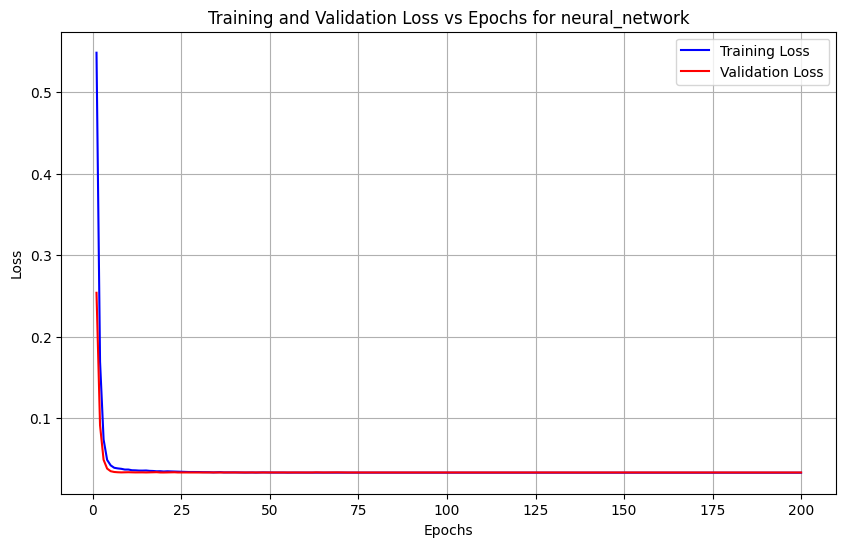

 25%|██▌       | 1/4 [32:13<1:36:40, 1933.55s/it]

Training completed for neural_network in 1933.54 seconds
Starting neural_network training
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.11986, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
Epoch 1: New best weights saved.
Epoch 2/200

Epoch 1: val_loss improved from 0.11986 to 0.04248, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Epoch 1: New best weights saved.
Epoch 3/200

Epoch 1: val_loss improved from 0.04248 to 0.03481, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1: New best weights saved.
Epoch 4/200

Epoch 1: val_loss improved from 0.03481 to 0.03351, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Epoch 1: New best weights saved.
Epoch 5/200

Epoch 1: val_loss improved from 0.03351 to 0.03335, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1: New best weights saved.
Epoch 6/200

Epoch 1: val_loss improved from 0.03335 to 0.

In [ ]:
# Assuming df, train_df, val_df, test_df are defined and contain the necessary columns
# unique_combinations = df[['BasinTC', 'FORMATION_CONDENSED']].drop_duplicates()
#configurations = [
#    {'embedding_output_dim': 20, 'dense_layer_sizes': [256, 128, 64, 32], 'dropout_rate': 0.3, 'regularization': l2(0.01), 'activation': 'relu', 'optimizer': 'adam', 'loss_function': 'mse'},
# {'embedding_output_dim': 20, 'dense_layer_sizes': [256, 128], 'dropout_rate': 0.3, 'regularization': l2(0.01), 'activation': 'relu', 'optimizer': 'adam', 'loss_function': 'mse'}

  #    {'embedding_output_dim': 15, 'dense_layer_sizes': [64, 32], 'dropout_rate': 0.2, 'regularization': l1(0.01), 'activation': 'relu', 'optimizer': 'rmsprop', 'loss_function': 'mse'}
#]
ml_configurations = [
    {'model_type': 'neural_network'},
    # {'model_type': 'random_forest'},
    # {'model_type': 'decision_tree'},
    # {'model_type': 'xgboost'},
    # {'model_type': 'ridge'},
    # {'model_type': 'lasso'},
    # {'model_type': 'multioutput'}
]
# Assuming df, train_df, val_df, test_df are defined and contain the necessary columns
specific_combinations = df[
    (df['BasinTC'] == 'Midland') & 
   (df['FORMATION_CONDENSED'].isin(['LSS', 'WCA', 'WCB', 'JMS']))
   #(df['FORMATION_CONDENSED'].isin(['WCA']))
].drop_duplicates(subset=['BasinTC', 'FORMATION_CONDENSED'])
output_size = len(train_df[y_headers].columns)  # Ensure output_size is defined

# Dictionary to store task times
task_times = {}


models = execute_training(specific_combinations, train_df, val_df, test_df, numerical_columns, categorical_columns, y_headers, output_size, df, task_times)

In [ ]:
# train_df.to_csv('train.csv', index=False)
# val_df.to_csv('val.csv', index=False)
# test_df.to_csv('test.csv', index=False)

In [ ]:
output_size

In [ ]:
# Compute SHAP values
#shap_values_dict = compute_and_log_shap_values(models, test_df, numerical_columns, categorical_columns, shap_sample_size=100)
# Print out the task times to identify slow tasks
print("Task times (in seconds):")
for task, duration in task_times.items():
    print(f"{task}: {duration:.2f} seconds")

In [ ]:
# # Define the variables
# basin = 'Midland'
# #formation = 'WCA'
# formation = ['LSS', 'WCA', 'WCB', 'WCD']
# config_str = "{'embedding_output_dim': 20, 'dense_layer_sizes': [256, 128, 64, 32], 'dropout_rate': 0.3, 'regularization': <keras.src.regularizers.regularizers.L2 object at 0x0000024A7D101640>, 'activation': 'relu', 'optimizer': 'adam', 'loss_function': 'mse'}"
# feature_names = numerical_columns + categorical_columns  # Ensure this list contains all your feature names
# output_pdf = r"C:\Users\Prakhar.Sarkar\OneDrive - SRP Management Services\Documents\_For_Prakhar\shap_summary_plot.pdf"

# # Plot the SHAP values
# plot_shap_values(shap_values_dict, y_headers, feature_names, output_pdf)

In [ ]:
# Function to denormalize numerical data
def denormalize_data_input(data, scaler):
    return scaler.inverse_transform(data)
# Function to denormalize data and revert log transformation
def denormalize_data_output(data, scaler, log_transform_columns):
    denormalized_data = scaler.inverse_transform(data)
    denormalized_df = pd.DataFrame(denormalized_data, columns=scaler.get_feature_names_out())
    denormalized_df[log_transform_columns] = np.expm1(denormalized_df[log_transform_columns])
    if any('BuildupRate' in col for col in log_transform_columns):
        denormalized_df[log_transform_columns] = denormalized_df[log_transform_columns].replace(0, 0)
    return denormalized_df
# Function to decode categorical data
def decode_categorical(data, encoders, column_names):
    decoded_data = {}
    for i, col in enumerate(column_names):
        le = encoders[col]
        decoded_data[col] = le.inverse_transform(data[:, i].astype(int))
    return decoded_data
# Denormalize and decode the training DataFrame
def denormalize_and_decode(train_df, numerical_columns, categorical_columns, y_headers, input_scaler, output_scaler, encoders):
    # Denormalize numerical features
    train_df[numerical_columns] = denormalize_data_input(train_df[numerical_columns], input_scaler)
    #log_transform_columns = [col for col in y_headers if 'BuildupRate' in col or 'InitialProd' in col]
    log_transform_columns = [col for col in y_headers if 'InitialProd' in col]
    # Denormalize target features
    train_df[y_headers] = denormalize_data_output(train_df[y_headers], output_scaler, log_transform_columns)
    # Decode categorical features
    decoded_categorical = decode_categorical(train_df, encoders, categorical_columns)
    for col in categorical_columns:
        train_df[col] = decoded_categorical[col]
    return train_df
# Denormalize and decode the input DataFrame
def denormalize_and_decode_inputs(input_df, numerical_columns, categorical_columns, input_scaler, encoders):
    # Denormalize numerical features
    input_df[numerical_columns] = denormalize_data_input(input_df[numerical_columns], input_scaler)
    
    # Decode categorical features
    decoded_categorical = decode_categorical(input_df[categorical_columns].values, encoders, categorical_columns)
    for col in categorical_columns:
        input_df[col] = decoded_categorical[col]
    
    return input_df

In [ ]:
  
def hyperbolic_decline(t, qi, di, b):
    return qi / ((1 + b * di * t) ** (1/b))

def plot_decline_curves(time, actual, predicted, title):
    plt.figure(figsize=(10, 6))
    
    plt.plot(time, actual, 'b-o', label='Actual')
    plt.plot(time, predicted, 'r--x', label='Predicted')
    plt.yscale('log')
    #plt.ylim(1, 100000)
    plt.title(title)
    plt.xlabel('Time (Years)')
    plt.ylabel('Production Monthly Volumes (bbls/months)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--')
    plt.show()

def generate_production_rates_for_comp(y_pred_denormalized, y_true_denormalized, headers, time, resource_type='Oil'):
    predicted_productions = []
    actual_productions = []

    if resource_type == 'Oil':
        prefix = 'Oil_Params_P50_'
    elif resource_type == 'Gas':
        prefix = 'Gas_Params_P50_'
    elif resource_type == 'Water':
        prefix = 'Water_Params_P50_'
    else:
        raise ValueError("Invalid resource type. Must be 'Oil', 'Gas', or 'Water'.")

    for idx in range(len(y_pred_denormalized)):
        try:
            qi_pred = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}InitialProd')]
            di_pred = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}DiCoefficient')]
            b_pred  = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}BCoefficient')]
            IBU_pred = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}BuildupRate')]
            MBU_pred = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}MonthsInProd')]
            Dlim_pred = 7#y_pred_denormalized.iloc[idx, headers.index(f'{prefix}LimDeclineRate')]
            
            qi_true = y_true_denormalized.iloc[idx, headers.index(f'{prefix}InitialProd')]
            di_true = y_true_denormalized.iloc[idx, headers.index(f'{prefix}DiCoefficient')]
            b_true = y_true_denormalized.iloc[idx, headers.index(f'{prefix}BCoefficient')]
            IBU_true = y_true_denormalized.iloc[idx, headers.index(f'{prefix}BuildupRate')]
            MBU_true = y_true_denormalized.iloc[idx, headers.index(f'{prefix}MonthsInProd')]
            Dlim_true = 7# y_true_denormalized.iloc[idx, headers.index(f'{prefix}LimDeclineRate')]
            
            # Check for NaN values
            if not validate_inputs(qi_pred, di_pred, b_pred, Dlim_pred, IBU_pred, MBU_pred):
                print(f"Skipping invalid prediction inputs at index {idx}: {qi_pred}, {di_pred}, {b_pred}, {Dlim_pred}, {IBU_pred}, {MBU_pred}")
                predicted_productions.append(np.zeros_like(time))
                actual_productions.append(modified_hyperbolic(time, qi_true, di_true, b_true, Dlim_true, IBU_true, MBU_true))
                continue

            predicted_production = modified_hyperbolic(time, qi_pred, di_pred, b_pred, Dlim_pred, IBU_pred, MBU_pred)[1]
            actual_production = modified_hyperbolic(time, qi_true, di_true, b_true, Dlim_true, IBU_true, MBU_true)[1]
            
            if len(predicted_production) == len(time) and len(actual_production) == len(time):
                predicted_productions.append(predicted_production)
                actual_productions.append(actual_production)
            else:
                print(f"Production length mismatch: predicted {len(predicted_production)}, actual {len(actual_production)}")

        except Exception as e:
            print(f"Error generating production rates: {e}")
            predicted_productions.append(np.zeros_like(time))
            actual_productions.append(np.zeros_like(time))

    return predicted_productions, actual_productions

def calculate_errors(predicted_productions, actual_productions):
    errors = {
        'MSE': [],
        'MAE': [],
        'sMAPE': []
    }

    for pred, actual in zip(predicted_productions, actual_productions):
        if len(pred) != len(actual):
            print(f"Length mismatch: predicted {len(pred)}, actual {len(actual)}")
            continue

        if np.any(np.isnan(pred)) or np.any(np.isnan(actual)):
            print(f"NaN values found in predictions or actuals. Skipping this entry.")
            continue

        mse = mean_squared_error(actual, pred)
        mae = mean_absolute_error(actual, pred)
        smape = np.mean(np.abs(pred - actual) / ((np.abs(actual) + np.abs(pred)) / 2)) * 100
        
        errors['MSE'].append(mse)
        errors['MAE'].append(mae)
        errors['sMAPE'].append(smape)

    return errors
# Define a function to determine model type
def determine_model_type(config_str):
    if 'regularization' in config_str or 'dense_layer_sizes' in config_str:
        return 'Neural Network'
    else:
        return config_str.split(' ')[0]
def calculate_scalar_errors(y_pred_denormalized, y_true_denormalized, headers, resource_type='Oil'):
    if resource_type == 'Oil':
        prefix = 'Oil_Params_P50_'
    elif resource_type == 'Gas':
        prefix = 'Gas_Params_P50_'
    elif resource_type == 'Water':
        prefix = 'Water_Params_P50_'
    else:
        raise ValueError("Invalid resource type. Must be 'Oil', 'Gas', or 'Water'.")

    scalar_errors = {
        'InitialProd_MAE': [],
        'DiCoefficient_MAE': [],
        'BCoefficient_MAE': [],
        'BuildupRate_MAE': [],
        'MonthsInProd_MAE': [],
        'LimDeclineRate_MAE': [],
        'InitialProd_RMSE': [],
        'DiCoefficient_RMSE': [],
        'BCoefficient_RMSE': [],
        'BuildupRate_RMSE': [],
        'MonthsInProd_RMSE': [],
        'LimDeclineRate_RMSE': []
    }

    for idx in range(len(y_pred_denormalized)):
        try:
            qi_pred = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}InitialProd')]
            di_pred = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}DiCoefficient')]
            b_pred  = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}BCoefficient')]
            IBU_pred = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}BuildupRate')]
            MBU_pred = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}MonthsInProd')]
            Dlim_pred =7# y_pred_denormalized.iloc[idx, headers.index(f'{prefix}LimDeclineRate')]
            
            qi_true = y_true_denormalized.iloc[idx, headers.index(f'{prefix}InitialProd')]
            di_true = y_true_denormalized.iloc[idx, headers.index(f'{prefix}DiCoefficient')]
            b_true = y_true_denormalized.iloc[idx, headers.index(f'{prefix}BCoefficient')]
            IBU_true = y_true_denormalized.iloc[idx, headers.index(f'{prefix}BuildupRate')]
            MBU_true = y_true_denormalized.iloc[idx, headers.index(f'{prefix}MonthsInProd')]
            Dlim_true = 7#y_true_denormalized.iloc[idx, headers.index(f'{prefix}LimDeclineRate')]

            scalar_errors['InitialProd_MAE'].append(np.abs(qi_pred - qi_true))
            scalar_errors['DiCoefficient_MAE'].append(np.abs(di_pred - di_true))
            scalar_errors['BCoefficient_MAE'].append(np.abs(b_pred - b_true))
            scalar_errors['BuildupRate_MAE'].append(np.abs(IBU_pred - IBU_true))
            scalar_errors['MonthsInProd_MAE'].append(np.abs(MBU_pred - MBU_true))
            scalar_errors['LimDeclineRate_MAE'].append(np.abs(Dlim_pred - Dlim_true))

            scalar_errors['InitialProd_RMSE'].append((qi_pred - qi_true) ** 2)
            scalar_errors['DiCoefficient_RMSE'].append((di_pred - di_true) ** 2)
            scalar_errors['BCoefficient_RMSE'].append((b_pred - b_true) ** 2)
            scalar_errors['BuildupRate_RMSE'].append((IBU_pred - IBU_true) ** 2)
            scalar_errors['MonthsInProd_RMSE'].append((MBU_pred - MBU_true) ** 2)
            scalar_errors['LimDeclineRate_RMSE'].append((Dlim_pred - Dlim_true) ** 2)

        except Exception as e:
            print(f"Error calculating scalar errors: {e}")
            continue

    # Calculate mean values
    for key in scalar_errors.keys():
        scalar_errors[key] = np.mean(scalar_errors[key]) if len(scalar_errors[key]) > 0 else np.nan

    # Convert RMSE values
    for key in list(scalar_errors.keys()):
        if key.endswith('_RMSE'):
            scalar_errors[key] = np.sqrt(scalar_errors[key])

    return scalar_errors
    
def identify_best_worst_matches(errors, y_true_denormalized, y_pred_denormalized, error_metric='MSE'):
    # Ensure the errors dictionary contains the chosen error metric
    if error_metric not in errors:
        raise ValueError(f"Error metric '{error_metric}' not found in errors.")
    
    # Use the selected error metric to find the best and worst matches
    best_match_idx = np.argmin(errors[error_metric])
    worst_match_idx = np.argmax(errors[error_metric])

    best_match_true = y_true_denormalized.iloc[best_match_idx]
    best_match_pred = y_pred_denormalized.iloc[best_match_idx]

    worst_match_true = y_true_denormalized.iloc[worst_match_idx]
    worst_match_pred = y_pred_denormalized.iloc[worst_match_idx]

    return best_match_true, best_match_pred, worst_match_true, worst_match_pred, best_match_idx, worst_match_idx

# Function to print performance metrics in a readable format
def print_performance_metrics(basin, formation, config_str, model_type, mse, mae, smape, scalar_errors):
    metrics = (
        f"Performance for Basin: {basin}\n"
        f"Formation: {formation}\n"
        f"Config: {model_type}\n"
        f"MSE: {mse:.4f}\n"
        f"MAE: {mae:.4f}\n"
        f"sMAPE: {smape:.2f}%\n"
        "Scalar Errors:\n"
        f"InitialProd_MAE: {scalar_errors['InitialProd_MAE']:.4f}\n"
        f"DiCoefficient_MAE: {scalar_errors['DiCoefficient_MAE']:.4f}\n"
        f"BCoefficient_MAE: {scalar_errors['BCoefficient_MAE']:.4f}\n"
        f"BuildupRate_MAE: {scalar_errors['BuildupRate_MAE']:.4f}\n"
        f"MonthsInProd_MAE: {scalar_errors['MonthsInProd_MAE']:.4f}\n"
        f"LimDeclineRate_MAE: {scalar_errors['LimDeclineRate_MAE']:.4f}\n"
        f"InitialProd_RMSE: {scalar_errors['InitialProd_RMSE']:.4f}\n"
        f"DiCoefficient_RMSE: {scalar_errors['DiCoefficient_RMSE']:.4f}\n"
        f"BCoefficient_RMSE: {scalar_errors['BCoefficient_RMSE']:.4f}\n"
        f"BuildupRate_RMSE: {scalar_errors['BuildupRate_RMSE']:.4f}\n"
        f"MonthsInProd_RMSE: {scalar_errors['MonthsInProd_RMSE']:.4f}\n"
        f"LimDeclineRate_RMSE: {scalar_errors['LimDeclineRate_RMSE']:.4f}\n"
    )
    return metrics

# Function to save plots and performance metrics in a PDF file
def save_plots_to_pdf(plot_data, performance_data, output_path):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    
    for i, (basin, formation, config_str, time, best_match_true, best_match_pred, worst_match_true, worst_match_pred, best_match_idx, worst_match_idx) in enumerate(plot_data):
        model_type = determine_model_type(config_str)
        
        # Add a page for each model
        pdf.add_page()
        pdf.set_font("Arial", size=12)
        
        # Add the performance metrics
        metrics = performance_data[(basin, formation, config_str)]
        metrics_text = print_performance_metrics(
            basin, formation, config_str, model_type, 
            metrics['MSE'], metrics['MAE'], metrics['sMAPE'], metrics
        )
        # Add bold, underlined, and red text
        pdf.set_text_color(255, 0, 0)  # Red color
        pdf.set_font("Arial", style='BU', size=12)  # Bold and Underlined
        pdf.multi_cell(0, 10, f"Performance for Basin: {basin}\nFormation: {formation}\nConfig: {model_type}\n")

        # Reset to regular font for the rest of the text
        pdf.set_text_color(0, 0, 0)  # Black color
        pdf.set_font("Arial", size=12)
        pdf.multi_cell(0, 10, metrics_text)

        # Ensure lengths match
        min_length = min(len(time), len(best_match_true), len(best_match_pred), len(worst_match_true), len(worst_match_pred))
        time = time[:min_length]
        best_match_true = best_match_true[:min_length]
        best_match_pred = best_match_pred[:min_length]
        worst_match_true = worst_match_true[:min_length]
        worst_match_pred = worst_match_pred[:min_length]

        # Save the plots as images
        best_plot_path = f"best_plot_{i}.png"
        worst_plot_path = f"worst_plot_{i}.png"
        
        # Generate and save best plot
        fig, ax = plt.subplots(figsize=(7, 5))
        ax.plot(time, best_match_true, 'b-o', label='Actual')
        ax.plot(time, best_match_pred, 'r--x', label='Predicted')
        ax.set_yscale('log')
        #ax.set_ylim(1, 100000)
        ax.set_title(f'Best Match - {model_type}', fontsize=16, fontweight='bold')
        ax.set_xlabel('Time (Months)')
        ax.set_ylabel('Production Rate (bbl/day)')
        ax.legend()
        ax.grid(True, which='both', linestyle='--')
        plt.tight_layout()
        plt.savefig(best_plot_path)
        plt.close()

        # Generate and save worst plot
        fig, ax = plt.subplots(figsize=(7, 5))
        ax.plot(time, worst_match_true, 'b-o', label='Actual')
        ax.plot(time, worst_match_pred, 'r--x', label='Predicted')
        ax.set_yscale('log')
        #ax.set_ylim(1, 100000)
        ax.set_title(f'Worst Match - {model_type}', fontsize=16, fontweight='bold')
        ax.set_xlabel('Time (Months)')
        ax.set_ylabel('Production Rate (bbl/day)')
        ax.legend()
        ax.grid(True, which='both', linestyle='--')
        plt.tight_layout()
        plt.savefig(worst_plot_path)
        plt.close()

        # Debug statements to check if images exist
        if os.path.exists(best_plot_path):
            print(f"Best plot saved successfully at {best_plot_path}")
        else:
            print(f"Failed to save best plot at {best_plot_path}")

        if os.path.exists(worst_plot_path):
            print(f"Worst plot saved successfully at {worst_plot_path}")
        else:
            print(f"Failed to save worst plot at {worst_plot_path}")

        # Add images to PDF
        pdf.image(best_plot_path, x=10, y=pdf.get_y(), w=90)
        pdf.image(worst_plot_path, x=110, y=pdf.get_y(), w=90)

        # Remove the temporary plot images
        os.remove(best_plot_path)
        os.remove(worst_plot_path)
    
    pdf.output(output_path)
    print(f"PDF saved to {output_path}")

In [ ]:
# Define the prediction function
#@tf.function(reduce_retracing=True)
def predict_with_model(model, numerical_data, categorical_data):
    if isinstance(model, Model):  # Keras model
        return model.predict([numerical_data] + categorical_data)
    else:  # Sklearn model
        import pandas as pd
        data_combined = np.hstack([numerical_data] + categorical_data)
        combined_df = pd.DataFrame(data_combined, columns=numerical_columns + categorical_columns)
        return model.predict(combined_df)

In [ ]:
# Evaluate the models
years = 20
time = np.linspace(1, 12 * years, 12 * years)  # 5 Years
time_array=time

# Use the function to create and save the PDF file
output_pdf_path = f'C:/Users/Prakhar.Sarkar/OneDrive - SRP Management Services/Documents/_For_Prakhar/model_performance_withHL.pdf'

evaluation_results = {}
best_performing_models = {}
plot_data = []
performance_data = {}  # Store the performance metrics for each model configuration

for (basin, formation, config_str), model in models.items():
    # Filter the test data for the specific basin and formation
    combo_test = filter_by_basin_and_formation(test_df, basin, formation)
    
    # Extract numerical and categorical data from the filtered test set
    numerical_data = combo_test[numerical_columns].values
    categorical_data = [combo_test[col].astype(int).values.reshape(-1, 1) for col in categorical_columns]
    
    # Prepare the target values (y_true)
    y_true = combo_test[y_headers].values  # Use entire y_headers as output

    # Predict outputs using the model
    y_pred = predict_with_model(model, numerical_data, categorical_data)

    # Denormalize predictions and actual values
    y_pred_denormalized = denormalize_data_output(y_pred, output_scaler, log_transform_columns)
    y_true_denormalized = denormalize_data_output(y_true, output_scaler, log_transform_columns)

    # Check for NaN or infinite values
    if np.any(np.isnan(y_pred_denormalized)) or np.any(np.isinf(y_pred_denormalized)):
        print(f"NaN or infinite values found in predictions for {basin} - {formation} with config {config_str}")
        continue
    
    # Generate production rates
    predicted_productions, actual_productions = generate_production_rates_for_comp(y_pred_denormalized, y_true_denormalized, y_headers, time)
    #print(predicted_productions)

    # Calculate errors
    errors = calculate_errors(predicted_productions, actual_productions)
    scalar_errors = calculate_scalar_errors(y_pred_denormalized, y_true_denormalized, y_headers)

    # Identify best and worst matches
    best_match_true, best_match_pred, worst_match_true, worst_match_pred, best_match_idx, worst_match_idx = identify_best_worst_matches(errors, y_true_denormalized, y_pred_denormalized)

    # Plot the best match
    best_actual_production = actual_productions[best_match_idx]
    best_predicted_production = predicted_productions[best_match_idx]
    plot_decline_curves(time_array, best_actual_production, best_predicted_production, f'Best Match Hyperbolic Decline Curve for {basin} - {formation}')

    # Plot the worst match
    worst_actual_production = actual_productions[worst_match_idx]
    worst_predicted_production = predicted_productions[worst_match_idx]
    plot_decline_curves(time_array, worst_actual_production, worst_predicted_production, f'Worst Match Hyperbolic Decline Curve for {basin} - {formation}')

        # Save performance metrics
    if y_true_denormalized.shape == y_pred_denormalized.shape:
        mse = mean_squared_error(y_true_denormalized, y_pred_denormalized)
        mae = mean_absolute_error(y_true_denormalized, y_pred_denormalized)
        smape = np.mean(np.abs(y_pred_denormalized - y_true_denormalized) / ((np.abs(y_true_denormalized) + np.abs(y_pred_denormalized)) / 2)) * 100
        performance_data[(basin, formation, config_str)] = {'MSE': mse, 'MAE': mae, 'sMAPE': smape, **scalar_errors}
        print(f"Performance for Basin: {basin}, Formation: {formation}, Config: {config_str} - MSE: {mse:.4f}, MAE: {mae:.4f}, sMAPE: {smape:.2f}% - Scalar Errors: {scalar_errors}")
        
        # Update best performing model
        if (basin, formation) not in best_performing_models or mse < best_performing_models[(basin, formation)]['MSE']:
            best_performing_models[(basin, formation)] = {'MSE': mse, 'MAE': mae, 'sMAPE': smape, **scalar_errors, 'config_str': config_str, 'model': model}
    else:
        print(f"Shape mismatch between y_true {y_true_denormalized.shape} and y_pred {y_pred_denormalized.shape}, check data preparation steps.")

    plot_data.append((basin, formation, config_str, time, best_actual_production, best_predicted_production, worst_actual_production, worst_predicted_production, best_match_idx, worst_match_idx))

# Print the best performing model for each basin and formation
for (basin, formation), best_model_info in best_performing_models.items():
    model_type = determine_model_type(best_model_info['config_str'])
    print(f"Best Performing Model for Basin: {basin}, Formation: {formation} - Config: {model_type} - MSE: {best_model_info['MSE']:.4f}, MAE: {best_model_info['MAE']:.4f}, sMAPE: {best_model_info['sMAPE']:.2f}% - Scalar Errors: {best_model_info}")

# Save plots and performance metrics in a PDF file
save_plots_to_pdf(plot_data, performance_data, output_pdf_path)

In [ ]:
# Function to adjust the length of time and data arrays
def adjust_length(time, data):
    if len(time) > len(data):
        time = time[:len(data)]
    else:
        data = data[:len(time)]
    return time, data

# Function to create and save individual plots
def create_individual_plots(data):
    for i, (basin, formation, config_str, time, best_match_true, best_match_pred, worst_match_true, worst_match_pred, best_match_idx, worst_match_idx) in enumerate(data):
        if 'regularization' in config_str or 'dense_layer_sizes' in config_str:
            model_type = 'Neural Network'
        else:
            model_type = config_str.split(' ')[0]
        
        # Check for valid data before plotting
        if len(best_match_true) == 0 or len(best_match_pred) == 0 or len(worst_match_true) == 0 or len(worst_match_pred) == 0:
            continue
        
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        
        # Adjust lengths of time and data
        time_best_true, best_match_true = adjust_length(time, best_match_true)
        time_best_pred, best_match_pred = adjust_length(time, best_match_pred)
        time_worst_true, worst_match_true = adjust_length(time, worst_match_true)
        time_worst_pred, worst_match_pred = adjust_length(time, worst_match_pred)
        
        # Plot best match
        axs[0].plot(time_best_true, best_match_true, 'b-o', label='Actual')
        axs[0].plot(time_best_pred, best_match_pred, 'r--x', label='Predicted')
        axs[0].set_yscale('log')
        #axs[0].set_ylim(1, 100000)
        axs[0].set_title(f'{basin}-{formation} ({model_type})', fontsize=16, fontweight='bold')
        axs[0].set_xlabel('Time (Months)')
        axs[0].set_ylabel('Production Rate (bbl/day)')
        axs[0].legend()
        axs[0].grid(True, which='both', linestyle='--')
        
        # Plot worst match
        axs[1].plot(time_worst_true, worst_match_true, 'b-o', label='Actual')
        axs[1].plot(time_worst_pred, worst_match_pred, 'r--x', label='Predicted')
        axs[1].set_yscale('log')
        #axs[1].set_ylim(1, 100000)
        axs[1].set_title(f'{basin}-{formation} ({model_type})', fontsize=16, fontweight='bold')
        axs[1].set_xlabel('Time (Months)')
        axs[1].set_ylabel('Production Rate (bbl/day)')
        axs[1].legend()
        axs[1].grid(True, which='both', linestyle='--')
        
        # Save the plot
        plt.tight_layout()
        plt.savefig(f'C:/Users/Prakhar.Sarkar/OneDrive - SRP Management Services/Documents/_For_Prakhar/plot_{i}_withHL.jpeg')
        plt.close()

# Function to create and save grid plots with adjusted lengths
def create_grid_plot(data):
    formations = set(item[1] for item in data)
    
    for formation in formations:
        formation_data = [item for item in data if item[1] == formation]
        valid_data = [item for item in formation_data if len(item[4]) > 0 or len(item[5]) > 0 or len(item[6]) > 0 or len(item[7]) > 0]
        
        if not valid_data:
            continue
        
        num_methods = len(valid_data)
        num_cols = num_methods
        num_rows = 2
        
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 12))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        # Ensure axs is always a 2D array
        if num_cols == 1:
            axs = np.array([axs]).T

        for i, (basin, formation, config_str, time, best_match_true, best_match_pred, worst_match_true, worst_match_pred, best_match_idx, worst_match_idx) in enumerate(valid_data):
            if 'regularization' in config_str or 'dense_layer_sizes' in config_str:
                model_type = 'Neural Network'
            else:
                model_type = config_str.split(' ')[0]
            
            col = i
            
            # Adjust lengths of time and data
            time_best_true, best_match_true = adjust_length(time, best_match_true)
            time_best_pred, best_match_pred = adjust_length(time, best_match_pred)
            time_worst_true, worst_match_true = adjust_length(time, worst_match_true)
            time_worst_pred, worst_match_pred = adjust_length(time, worst_match_pred)
            
            # Plot best match
            if len(best_match_true) > 0 and len(best_match_pred) > 0:
                axs[0, col].plot(time_best_true, best_match_true, 'b-o', label='Actual')
                axs[0, col].plot(time_best_pred, best_match_pred, 'r--x', label='Predicted')
                axs[0, col].set_yscale('log')
                #axs[0, col].set_ylim(1, 100000)
                axs[0, col].set_title(f'Best Match - {model_type}', fontsize=16, fontweight='bold')
                axs[0, col].set_xlabel('Time (Months)')
                axs[0, col].set_ylabel('Production Rate (bbl/day)')
                axs[0, col].legend()
                axs[0, col].grid(True, which='both', linestyle='--')
            # else:
            #     axs[0, col].axis('off')
            
            # Plot worst match on the next row
            if len(worst_match_true) > 0 and len(worst_match_pred) > 0:
                axs[1, col].plot(time_worst_true, worst_match_true, 'b-o', label='Actual')
                axs[1, col].plot(time_worst_pred, worst_match_pred, 'r--x', label='Predicted')
                axs[1, col].set_yscale('log')
                #axs[1, col].set_ylim(1, 100000)
                axs[1, col].set_title(f'Worst Match - {model_type}', fontsize=16, fontweight='bold')
                axs[1, col].set_xlabel('Time (Months)')
                axs[1, col].set_ylabel('Production Rate (bbl/day)')
                axs[1, col].legend()
                axs[1, col].grid(True, which='both', linestyle='--')
            # else:
            #     axs[1, col].axis('off')
        
        # # Turn off any unused subplots
        # for j in range(i + 1, num_rows * num_cols):
        #     row = j // num_cols
        #     col = j % num_cols
        #     axs[row, col].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'C:/Users/Prakhar.Sarkar/OneDrive - SRP Management Services/Documents/_For_Prakhar/grid_plot_{formation}_withHL.jpeg')
        plt.close()

# Create and save individual plots
create_individual_plots(plot_data) 
# Create and save grid plots
create_grid_plot(plot_data)

In [ ]:
# Evaluate the models
years = 20
time = np.linspace(1, 12 * years, 12 * years)  # 5 Years

# Use the function to create and save the PDF file
output_pdf_path = f'C:/Users/Prakhar.Sarkar/OneDrive - SRP Management Services/Documents/_For_Prakhar/model_performance_gas_withHL.pdf'

evaluation_results = {}
best_performing_models = {}
plot_data_gas = []
performance_data = {}  # Store the performance metrics for each model configuration

for (basin, formation, config_str), model in models.items():
    # Filter the test data for the specific basin and formation
    combo_test = filter_by_basin_and_formation(test_df, basin, formation)
    
    # Extract numerical and categorical data from the filtered test set
    numerical_data = combo_test[numerical_columns].values
    categorical_data = [combo_test[col].astype(int).values.reshape(-1, 1) for col in categorical_columns]
    
    # Prepare the target values (y_true)
    y_true = combo_test[y_headers].values  # Use entire y_headers as output

    # Predict outputs using the model
    y_pred = predict_with_model(model, numerical_data, categorical_data)

    # Denormalize predictions and actual values
    y_pred_denormalized = denormalize_data_output(y_pred, output_scaler, log_transform_columns)
    y_true_denormalized = denormalize_data_output(y_true, output_scaler, log_transform_columns)

    # Check for NaN or infinite values
    if np.any(np.isnan(y_pred_denormalized)) or np.any(np.isinf(y_pred_denormalized)):
        print(f"NaN or infinite values found in predictions for {basin} - {formation} with config {config_str}")
        continue
    
    # Generate production rates
    predicted_productions, actual_productions = generate_production_rates_for_comp(y_pred_denormalized, y_true_denormalized, y_headers, time,resource_type='Gas')

    # Calculate errors
    errors = calculate_errors(predicted_productions, actual_productions)
    scalar_errors = calculate_scalar_errors(y_pred_denormalized, y_true_denormalized, y_headers,resource_type='Gas')

    # Identify best and worst matches
    best_match_true, best_match_pred, worst_match_true, worst_match_pred, best_match_idx, worst_match_idx = identify_best_worst_matches(errors, y_true_denormalized, y_pred_denormalized)

    # Plot the best match
    best_actual_production = actual_productions[best_match_idx]
    best_predicted_production = predicted_productions[best_match_idx]
    plot_decline_curves(time_array, best_actual_production, best_predicted_production, f'Best Match Hyperbolic Decline Curve for {basin} - {formation}')

    # Plot the worst match
    worst_actual_production = actual_productions[worst_match_idx]
    worst_predicted_production = predicted_productions[worst_match_idx]
    plot_decline_curves(time_array, worst_actual_production, worst_predicted_production, f'Worst Match Hyperbolic Decline Curve for {basin} - {formation}')

        # Save performance metrics
    if y_true_denormalized.shape == y_pred_denormalized.shape:
        mse = mean_squared_error(y_true_denormalized, y_pred_denormalized)
        mae = mean_absolute_error(y_true_denormalized, y_pred_denormalized)
        smape = np.mean(np.abs(y_pred_denormalized - y_true_denormalized) / ((np.abs(y_true_denormalized) + np.abs(y_pred_denormalized)) / 2)) * 100
        performance_data[(basin, formation, config_str)] = {'MSE': mse, 'MAE': mae, 'sMAPE': smape, **scalar_errors}
        print(f"Performance for Basin: {basin}, Formation: {formation}, Config: {config_str} - MSE: {mse:.4f}, MAE: {mae:.4f}, sMAPE: {smape:.2f}% - Scalar Errors: {scalar_errors}")
        
        # Update best performing model
        if (basin, formation) not in best_performing_models or mse < best_performing_models[(basin, formation)]['MSE']:
            best_performing_models[(basin, formation)] = {'MSE': mse, 'MAE': mae, 'sMAPE': smape, **scalar_errors, 'config_str': config_str, 'model': model}
    else:
        print(f"Shape mismatch between y_true {y_true_denormalized.shape} and y_pred {y_pred_denormalized.shape}, check data preparation steps.")

    plot_data_gas.append((basin, formation, config_str, time, best_actual_production, best_predicted_production, worst_actual_production, worst_predicted_production, best_match_idx, worst_match_idx))

# Print the best performing model for each basin and formation
for (basin, formation), best_model_info in best_performing_models.items():
    model_type = determine_model_type(best_model_info['config_str'])
    print(f"Best Performing Model for Basin: {basin}, Formation: {formation} - Config: {model_type} - MSE: {best_model_info['MSE']:.4f}, MAE: {best_model_info['MAE']:.4f}, sMAPE: {best_model_info['sMAPE']:.2f}% - Scalar Errors: {best_model_info}")

# Save plots and performance metrics in a PDF file
save_plots_to_pdf(plot_data_gas, performance_data, output_pdf_path)
# Create and save individual plots
create_individual_plots(plot_data_gas) 
# Create and save grid plots
create_grid_plot(plot_data_gas)

In [ ]:
# Evaluate the models
years = 20
time = np.linspace(1, 12 * years, 12 * years)  # 5 Years

# Use the function to create and save the PDF file
output_pdf_path = f'C:/Users/Prakhar.Sarkar/OneDrive - SRP Management Services/Documents/_For_Prakhar/model_performance_water_withHL.pdf'

evaluation_results = {}
best_performing_models = {}
plot_data_water = []
performance_data = {}  # Store the performance metrics for each model configuration

for (basin, formation, config_str), model in models.items():
    # Filter the test data for the specific basin and formation
    combo_test = filter_by_basin_and_formation(test_df, basin, formation)
    
    # Extract numerical and categorical data from the filtered test set
    numerical_data = combo_test[numerical_columns].values
    categorical_data = [combo_test[col].astype(int).values.reshape(-1, 1) for col in categorical_columns]
    
    # Prepare the target values (y_true)
    y_true = combo_test[y_headers].values  # Use entire y_headers as output

    # Predict outputs using the model
    y_pred = predict_with_model(model, numerical_data, categorical_data)

    # Denormalize predictions and actual values
    y_pred_denormalized = denormalize_data_output(y_pred, output_scaler, log_transform_columns)
    y_true_denormalized = denormalize_data_output(y_true, output_scaler, log_transform_columns)

    # Check for NaN or infinite values
    if np.any(np.isnan(y_pred_denormalized)) or np.any(np.isinf(y_pred_denormalized)):
        print(f"NaN or infinite values found in predictions for {basin} - {formation} with config {config_str}")
        continue
    
    # Generate production rates
    predicted_productions, actual_productions = generate_production_rates_for_comp(y_pred_denormalized, y_true_denormalized, y_headers, time,resource_type='Water')

    # Calculate errors
    errors = calculate_errors(predicted_productions, actual_productions)
    scalar_errors = calculate_scalar_errors(y_pred_denormalized, y_true_denormalized, y_headers,resource_type='Water')

    # Identify best and worst matches
    best_match_true, best_match_pred, worst_match_true, worst_match_pred, best_match_idx, worst_match_idx = identify_best_worst_matches(errors, y_true_denormalized, y_pred_denormalized)

    # Plot the best match
    best_actual_production = actual_productions[best_match_idx]
    best_predicted_production = predicted_productions[best_match_idx]
    plot_decline_curves(time_array, best_actual_production, best_predicted_production, f'Best Match Hyperbolic Decline Curve for {basin} - {formation}')

    # Plot the worst match
    worst_actual_production = actual_productions[worst_match_idx]
    worst_predicted_production = predicted_productions[worst_match_idx]
    plot_decline_curves(time_array, worst_actual_production, worst_predicted_production, f'Worst Match Hyperbolic Decline Curve for {basin} - {formation}')

        # Save performance metrics
    if y_true_denormalized.shape == y_pred_denormalized.shape:
        mse = mean_squared_error(y_true_denormalized, y_pred_denormalized)
        mae = mean_absolute_error(y_true_denormalized, y_pred_denormalized)
        smape = np.mean(np.abs(y_pred_denormalized - y_true_denormalized) / ((np.abs(y_true_denormalized) + np.abs(y_pred_denormalized)) / 2)) * 100
        performance_data[(basin, formation, config_str)] = {'MSE': mse, 'MAE': mae, 'sMAPE': smape, **scalar_errors}
        print(f"Performance for Basin: {basin}, Formation: {formation}, Config: {config_str} - MSE: {mse:.4f}, MAE: {mae:.4f}, sMAPE: {smape:.2f}% - Scalar Errors: {scalar_errors}")
        
        # Update best performing model
        if (basin, formation) not in best_performing_models or mse < best_performing_models[(basin, formation)]['MSE']:
            best_performing_models[(basin, formation)] = {'MSE': mse, 'MAE': mae, 'sMAPE': smape, **scalar_errors, 'config_str': config_str, 'model': model}
    else:
        print(f"Shape mismatch between y_true {y_true_denormalized.shape} and y_pred {y_pred_denormalized.shape}, check data preparation steps.")

    plot_data_water.append((basin, formation, config_str, time, best_actual_production, best_predicted_production, worst_actual_production, worst_predicted_production, best_match_idx, worst_match_idx))

# Print the best performing model for each basin and formation
for (basin, formation), best_model_info in best_performing_models.items():
    model_type = determine_model_type(best_model_info['config_str'])
    print(f"Best Performing Model for Basin: {basin}, Formation: {formation} - Config: {model_type} - MSE: {best_model_info['MSE']:.4f}, MAE: {best_model_info['MAE']:.4f}, sMAPE: {best_model_info['sMAPE']:.2f}% - Scalar Errors: {best_model_info}")

# Save plots and performance metrics in a PDF file
save_plots_to_pdf(plot_data_water, performance_data, output_pdf_path)
# Create and save individual plots
create_individual_plots(plot_data_water) 
# Create and save grid plots
create_grid_plot(plot_data_water)

In [ ]:
def combine_data(numerical_data, categorical_data):
    if categorical_data:  # Check if categorical_data is not empty
        categorical_data_combined = np.hstack([cat for cat in categorical_data])
        combined_data = np.hstack((numerical_data, categorical_data_combined))
    else:
        combined_data = numerical_data
    return combined_data

def sensitivity_analysis(cov_matrix, model, numerical_columns, categorical_columns, combo_val, time, y_headers, y_true_denormalized, y_pred_denormalized, output_scaler, log_transform_columns):
    combined_val_data = combine_data(combo_val[numerical_columns].values, 
                                     [combo_val[col].astype(int).values.reshape(-1, 1) for col in categorical_columns])
    sensitivities = []
    feature_names = numerical_columns + categorical_columns

    # Debugging: Print the shape of combined_val_data
    print(f"Shape of combined_val_data: {combined_val_data.shape}")

    for i, feature in enumerate(feature_names):
        perturbed_data = combined_val_data.copy()
        perturbed_data[:, i] += np.sqrt(cov_matrix[i, i])  # Perturb by one standard deviation

        # Predict using the model
        perturbed_numerical_data = perturbed_data[:, :len(numerical_columns)]
        perturbed_categorical_data = [perturbed_data[:, len(numerical_columns) + j].reshape(-1, 1) for j in range(len(categorical_columns))]
        y_pred_perturbed = predict_with_model(model, perturbed_numerical_data, perturbed_categorical_data)

        # Denormalize the predictions
        y_pred_perturbed_denormalized = denormalize_data_output(y_pred_perturbed, output_scaler, log_transform_columns)
        
        # Generate production rates
        predicted_productions_perturbed, _ = generate_production_rates_for_comp(y_pred_perturbed_denormalized, y_true_denormalized, y_headers, time)

        # Calculate mean sensitivity (change in production rate)
        mean_sensitivity = np.mean(np.abs(np.array(predicted_productions_perturbed) - np.array(predicted_productions)), axis=0)
        sensitivities.append(mean_sensitivity)

    return sensitivities, feature_names

def plot_sensitivity_analysis(sensitivities, feature_names):
    plt.figure(figsize=(12, 6))
    plt.barh(feature_names, sensitivities)
    plt.xlabel('Mean Sensitivity')
    plt.ylabel('Input Features')
    plt.title('Sensitivity Analysis of Predicted Production Rates vs Input Features')
    plt.grid(True)
    plt.show()

In [ ]:
# Directory to save individual plots
output_dir = 'C:/Users/Prakhar.Sarkar/OneDrive - SRP Management Services/Documents/_For_Prakhar/covarianceplots_withHL/plots'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
plots_by_combination = {}

for (basin, formation, config_str), model in models.items():
    # Check if config_str indicates a neural network configuration
    if 'embedding_output_dim' in config_str or 'dense_layer_sizes' in config_str:
        model_type = 'Neural Network'
    else:
        model_type = config_str.split(' ')[0]  # Use the first part of the config_str as the model type

    combo_test = filter_by_basin_and_formation(test_df, basin, formation)
    numerical_data = combo_test[numerical_columns].values
    categorical_data = [combo_test[col].astype(int).values.reshape(-1, 1) for col in categorical_columns]
    y_true = combo_test[y_headers].values

    y_pred = predict_with_model(model, numerical_data, categorical_data)
    y_pred_denormalized = denormalize_data_output(y_pred, output_scaler, log_transform_columns)
    y_true_denormalized = denormalize_data_output(y_true, output_scaler, log_transform_columns)

    years = 5
    time_array = np.linspace(1, 12 * years, 12 * years)  # 5 Years

    # Generate production rates for each sample
    predicted_productions_list = []
    for i in range(y_pred_denormalized.shape[0]):
        qi_pred = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_InitialProd')]
        di_pred = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_DiCoefficient')]
        b_pred  = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_BCoefficient')]
        IBU_pred = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_BuildupRate')]
        MBU_pred = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_MonthsInProd')]
        Dlim_pred = 7#y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_LimDeclineRate')]
        predicted_production = modified_hyperbolic(time_array, qi_pred, di_pred, b_pred, Dlim_pred, IBU_pred, MBU_pred)[1]
        predicted_productions_list.append(predicted_production)

    predicted_productions_flat = np.array(predicted_productions_list).flatten()

    # Check if categorical columns are empty
    if categorical_columns:
        categorical_dummies = pd.get_dummies(combo_test[categorical_columns], drop_first=True)
        all_features = pd.concat([combo_test[numerical_columns], categorical_dummies], axis=1)
    else:
        all_features = combo_test[numerical_columns]

    # Repeat features to match the length of flattened predicted productions
    repeated_features = np.repeat(all_features.values, len(time_array), axis=0)

    # Ensure the repeated_features array matches the size of the predicted production rates
    if len(repeated_features) != len(predicted_productions_flat):
        raise ValueError(f"Feature DataFrame and predicted productions have different lengths: {len(repeated_features)} vs {len(predicted_productions_flat)}")

    # Calculate covariance
    cov_matrix = np.cov(repeated_features.T, predicted_productions_flat)
    feature_names = all_features.columns
    sensitivity = cov_matrix[:-1, -1]

    # Create a separate figure for each combination
    plt.figure(figsize=(14, 20))
    sns.barplot(x=sensitivity, y=feature_names)
    plt.title(f'{basin}-{formation} ({model_type})', fontsize=16, fontweight='bold')
    plt.xlabel('Covariance', fontsize=12, fontname='Arial')
    plt.ylabel('Input Features', fontsize=14, fontweight='bold', fontname='Arial')
    plt.xticks(fontsize=10, fontname='Arial')
    plt.yticks(fontsize=10, fontname='Arial')
    plt.tight_layout()
    
    # Save the plot
    plot_filename = os.path.join(output_dir, f'{basin}_{formation}_{model_type}.jpeg')
    plt.savefig(plot_filename, format='jpeg',dpi=(500))
    plt.close()
    
    # Store plot filename for grid organization
    if (basin, formation) not in plots_by_combination:
        plots_by_combination[(basin, formation)] = []
    plots_by_combination[(basin, formation)].append(plot_filename)

In [ ]:
# Directory to save individual plots
output_dir = 'C:/Users/Prakhar.Sarkar/OneDrive - SRP Management Services/Documents/_For_Prakhar/EURcovarianceplots_withHL'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def cumulative_production_and_EUR(qi, di, b, Dlim, IBU, MBU, years=30, buildup_method='Linear'):
    months = np.linspace(0, years * 12, years * 12 + 1)
    production = modified_hyperbolic(months, qi, di, b, Dlim, IBU, MBU, buildup_method)[0]
    cumulative_production = np.cumsum(production)
    EUR = cumulative_production[-1]
    return cumulative_production, EUR

def generate_EUR_predictions(models, test_df, numerical_columns, categorical_columns, output_scaler, log_transform_columns):
    EUR_predictions = {}
    for (basin, formation, config_str), model in models.items():
        combo_test = filter_by_basin_and_formation(test_df, basin, formation)
        numerical_data = combo_test[numerical_columns].values
        categorical_data = [combo_test[col].astype(int).values.reshape(-1, 1) for col in categorical_columns]
        y_true = combo_test[y_headers].values

        y_pred = predict_with_model(model, numerical_data, categorical_data)
        y_pred_denormalized = denormalize_data_output(y_pred, output_scaler, log_transform_columns)

        EUR_list = []
        for i in range(y_pred_denormalized.shape[0]):
            qi_pred = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_InitialProd')]
            di_pred = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_DiCoefficient')]
            b_pred  = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_BCoefficient')]
            IBU_pred = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_BuildupRate')]
            MBU_pred = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_MonthsInProd')]
            Dlim_pred =7# y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_LimDeclineRate')]
            _, EUR = cumulative_production_and_EUR(qi_pred, di_pred, b_pred, Dlim_pred, IBU_pred, MBU_pred)
            EUR_list.append(EUR)

        EUR_predictions[(basin, formation, config_str)] = np.array(EUR_list)
    return EUR_predictions

def denormalize_features(combo_test, numerical_columns, categorical_columns, input_scaler, encoders):
    denormalized_numerical = denormalize_data_input(combo_test[numerical_columns].values, input_scaler)
    decoded_categorical = decode_categorical(combo_test[categorical_columns].values, encoders, categorical_columns)
    
    combo_test_denorm = combo_test.copy()
    combo_test_denorm[numerical_columns] = denormalized_numerical
    for col in categorical_columns:
        combo_test_denorm[col] = decoded_categorical[col]
    return combo_test_denorm

def plot_feature_vs_EUR(combo_test, feature, EUR_values, output_dir, basin, formation, model_type):
    plt.figure(figsize=(10, 6))
    
    # Check if the feature is categorical
    if combo_test[feature].dtype == 'object':
        le = LabelEncoder()
        feature_values = le.fit_transform(combo_test[feature].values).reshape(-1, 1)
        feature_label = f'{feature} (encoded)'
    else:
        feature_values = combo_test[feature].values.reshape(-1, 1)
        feature_label = feature
    
    # Remove outliers based on Z-score
    feature_zscores = zscore(feature_values)
    EUR_zscores = zscore(EUR_values)
    mask = (np.abs(feature_zscores) < 3).ravel() & (np.abs(EUR_zscores) < 3)
    
    filtered_feature_values = feature_values[mask].reshape(-1, 1)
    filtered_EUR_values = EUR_values[mask]
    
    if len(filtered_feature_values) > 0 and len(filtered_EUR_values) > 0:
        plt.scatter(filtered_feature_values, filtered_EUR_values, alpha=0.5)
        
        # Adding a trend line
        model = LinearRegression()
        model.fit(filtered_feature_values, filtered_EUR_values)
        trendline = model.predict(filtered_feature_values)
        plt.plot(filtered_feature_values, trendline, color='red', linewidth=2, label='Trend line')

        # Calculating slope and R²
        slope = model.coef_[0]
        r2 = model.score(filtered_feature_values, filtered_EUR_values)

        # Adding text annotation for slope and R²
        plt.annotate(f'Slope: {slope:.2f}\nR²: {r2:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10,
                     horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
    else:
        plt.text(0.5, 0.5, 'No data points available after filtering', ha='center', va='center', fontsize=12)
    
    plt.title(f'Feature: {feature_label} vs. EUR\n{basin}-{formation} ({model_type})', fontsize=16)
    plt.xlabel(f'{feature_label}', fontsize=12)
    plt.ylabel('EUR', fontsize=12)
    plt.grid(True)
    plt.legend()
    
    # Adding whitespace below the plot for footnotes
    plt.subplots_adjust(bottom=0.25)
    
    # Adding footnotes as text below the plot
    footnote = f'{feature_label}: {"Positive" if np.cov(filtered_feature_values.ravel(), filtered_EUR_values)[0, 1] > 0 else "Negative"} covariance with EUR.' if len(filtered_feature_values) > 0 else 'Insufficient data to determine covariance.'
    plt.figtext(0.5, -0.01, footnote, wrap=True, horizontalalignment='center', fontsize=10)
    
    plot_filename = os.path.join(output_dir, f'{feature}_vs_EUR.jpeg')
    plt.savefig(plot_filename, format='jpeg', dpi=300, bbox_inches='tight')
    plt.close()
    
    return plot_filename

def calculate_covariance(combo_test, EUR_values, feature):
    feature_values = combo_test[feature].values
    
    # Convert categorical features to numerical values
    if combo_test[feature].dtype == 'object':
        le = LabelEncoder()
        feature_values = le.fit_transform(feature_values)
    
    # List of columns where zero values should be excluded
    zero_data_exclusion_columns = [
        'NNAZ_1_EUR_30yr_Actual_Oil_P50_MBO',
        'NNAZ_1_EUR_30yr_Actual_Gas_P50_MMCF',
        'NNAZ_1_Cumulative oil mbo',
        'NNAZ_1_Cumulative gas mmcf',
        'NNAZ_1_Cumulative water mbbl',
        'NNAZ_2_EUR_30yr_Actual_Oil_P50_MBO',
        'NNAZ_2_EUR_30yr_Actual_Gas_P50_MMCF',
        'NNAZ_2_Cumulative oil mbo',
        'NNAZ_2_Cumulative gas mmcf',
        'NNAZ_2_Cumulative water mbbl',
        'NNSZ_1_EUR_30yr_Actual_Oil_P50_MBO',
        'NNSZ_1_EUR_30yr_Actual_Gas_P50_MMCF',
        'NNSZ_1_Cumulative oil mbo',
        'NNSZ_1_Cumulative gas mmcf',
        'NNSZ_1_Cumulative water mbbl',
        'NNSZ_2_EUR_30yr_Actual_Oil_P50_MBO',
        'NNSZ_2_EUR_30yr_Actual_Gas_P50_MMCF',
        'NNSZ_2_Cumulative oil mbo',
        'NNSZ_2_Cumulative gas mmcf',
        'NNSZ_2_Cumulative water mbbl'
    ]

    # Exclude zero data points
    if feature in zero_data_exclusion_columns:
        non_zero_indices = np.nonzero(feature_values)[0]
        feature_values = feature_values[non_zero_indices]
        EUR_values = EUR_values[non_zero_indices]

    # Exclude 5280 values for columns ending with '_HZDIST'
    if feature.endswith('_HZDIST'):
        non_5280_indices = np.where(feature_values != 5280)[0]
        feature_values = feature_values[non_5280_indices]
        EUR_values = EUR_values[non_5280_indices]

    # Calculate covariance only if there are enough data points
    if len(feature_values) > 1:
        covariance = np.cov(feature_values, EUR_values)[0, 1]
    else:
        covariance = np.nan

    return covariance


def stitch_plots_to_pdf(plot_files, output_pdf_path):
    pdf = FPDF()
    
    images_per_row = 3
    image_width = 60  # Adjust the width according to your needs
    image_height = 60  # Adjust the height according to your needs
    x_offset = 10
    y_offset = 10

    for index, plot_file in enumerate(plot_files):
        if index % images_per_row == 0:
            pdf.add_page()
            y_offset = 10  # Reset y offset for new page

        x_position = x_offset + (index % images_per_row) * image_width

        pdf.image(plot_file, x_position, y_offset, image_width, image_height)

        if (index + 1) % images_per_row == 0:
            y_offset += image_height

    pdf.output(output_pdf_path, "F")

def stitch_feature_vs_EUR_plots_to_pdf(plot_files, output_pdf_path):
    pdf = FPDF()
    
    images_per_row = 2
    image_width = 90  # Adjust the width according to your needs
    image_height = 90  # Adjust the height according to your needs
    x_offset = 10
    y_offset = 10

    for index, plot_file in enumerate(plot_files):
        if index % images_per_row == 0:
            pdf.add_page()
            y_offset = 10  # Reset y offset for new page

        x_position = x_offset + (index % images_per_row) * (image_width + x_offset)

        pdf.image(plot_file, x_position, y_offset, image_width, image_height)

        if (index + 1) % images_per_row == 0:
            y_offset += image_height + y_offset

    pdf.output(output_pdf_path, "F")

In [ ]:
plots_by_combination = {}

EUR_predictions = generate_EUR_predictions(models, test_df, numerical_columns, categorical_columns, output_scaler, log_transform_columns)

for (basin, formation, config_str), EUR_pred in EUR_predictions.items():
    if 'embedding_output_dim' in config_str or 'dense_layer_sizes' in config_str:
        model_type = 'Neural Network'
    else:
        model_type = config_str.split(' ')[0]

    combo_test = filter_by_basin_and_formation(test_df, basin, formation)
    combo_test_denorm = denormalize_features(combo_test, numerical_columns, categorical_columns, input_scaler, encoders)

    basin_formation_dir = os.path.join(output_dir, f'{basin}_{formation}')
    method_dir = os.path.join(basin_formation_dir, model_type)
    os.makedirs(method_dir, exist_ok=True)

    plot_filenames = []
    covariances = {}
    for feature in numerical_columns + categorical_columns:
        plot_filename = plot_feature_vs_EUR(combo_test_denorm, feature, EUR_pred, method_dir, basin, formation, model_type)
        plot_filenames.append(plot_filename)
        covariance = calculate_covariance(combo_test_denorm, EUR_pred, feature)
        covariances[feature] = covariance

    sorted_features = sorted(covariances.items(), key=lambda item: abs(item[1]), reverse=True)
    features, covariances = zip(*sorted_features)

    plt.figure(figsize=(14, 20))
    sns.barplot(x=covariances, y=features)
    plt.title(f'{basin}-{formation} ({model_type})', fontsize=16, fontweight='bold')
    plt.xlabel('Covariance with EUR', fontsize=12, fontname='Arial')
    plt.ylabel('Input Features', fontsize=14, fontweight='bold', fontname='Arial')
    plt.xticks(fontsize=10, fontname='Arial')
    plt.yticks(fontsize=10, fontname='Arial')
    plt.tight_layout()

    # Adding critical comments as footnotes
    footnotes = "\n".join([f"{feature}: {'Positive' if cov > 0 else 'Negative'} covariance with EUR."
                           for feature, cov in sorted_features])
    plt.figtext(0.5, -0.4, footnotes, wrap=True, horizontalalignment='center', fontsize=12)

    cov_plot_filename = os.path.join(method_dir, 'covariance_plot.jpeg')
    plt.savefig(cov_plot_filename, format='jpeg', dpi=500, bbox_inches='tight')
    plt.close()

    if (basin, formation) not in plots_by_combination:
        plots_by_combination[(basin, formation)] = []
    plots_by_combination[(basin, formation)].append(cov_plot_filename)

# Stitch the plots into PDFs for each combination
for (basin, formation), plot_files in plots_by_combination.items():
    pdf_output_path = os.path.join(output_dir, f'{basin}_{formation}_EUR_plots.pdf')
    stitch_plots_to_pdf(plot_files, pdf_output_path)

    pdf_output_path_feature_vs_EUR = os.path.join(output_dir, f'{basin}_{formation}_feature_vs_EUR_plots.pdf')
    stitch_feature_vs_EUR_plots_to_pdf(plot_files, pdf_output_path_feature_vs_EUR)

print("Plots generated and saved successfully.")

In [ ]:
output_dir_P50 = 'C:/Users/Prakhar.Sarkar/OneDrive - SRP Management Services/Documents/_For_Prakhar/EURP50covarianceplots_withHL'
output_dir_Sectional = 'C:/Users/Prakhar.Sarkar/OneDrive - SRP Management Services/Documents/_For_Prakhar/EURSectionalcovarianceplots_withHL'
os.makedirs(output_dir_P50, exist_ok=True)
os.makedirs(output_dir_Sectional, exist_ok=True)


In [ ]:
def plot_feature_vs_EUR_new(combo_test, feature, EUR_values, output_dir, basin, formation, model_type, EUR_type):
    plt.figure(figsize=(10, 6))
    
    if combo_test[feature].dtype == 'object':
        le = LabelEncoder()
        feature_values = le.fit_transform(combo_test[feature].values).reshape(-1, 1)
        feature_label = f'{feature} (encoded)'
    else:
        feature_values = combo_test[feature].values.reshape(-1, 1)
        feature_label = feature
    
    plt.scatter(feature_values, EUR_values, alpha=0.5)
    
    model = LinearRegression()
    model.fit(feature_values, EUR_values)
    trendline = model.predict(feature_values)
    plt.plot(feature_values, trendline, color='red', linewidth=2, label='Trend line')

    slope = model.coef_[0]
    r2 = model.score(feature_values, EUR_values)

    plt.annotate(f'Slope: {slope:.2f}\nR²: {r2:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10,
                 horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

    plt.title(f'Feature: {feature_label} vs. {EUR_type}\n{basin}-{formation} ({model_type})', fontsize=16)
    plt.xlabel(f'{feature_label}', fontsize=12)
    plt.ylabel(EUR_type, fontsize=12)
    plt.grid(True)
    plt.legend()
    
    plt.subplots_adjust(bottom=0.25)
    
    footnote = f'{feature_label}: {"Positive" if np.cov(feature_values.ravel(), EUR_values)[0, 1] > 0 else "Negative"} covariance with {EUR_type}.'
    plt.figtext(0.5, -0.01, footnote, wrap=True, horizontalalignment='center', fontsize=10)
    
    plot_filename = os.path.join(output_dir, f'{feature}_vs_{EUR_type}.jpeg')
    plt.savefig(plot_filename, format='jpeg', dpi=300, bbox_inches='tight')
    plt.close()
    
    return plot_filename
   

def calculate_covariance_new(combo_test, EUR_values, feature):
    feature_values = combo_test[feature].values
    if combo_test[feature].dtype == 'object':
        le = LabelEncoder()
        feature_values = le.fit_transform(feature_values)
    
    if len(feature_values) > 1:
        covariance = np.cov(feature_values, EUR_values)[0, 1]
    else:
        covariance = np.nan
    return covariance

def stitch_plots_to_pdf_new(plot_files, output_pdf_path):
    pdf = FPDF()
    
    images_per_row = 3
    image_width = 60
    image_height = 60
    x_offset = 10
    y_offset = 10

    for index, plot_file in enumerate(plot_files):
        if index % images_per_row == 0:
            pdf.add_page()
            y_offset = 10

        x_position = x_offset + (index % images_per_row) * image_width

        pdf.image(plot_file, x_position, y_offset, image_width, image_height)

        if (index + 1) % images_per_row == 0:
            y_offset += image_height

    pdf.output(output_pdf_path, "F")

def stitch_feature_vs_EUR_plots_to_pdf_new(plot_files, output_pdf_path):
    pdf = FPDF()
    
    images_per_row = 2
    image_width = 90
    image_height = 90
    x_offset = 10
    y_offset = 10

    for index, plot_file in enumerate(plot_files):
        if index % images_per_row == 0:
            pdf.add_page()
            y_offset = 10

        x_position = x_offset + (index % images_per_row) * (image_width + x_offset)

        pdf.image(plot_file, x_position, y_offset, image_width, image_height)

        if (index + 1) % images_per_row == 0:
            y_offset += image_height + y_offset

    pdf.output(output_pdf_path, "F")

def generate_plots_and_covariance_new(combo_test, numerical_columns, categorical_columns, output_dir, basin, formation, model_type, EUR_Combined_P50_values, EUR_sectional_P50_values):
    EUR_types = {
        'EUR_Combined_P50': {
            'values': EUR_Combined_P50_values, 
            'output_dir': output_dir_P50
        },
        'EUR_sectional_P50': {
            'values': EUR_sectional_P50_values, 
            'output_dir': output_dir_Sectional
        }
    }
    
    for EUR_type, data in EUR_types.items():
        EUR_values = data['values']
        output_dir = data['output_dir']

        method_dir = os.path.join(output_dir, f'{basin}_{formation}', model_type, EUR_type)
        os.makedirs(method_dir, exist_ok=True)

        plot_filenames = []
        covariances = {}
        for feature in numerical_columns + categorical_columns:
            plot_filename = plot_feature_vs_EUR_new(combo_test, feature, EUR_values, method_dir, basin, formation, model_type, EUR_type)
            plot_filenames.append(plot_filename)
            covariance = calculate_covariance_new(combo_test, EUR_values, feature)
            covariances[feature] = covariance

        sorted_features = sorted(covariances.items(), key=lambda item: abs(item[1]), reverse=True)
        features, covariances = zip(*sorted_features)

        plt.figure(figsize=(14, 20))
        sns.barplot(x=covariances, y=features)
        plt.title(f'{basin}-{formation} ({model_type}) - {EUR_type}', fontsize=16, fontweight='bold')
        plt.xlabel(f'Covariance with {EUR_type}', fontsize=12, fontname='Arial')
        plt.ylabel('Input Features', fontsize=14, fontweight='bold', fontname='Arial')
        plt.xticks(fontsize=10, fontname='Arial')
        plt.yticks(fontsize=10, fontname='Arial')
        plt.tight_layout()

        footnotes = "\n".join([f"{feature}: {'Positive' if cov > 0 else 'Negative'} covariance with {EUR_type}."
                               for feature, cov in sorted_features])
        
        num_lines = len(footnotes.split('\n'))
        footnote_position = -0.01 - (num_lines * 0.02)
        
        plt.figtext(0.5, footnote_position, footnotes, wrap=True, horizontalalignment='center', fontsize=12)

        cov_plot_filename = os.path.join(method_dir, 'covariance_plot.jpeg')
        plt.savefig(cov_plot_filename, format='jpeg', dpi=500, bbox_inches='tight')
        plt.close()

        stitch_plots_to_pdf_new(plot_filenames, os.path.join(method_dir, f'all_plots_{EUR_type}.pdf'))
        stitch_feature_vs_EUR_plots_to_pdf_new(plot_filenames, os.path.join(method_dir, f'feature_vs_{EUR_type}_plots.pdf'))

        if (basin, formation) not in plots_by_combination:
            plots_by_combination[(basin, formation)] = []
        plots_by_combination[(basin, formation)].append(cov_plot_filename)

def generate_EUR_predictions_combined_sectional(models, test_df, numerical_columns, categorical_columns, output_scaler, log_transform_columns):
    EUR_predictions = {}
    EUR_sectional_predictions = {}
    for (basin, formation, config_str), model in models.items():
        combo_test = filter_by_basin_and_formation(test_df, basin, formation)
        numerical_data = combo_test[numerical_columns].values
        categorical_data = [combo_test[col].astype(int).values.reshape(-1, 1) for col in categorical_columns]
        y_true = combo_test[y_headers].values

        y_pred = predict_with_model(model, numerical_data, categorical_data)
        y_pred_denormalized = denormalize_data_output(y_pred, output_scaler, log_transform_columns)

        EUR_list = []
        EUR_sectional_list = []
        for i in range(y_pred_denormalized.shape[0]):
            oil_qi_pred = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_InitialProd')]
            oil_di_pred = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_DiCoefficient')]
            oil_b_pred = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_BCoefficient')]
            oil_IBU_pred = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_BuildupRate')]
            oil_MBU_pred = y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_MonthsInProd')]
            oil_Dlim_pred = 7#y_pred_denormalized.iloc[i, y_headers.index('Oil_Params_P50_LimDeclineRate')]
            _, oil_EUR = cumulative_production_and_EUR(oil_qi_pred, oil_di_pred, oil_b_pred, oil_Dlim_pred, oil_IBU_pred, oil_MBU_pred)

            gas_qi_pred = y_pred_denormalized.iloc[i, y_headers.index('Gas_Params_P50_InitialProd')]
            gas_di_pred = y_pred_denormalized.iloc[i, y_headers.index('Gas_Params_P50_DiCoefficient')]
            gas_b_pred = y_pred_denormalized.iloc[i, y_headers.index('Gas_Params_P50_BCoefficient')]
            gas_IBU_pred = y_pred_denormalized.iloc[i, y_headers.index('Gas_Params_P50_BuildupRate')]
            gas_MBU_pred = y_pred_denormalized.iloc[i, y_headers.index('Gas_Params_P50_MonthsInProd')]
            gas_Dlim_pred = 7#y_pred_denormalized.iloc[i, y_headers.index('Gas_Params_P50_LimDeclineRate')]
            _, gas_EUR = cumulative_production_and_EUR(gas_qi_pred, gas_di_pred, gas_b_pred, gas_Dlim_pred, gas_IBU_pred, gas_MBU_pred)

            EUR_Combined_P50 = oil_EUR + gas_EUR / 20
            
            # Ensure NNSZ_1_HZDIST and NNSZ_2_HZDIST are scaled correctly
            denorm_NNSZ_1_HZDIST = None
            denorm_NNSZ_2_HZDIST = None
            # Check if 'NNSZ_1_HZDIST' is in the numerical columns and calculate if present
            if 'NNSZ_1_HZDIST' in numerical_columns:
                denorm_NNSZ_1_HZDIST = input_scaler.inverse_transform(combo_test[numerical_columns])[i, numerical_columns.index('NNSZ_1_HZDIST')]
            # Check if 'NNSZ_2_HZDIST' is in the numerical columns and calculate if present
            if 'NNSZ_2_HZDIST' in numerical_columns:
                denorm_NNSZ_2_HZDIST = input_scaler.inverse_transform(combo_test[numerical_columns])[i, numerical_columns.index('NNSZ_2_HZDIST')]
            # Determine the minimum value considering the possibility that one of the distances might be missing
            if denorm_NNSZ_1_HZDIST is not None and denorm_NNSZ_2_HZDIST is not None:
                min_NNSZ_HZDIST = min(denorm_NNSZ_1_HZDIST, denorm_NNSZ_2_HZDIST)
            elif denorm_NNSZ_1_HZDIST is not None:
                min_NNSZ_HZDIST = denorm_NNSZ_1_HZDIST
            elif denorm_NNSZ_2_HZDIST is not None:
                min_NNSZ_HZDIST = denorm_NNSZ_2_HZDIST
            else:
                min_NNSZ_HZDIST = None  # Handle the case where neither value is present

            # Only perform the EUR_sectional_P50 calculation if a valid min_NNSZ_HZDIST is found
            if min_NNSZ_HZDIST is not None:
                EUR_sectional_P50 = EUR_Combined_P50 * 5280 / min_NNSZ_HZDIST

            EUR_list.append(EUR_Combined_P50)
            EUR_sectional_list.append(EUR_sectional_P50)

        EUR_predictions[(basin, formation, config_str)] = np.array(EUR_list)
        EUR_sectional_predictions[(basin, formation, config_str)] = np.array(EUR_sectional_list)
    
    return EUR_predictions, EUR_sectional_predictions

In [ ]:
combo_test

In [ ]:
plots_by_combination = {}

EUR_predictions, EUR_sectional_predictions = generate_EUR_predictions_combined_sectional(models, test_df, numerical_columns, categorical_columns, output_scaler, log_transform_columns)

for (basin, formation, config_str), EUR_pred in EUR_predictions.items():
    # EUR_pred corresponds to EUR_Combined_P50
    EUR_sectional_pred = EUR_sectional_predictions[(basin, formation, config_str)]
    # EUR_sectional_pred corresponds to EUR_sectional_P50
    if 'embedding_output_dim' in config_str or 'dense_layer_sizes' in config_str:
        model_type = 'Neural Network'
    else:
        model_type = config_str.split(' ')[0]

    combo_test = filter_by_basin_and_formation(test_df, basin, formation)
    combo_test_denorm = denormalize_features(combo_test, numerical_columns, categorical_columns, input_scaler, encoders)

    generate_plots_and_covariance_new(combo_test_denorm, numerical_columns, categorical_columns, output_dir_P50, basin, formation, model_type, EUR_pred, EUR_sectional_pred)

In [ ]:
# Increase the limit for maximum image pixels
Image.MAX_IMAGE_PIXELS = None
# Load the saved plots and stitch them together into a grid for each combination
for (basin, formation), plot_filenames in plots_by_combination.items():
    images = [Image.open(filename) for filename in plot_filenames]

    # Determine the number of rows and columns for the grid
    num_plots = len(images)
    num_cols = 4  # Set the number of columns for the grid
    num_rows = (num_plots + num_cols - 1) // num_cols

    # Get the dimensions of the images
    image_width, image_height = images[0].size

    # Create a new blank image for the grid
    grid_image = Image.new('RGB', (num_cols * image_width, num_rows * image_height))

    # Paste each plot image into the grid
    for index, image in enumerate(images):
        row = index // num_cols
        col = index % num_cols
        grid_image.paste(image, (col * image_width, row * image_height))

    # Save the final grid image for the combination
    grid_image.save(f'C:/Users/Prakhar.Sarkar/OneDrive - SRP Management Services/Documents/_For_Prakhar/covarianceplots/{basin}_{formation}_grid_image_withHL.jpeg', format='jpeg')

In [ ]:
def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [ ]:
# def find_best_performing_index(models, test_df, numerical_columns, categorical_columns, y_headers, output_scaler, log_transform_columns):
#     best_performing_indices = {}
#     for (basin, formation, config_str), model in models.items():
#         combo_test = filter_by_basin_and_formation(test_df, basin, formation)
#         numerical_data = combo_test[numerical_columns].values
#         categorical_data = [combo_test[col].astype(int).values.reshape(-1, 1) for col in categorical_columns]
#         y_true = combo_test[y_headers].values
        
#         y_pred = predict_with_model(model, numerical_data, categorical_data)
#         y_pred_denormalized = denormalize_data_output(y_pred, output_scaler, log_transform_columns)
#         y_true_denormalized = denormalize_data_output(y_true, output_scaler, log_transform_columns)

#         mse = mean_squared_error(y_true_denormalized, y_pred_denormalized, multioutput='raw_values')
        
#         if mse.size > 0:
#             best_match_idx = mse.mean(axis=0).argmin()
#             if (basin, formation) not in best_performing_indices or mse.mean() < best_performing_indices[(basin, formation)]['mse']:
#                 best_performing_indices[(basin, formation)] = {
#                     'index': best_match_idx,
#                     'mse': mse.mean()
#                 }
#     return best_performing_indices

# def identify_best_performing_rows(models, test_df, numerical_columns, categorical_columns, y_headers, output_scaler, log_transform_columns, best_performing_indices):
#     best_performing_rows = {}
#     for (basin, formation, config_str), model in models.items():
#         combo_test = filter_by_basin_and_formation(test_df, basin, formation)
#         best_match_idx = best_performing_indices[(basin, formation)]['index']
#         best_match_row = combo_test.iloc[best_match_idx]
        
#         best_performing_rows[(basin, formation, config_str)] = {
#             'model': model,
#             'best_match_row': best_match_row
#         }
#     return best_performing_rows


# def generate_sensitivity_data(best_performing_row, model, numerical_columns, categorical_columns, input_scaler, output_scaler, log_transform_columns, y_headers, time_array):
#     variations = {
#         'HORIZONTIAL_WELL_LENGTH': np.arange(8000, 11500, 500),
#         'ProppantPerFoot': np.arange(1000, 2200, 200),
#         'FluidPerFoot_bblft': np.arange(40, 70, 10)
#     }
    
#     results = {key: [] for key in variations.keys()}
#     avg_differences = {key: 0 for key in variations.keys()}
    
#     # Convert the best_performing_row to a DataFrame
#     best_performing_row_df = pd.DataFrame([best_performing_row])
    
#     # Debug: print the best performing row DataFrame
#     #print("Best performing row DataFrame:\n", best_performing_row_df)
    
#     # Predict the base production rate
#     base_categorical_data = [best_performing_row_df[col].astype(int).values.reshape(-1, 1) for col in categorical_columns]
#     y_base_pred = predict_with_model(model, best_performing_row_df[numerical_columns].values, base_categorical_data)
#     y_base_denormalized = denormalize_data_output(y_base_pred, output_scaler, log_transform_columns)
    
#     # Debug: print the base denormalized predictions and y_headers
#     #print("Base denormalized predictions:\n", y_base_denormalized)
#     #print("y_headers:\n", y_headers)
#     #print("Columns in y_base_denormalized:\n", y_base_denormalized.columns)
    
#     # Access columns by name
#     base_production_rates = modified_hyperbolic(time_array, 
#                                                 y_base_denormalized['Oil_Params_P50_InitialProd'][0],
#                                                 y_base_denormalized['Oil_Params_P50_DiCoefficient'][0],
#                                                 y_base_denormalized['Oil_Params_P50_BCoefficient'][0],
#                                                 7,#y_base_denormalized['Oil_Params_P50_LimDeclineRate'][0],
#                                                 y_base_denormalized['Oil_Params_P50_BuildupRate'][0],
#                                                 y_base_denormalized['Oil_Params_P50_MonthsInProd'][0])
    
#     for param, values in variations.items():
#         differences = []
#         for value in values:
#             # Create a copy of the row with the modified value
#             modified_row_df = best_performing_row_df.copy()
#             modified_row_df = denormalize_and_decode_inputs(modified_row_df, numerical_columns, categorical_columns, input_scaler, encoders)
#             # Set the modified value in the row
#             modified_row_df[param] = value
            
#             # Scale the entire row
#             scaled_row_df = input_scaler.transform(modified_row_df[numerical_columns])
            
#             # Debug: print the modified DataFrame with the scaled value
#             #print(f"Modified {param} to {value} (scaled):\n", scaled_row_df)
            
#             # Prepare the categorical data
#             categorical_data = [modified_row_df[col].astype(int).values.reshape(-1, 1) for col in categorical_columns]
            
#             # Predict using the model
#             y_pred = predict_with_model(model, scaled_row_df, categorical_data)
#             y_pred_denormalized = denormalize_data_output(y_pred, output_scaler, log_transform_columns)
            
#             # Debug: print the denormalized predictions
#             #print(f"Denormalized predictions for {param}={value}:\n", y_pred_denormalized)
            
#             # Convert to NumPy array for indexing
#             y_pred_denormalized = np.array(y_pred_denormalized)

#             production_rates = modified_hyperbolic(time_array, 
#                                                    y_pred_denormalized[0, y_headers.index('Oil_Params_P50_InitialProd')],
#                                                    y_pred_denormalized[0, y_headers.index('Oil_Params_P50_DiCoefficient')],
#                                                    y_pred_denormalized[0, y_headers.index('Oil_Params_P50_BCoefficient')],
#                                                    7,#y_pred_denormalized[0, y_headers.index('Oil_Params_P50_LimDeclineRate')],
#                                                    y_pred_denormalized[0, y_headers.index('Oil_Params_P50_BuildupRate')],
#                                                    y_pred_denormalized[0, y_headers.index('Oil_Params_P50_MonthsInProd')])
#             results[param].append((value, production_rates))
            
#             # Calculate the difference from the base production rate
#             difference = np.mean(np.abs(production_rates - base_production_rates))
#             differences.append(difference)
        
#         avg_differences[param] = np.mean(differences)
#         print(f"Average difference for {param}: {avg_differences[param]}")
    
#     return results, avg_differences

# def plot_sensitivity_analysis(results, time_array, param, ax, method):
#     for value, production in results[param]:
#         ax.plot(time_array, production, label=f'{param}={value}')
#     ax.set_yscale('log')
#     ax.set_xlabel('Time (Months)', fontsize=12, fontname='Arial')
#     ax.set_ylabel('Production Rate (bbl/day)', fontsize=12, fontname='Arial')
#     wrapped_title = "\n".join(wrap(f'Sensitivity Analysis for {param} ({method})', 30))
#     ax.set_ylim(1, 100000)
#     ax.set_title(wrapped_title, fontsize=14, fontweight='bold', fontname='Arial')
#     ax.legend()
#     ax.grid(True, which='both', linestyle='--')

# def save_combined_grid_plot(best_performing_rows, numerical_columns, categorical_columns, input_scaler, output_scaler, log_transform_columns, y_headers, time_array, output_dir):
#     plots_by_combination = {}
    
#     for (basin, formation, config_str), info in best_performing_rows.items():
#         model = info['model']
#         best_match_row = info['best_match_row']
#         results, avg_differences = generate_sensitivity_data(best_match_row, model, numerical_columns, categorical_columns, input_scaler, output_scaler, log_transform_columns, y_headers, time_array)
        
#         method = 'Neural Network' if 'embedding_output_dim' in config_str else config_str.split(' ')[0]
        
#         if (basin, formation) not in plots_by_combination:
#             plots_by_combination[(basin, formation)] = {'methods': [], 'results': []}
        
#         plots_by_combination[(basin, formation)]['methods'].append(method)
#         plots_by_combination[(basin, formation)]['results'].append(results)

#     for (basin, formation), data in plots_by_combination.items():
#         methods = data['methods']
#         results_list = data['results']
        
#         fig, axs = plt.subplots(len(methods), 3, figsize=(20, 6 * len(methods)))
#         fig.subplots_adjust(hspace=0.6, wspace=0.4)
        
#         for i, (method, results) in enumerate(zip(methods, results_list)):
#             for j, param in enumerate(results.keys()):
#                 plot_sensitivity_analysis(results, time_array, param, axs[i, j], method)
        
#         overall_title = f'Sensitivity Analysis for {basin} - {formation}'
#         fig.suptitle(overall_title, fontsize=16, fontweight='bold', fontname='Arial')

#         basin_formation_dir = os.path.join(output_dir, f"{basin}_{formation}")
#         ensure_directory_exists(basin_formation_dir)
        
#         plot_filename = os.path.join(basin_formation_dir, f'sensitivity_analysis_combined.png')
#         plt.savefig(plot_filename, format='png', dpi=300)
#         plt.close()
        
# def save_grid_plot(best_performing_rows, numerical_columns, categorical_columns, input_scaler, output_scaler, log_transform_columns, y_headers, time_array, output_dir):
#     for (basin, formation, config_str), info in best_performing_rows.items():
#         model = info['model']
#         best_match_row = info['best_match_row']
#         results, avg_differences = generate_sensitivity_data(best_match_row, model, numerical_columns, categorical_columns, input_scaler, output_scaler, log_transform_columns, y_headers, time_array)
        
#         method = 'Neural Network' if 'embedding_output_dim' in config_str else config_str.split(' ')[0]
        
#         fig, axs = plt.subplots(1, 3, figsize=(20, 6))
#         fig.subplots_adjust(hspace=0.6, wspace=0.4)
        
#         for j, param in enumerate(results.keys()):
#             plot_sensitivity_analysis(results, time_array, param, axs[j], method)
        
#         overall_title = f'Sensitivity Analysis for {basin} - {formation} ({method})'
#         fig.suptitle(overall_title, fontsize=16, fontweight='bold', fontname='Arial')

#         # Create the directory for saving plots if it does not exist
#         basin_formation_dir = os.path.join(output_dir, f"{basin}_{formation}")
#         ensure_directory_exists(basin_formation_dir)
        
#         # Save the plot
#         plot_filename = os.path.join(basin_formation_dir, f'{method}_sensitivity_analysis.png')
#         plt.savefig(plot_filename, format='png', dpi=300)
#         plt.close()


# output_dir = 'sensitivity_analysis_plots'
# time_array = np.linspace(0, 60, 61)  # time array for 60 months
# best_performing_indices = find_best_performing_index(models, test_df, numerical_columns, categorical_columns, y_headers, output_scaler, log_transform_columns)
# best_performing_rows = identify_best_performing_rows(models, test_df, numerical_columns, categorical_columns, y_headers, output_scaler, log_transform_columns, best_performing_indices)
# save_combined_grid_plot(best_performing_rows, numerical_columns, categorical_columns, input_scaler, output_scaler, log_transform_columns, y_headers, time_array, output_dir)
# save_grid_plot(best_performing_rows, numerical_columns, categorical_columns, input_scaler, output_scaler, log_transform_columns, y_headers, time_array, output_dir)


In [ ]:
import pickle

# Defining a dictionary to store all outputs
outputs = {
    'train_df': train_df,
    'val_df': val_df,
    'test_df': test_df,
    'models': models,
    'input_scaler':input_scaler,
   # 'shap_values_dict': shap_values_dict,
    'evaluation_results': evaluation_results,
    'best_performing_models': best_performing_models,
    'output_scaler':output_scaler,
    'task_times': task_times,
    'log_transform_columns':log_transform_columns,
    'y_headers': y_headers,
    'numerical_columns': numerical_columns,
    'categorical_columns': categorical_columns
}

# Saving the dictionary to a pickle file
output_file_path = r'C:\Users\Prakhar.Sarkar\OneDrive - SRP Management Services\Documents\_For_Prakhar\outputs_NN_only_withHL.pkl'
with open(output_file_path, 'wb') as file:
    pickle.dump(outputs, file)

output_file_path

In [ ]:
# Testing Type Curve Scaling
file_path = r'C:\Users\Prakhar.Sarkar\OneDrive - SRP Management Services\Documents\_For_Prakhar\TCTest.xlsx'

# Load the  file with the specified dtype
Testing = pd.read_excel(file_path, dtype=dtype_dict)

In [ ]:
# Remove 'AVG_' prefix from the headers
Testing = Testing.rename(columns={col: col.replace('AVG_', '') for col in Testing.columns})

In [ ]:
Testing['FluidPerFoot_bblft'] = Testing['FluidPerFoot'] / 42
# Drop the original columns
Testing.drop(columns=['FluidPerFoot'], inplace=True)

In [ ]:
# List updated headers
updated_headers = Testing.columns.tolist()
print("Updated Headers:")
print(updated_headers)

In [ ]:
# Columns to be parsed
param_columns = [
    'Oil_DCA_Parameters', 'Gas_DCA_Parameters', 'Water_DCA_Parameters'
]

# Apply the functions in sequence
Testing, new_columns = split_parameters(Testing, param_columns)
# Display the results
print(new_columns)

In [ ]:
# Define the mapping dictionary
mapping = {
    'Oil_DCA_Parameters_Method': 'Oil_Params_P50_Method',
    'Oil_DCA_Parameters_BuildupRate': 'Oil_Params_P50_BuildupRate',
    'Oil_DCA_Parameters_MonthsInProd': 'Oil_Params_P50_MonthsInProd',
    'Oil_DCA_Parameters_InitialProd': 'Oil_Params_P50_InitialProd',
    'Oil_DCA_Parameters_DiCoefficient': 'Oil_Params_P50_DiCoefficient',
    'Oil_DCA_Parameters_BCoefficient': 'Oil_Params_P50_BCoefficient',
    'Oil_DCA_Parameters_LimDeclineRate': 'Oil_Params_P50_LimDeclineRate',
    'Gas_DCA_Parameters_Method': 'Gas_Params_P50_Method',
    'Gas_DCA_Parameters_BuildupRate': 'Gas_Params_P50_BuildupRate',
    'Gas_DCA_Parameters_MonthsInProd': 'Gas_Params_P50_MonthsInProd',
    'Gas_DCA_Parameters_InitialProd': 'Gas_Params_P50_InitialProd',
    'Gas_DCA_Parameters_DiCoefficient': 'Gas_Params_P50_DiCoefficient',
    'Gas_DCA_Parameters_BCoefficient': 'Gas_Params_P50_BCoefficient',
    'Gas_DCA_Parameters_LimDeclineRate': 'Gas_Params_P50_LimDeclineRate',
    'Water_DCA_Parameters_Method': 'Water_Params_P50_Method',
    'Water_DCA_Parameters_BuildupRate': 'Water_Params_P50_BuildupRate',
    'Water_DCA_Parameters_MonthsInProd': 'Water_Params_P50_MonthsInProd',
    'Water_DCA_Parameters_InitialProd': 'Water_Params_P50_InitialProd',
    'Water_DCA_Parameters_DiCoefficient': 'Water_Params_P50_DiCoefficient',
    'Water_DCA_Parameters_BCoefficient': 'Water_Params_P50_BCoefficient',
    'Water_DCA_Parameters_LimDeclineRate': 'Water_Params_P50_LimDeclineRate'
}

# Rename the columns using the mapping
Testing = Testing.rename(columns=mapping)



In [ ]:
# Function to group by 'Polygon_Name', count occurrences, and sum the 'Unique_TC_IDs' value
def group_and_summarize_by_polygon(df):
    df_new = df[['Unique_TC_ID', 'Polygon_Name']].drop_duplicates()
    grouped_df = df_new.groupby('Polygon_Name', as_index=False).count()
    unique_tc_ids_sum = df_new.groupby('Polygon_Name')['Unique_TC_ID'].sum().reset_index()
    grouped_df['Unique_TC_IDs_Sum'] = unique_tc_ids_sum['Unique_TC_ID']
    return grouped_df, unique_tc_ids_sum['Unique_TC_ID'].sum()


In [ ]:
grouped_df, total_unique_tc_ids_sum = group_and_summarize_by_polygon(Testing)
print("Grouped DataFrame:")
print(grouped_df)
print("\nTotal sum of Unique_TC_IDs:")
print(total_unique_tc_ids_sum)

In [ ]:
# Drop the columns ending with '_Method'
Testing = Testing.drop(columns=[col for col in Testing.columns if col.endswith('_Method')])

columns_to_drop=['Unique_TC_ID','Status','Polygon_Name',
                 'Oil_Params_P50_LimDeclineRate',
                  'Gas_Params_P50_LimDeclineRate',
                 'Water_Params_P50_LimDeclineRate'
]
# Dropping the columns
Testing.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# Ensure BasinTC and FORMATION_CONDENSED are categorical
Testing['BasinTC'] = Testing['BasinTC'].astype(str)
Testing['FORMATION_CONDENSED'] = Testing['FORMATION_CONDENSED'].astype(str)
Testing = convert_to_absolute_values(Testing)
Testing

In [ ]:
# Define the variations
variations = {
    'HORIZONTIAL_WELL_LENGTH': np.arange(7000, 14000, 1000)#,
   # 'ProppantPerFoot': np.arange(1000, 2200, 200),
   # 'FluidPerFoot_bblft': np.arange(40, 70, 10)
}
# Remove 10000 from the array
variations['HORIZONTIAL_WELL_LENGTH'] = np.delete(variations['HORIZONTIAL_WELL_LENGTH'], np.where(variations['HORIZONTIAL_WELL_LENGTH'] == 10000))


In [ ]:
def validate_inputs(*args):
    for arg in args:
        if np.isnan(arg) or np.isinf(arg):
            return False
    return True

# Helper function to generate production rates
def generate_production_rates_testing(y_pred_denormalized, headers, time, resource_type='Oil', use_baseline=False):
    productions = []

    if resource_type == 'Oil':
        prefix = 'Oil_Params_P50_'
    elif resource_type == 'Gas':
        prefix = 'Gas_Params_P50_'
    elif resource_type == 'Water':
        prefix = 'Water_Params_P50_'
    else:
        raise ValueError("Invalid resource type. Must be 'Oil', 'Gas', or 'Water'.")

    for idx in range(len(y_pred_denormalized)):
        try:
            if use_baseline:
                qi = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}InitialProd_baseline')]
                di = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}DiCoefficient_baseline')]
                b = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}BCoefficient_baseline')]
                IBU = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}BuildupRate_baseline')]
                MBU = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}MonthsInProd_baseline')]
                Dlim = 7# y_pred_denormalized.iloc[idx, headers.index(f'{prefix}LimDeclineRate_baseline')]
            else:
                qi = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}InitialProd')]
                di = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}DiCoefficient')]
                b = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}BCoefficient')]
                IBU = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}BuildupRate')]
                MBU = y_pred_denormalized.iloc[idx, headers.index(f'{prefix}MonthsInProd')]
                Dlim =7# y_pred_denormalized.iloc[idx, headers.index(f'{prefix}LimDeclineRate')]

            if not validate_inputs(qi, di, b, Dlim, IBU, MBU):
                print(f"Skipping invalid prediction inputs at index {idx}: {qi}, {di}, {b}, {Dlim}, {IBU}, {MBU}")
                productions.append(np.zeros_like(time))
                continue

            production = modified_hyperbolic(time, qi, di, b, Dlim, IBU, MBU)[1]
            productions.append(production)
            #print(production)

        except Exception as e:
            print(f"Error generating production rates: {e}")
            productions.append(np.zeros_like(time))

    return productions

In [ ]:
Testing = calculate_combined_eur(Testing)

In [ ]:
# Ensure the order of the columns in Testing matches the model requirements
Testing = Testing[['BasinTC', 'FORMATION_CONDENSED'] + numerical_columns + categorical_columns + y_headers]
baseline_columns = [f'{param}_baseline' for param in y_headers]
for col in baseline_columns:
    Testing[col] = np.nan

In [ ]:
# Scale the input and output features
Testing[numerical_columns] = input_scaler.transform(Testing[numerical_columns])


In [ ]:
categorical_data

In [ ]:
for (basin, formation, config_str), model in models.items():
    # Filter the data by basin and formation
    combo_test = filter_by_basin_and_formation(Testing, basin, formation)

    # Prepare the data for prediction
    numerical_data = combo_test[numerical_columns].values
    categorical_data = [combo_test[col].astype(int).values.reshape(-1, 1) for col in categorical_columns]

    # Predict baseline decline parameters
    y_pred = predict_with_model(model, numerical_data, categorical_data)
    y_pred_denormalized = denormalize_data_output(y_pred, output_scaler, log_transform_columns)
    # Ensure the indices are aligned
    y_pred_denormalized.index = combo_test.index

    # Store baseline predictions
    for param, baseline_col in zip(y_headers, baseline_columns):
        Testing.loc[combo_test.index, baseline_col] = y_pred_denormalized[param]

# Ensure there are no NaN values in the baseline columns
Testing.dropna(subset=baseline_columns, inplace=True)

In [ ]:
# Function to clip values to prevent overflow
def clip_values(df, lower=-1e5, upper=1e5):
    return df.clip(lower=lower, upper=upper)

In [ ]:
Testing

In [ ]:
# Initialize the results dictionary
results = {}

for (basin, formation, config_str), model in models.items():
    results[(basin, formation, config_str)] = {}
    
    # Filter the rows corresponding to the current basin and formation
    formation_df = Testing[(Testing['BasinTC'] == basin) & (Testing['FORMATION_CONDENSED'] == formation)]

    for well_length in variations['HORIZONTIAL_WELL_LENGTH']:
        varied_dfs = []

        # Process each row individually
        for index, row in formation_df.iterrows():
            # Create a DataFrame for the current row
            varied_df = pd.DataFrame([row])

            # Denormalize and decode inputs
            varied_df = denormalize_and_decode_inputs(varied_df, numerical_columns, categorical_columns, input_scaler, encoders)

            # Adjust the specific feature being varied
            varied_df['HORIZONTIAL_WELL_LENGTH'] = well_length

            # Scale the entire DataFrame again
            varied_df[numerical_columns] = input_scaler.transform(varied_df[numerical_columns])

            # Prepare the data for prediction with adjusted features
            numerical_data_varied = varied_df[numerical_columns].values
            categorical_data_varied = [varied_df[col].astype(int).values.reshape(-1, 1) for col in categorical_columns]

            # Predict new decline parameters using the selected model
            new_predictions = predict_with_model(model, numerical_data_varied, categorical_data_varied)
            new_predictions_denormalized = denormalize_data_output(new_predictions, output_scaler, log_transform_columns)
            
            # Clip the predictions to prevent overflow
            new_predictions_denormalized = clip_values(new_predictions_denormalized)
            
            # Debugging: Print the shape and type of new predictions
            #print("Well Length",well_length)
            # print("New Predictions Denormalized Shape:", new_predictions_denormalized.shape)
            # print("New Predictions Denormalized Type:", type(new_predictions_denormalized))
            # print("New Predictions Denormalized:\n", new_predictions_denormalized)

            # Calculate scaling factors
            scaling_factors = {}
            for param, baseline_param in zip(y_headers, baseline_columns):
                try:
                    baseline_values = varied_df[baseline_param].values
                    new_prediction_values = new_predictions_denormalized[param].values
                    scaling_factors[param] = new_prediction_values / baseline_values
                    #print(scaling_factors[param])
                    # Debugging: Print scaling factors
                    print(f"Scaling factors for {param}: {scaling_factors[param]}")
                except KeyError as e:
                    print(f"KeyError: {e}")
                except Exception as e:
                    print(f"Unexpected error: {e}")

            # Apply scaling factors to the original type curves in a new DataFrame
            scaled_df = varied_df.copy()
            for param in y_headers:
                if '_P50_MonthsInProd' not in param and '_P50_LimDeclineRate' not in param:  # Skip scaling for _P50_MonthsInProd columns
                    try:
                        #print(param)
                        scaled_df[param] = varied_df[param] * scaling_factors[param]
                        # Handle potential overflow by capping the values
                        scaled_df[param] = np.clip(scaled_df[param], -1e5, 1e5)
                    except KeyError as e:
                        print(f"KeyError: {e} for parameter {param}")
                    except Exception as e:
                        print(f"Unexpected error: {e} for parameter {param}")

            # Select only the y_headers columns for production rate generation
            scaled_y_df = scaled_df[y_headers].copy()
            varied_dfs.append(scaled_y_df)

        # Store results for this variation
        if (basin, formation, config_str) not in results:
            results[(basin, formation, config_str)] = {}
        if well_length not in results[(basin, formation, config_str)]:
            results[(basin, formation, config_str)][well_length] = []
        results[(basin, formation, config_str)][well_length].append(varied_dfs)


In [ ]:
# Time variable for production rate generation
years=20
time = np.linspace(1, 12 * years, 12 * years)  # 5 Years  # Example: 360 months (30 years)

# Generate production rates for each model, basin, formation, and variation
for (basin, formation, config_str), variations in results.items():
    for well_length, varied_dfs_list in variations.items():
        all_productions = []
        for varied_dfs in varied_dfs_list:
            for scaled_y_df in varied_dfs:
                # Ensure scaled_y_df is a DataFrame
                if not isinstance(scaled_y_df, pd.DataFrame):
                    scaled_y_df = pd.DataFrame(scaled_y_df)

                # Compute production rates using the scaled_y_df
                productions = generate_production_rates_testing(scaled_y_df, y_headers, time, resource_type='Oil', use_baseline=False)
                all_productions.append(productions)

                # Store the production rates back into the dataframe
                scaled_y_df[f'Production_Rates_{well_length}'] = productions

        # Update the results dictionary with the new production rates
        results[(basin, formation, config_str)][well_length] = {
            'scaled_y_dfs': varied_dfs_list,
            'productions': all_productions
        }


In [ ]:
def plot_type_curves(basin, formation, config_str, original_df, results):
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot the original type curves
    original_production = generate_production_rates_testing(original_df[y_headers], y_headers, time, resource_type='Oil', use_baseline=False)
    ax.plot(time, np.array(original_production).flatten(), 'k--', label='Original')

    # Plot the scaled type curves for each variation
    for well_length, data in results.items():
        # Ensure 'productions' exists in the data dictionary
        if 'productions' in data:
            for scaled_production in data['productions']:
                scaled_production_flattened = np.array(scaled_production).flatten()

                # Check for length mismatch before plotting
                if len(time) != len(scaled_production_flattened):
                    print(f"Skipping plot for Well Length {well_length} due to length mismatch: time length {len(time)}, production length {len(scaled_production_flattened)}")
                    continue

                # Plot the scaled production
                ax.plot(time, scaled_production_flattened, label=f'Well Length {well_length}')

    # Set the y-scale to logarithmic and adjust the limits accordingly
    ax.set_yscale('log')
    #ax.set_ylim(100, 1000000)
    ax.set_xlim(0, max(time))  # Ensure the x-axis limits are appropriate

    # Set titles and labels
    ax.set_title(f'Type Curves for {basin} - {formation} - {config_str}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Time (Months)')
    ax.set_ylabel('Production Rate (bbl/day)')
    
    # Display the legend and grid
    ax.legend()
    ax.grid(True, which='both', linestyle='--')

    # Display the plot
    plt.show()

# Loop through each model and plot results
for (basin, formation, config_str), variations in results.items():
    if 'embedding_output_dim' in config_str or 'dense_layer_sizes' in config_str:
        model_type = 'Neural Network'
    else:
        model_type = config_str.split(' ')[0]
    formation_df = Testing[(Testing['BasinTC'] == basin) & (Testing['FORMATION_CONDENSED'] == formation)]
    plot_type_curves(basin, formation, model_type, formation_df, variations)
